In [1]:
# !pip install fastdtw

In [2]:
from pandas_datareader import data as pdr
import yfinance as yf
(
    yf
    .pdr_override()
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from itertools import product
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
def normalize(ts):
    return (ts - ts.min()) / (ts.max() - ts.min())

def dtw_distance(ts1, ts2):
    ts1_normalized = normalize(ts1)
    ts2_normalized = normalize(ts2)
    distance, _ =\
        fastdtw(ts1_normalized.reshape(-1, 1),
                ts2_normalized.reshape(-1, 1),
                dist=euclidean)
    return distance

def find_most_similar_pattern(n_days, kNN):
    current_window = price_data_pct_change[-n_days:].values
    # Adjust to find and store 5 patterns
    min_distances = [(float('inf'), -1) for _ in range(kNN)]    
    for start_index in range(len(price_data_pct_change) - 2 * n_days - subsequent_days):
        past_window = price_data_pct_change[start_index:start_index + n_days].values
        distance = dtw_distance(current_window, past_window)
        for i, (min_distance, _) in enumerate(min_distances):
            if distance < min_distance:
                min_distances[i] = (distance, start_index)
                break
    return min_distances

In [4]:
def cal_Sharpe_lg_Rtn(Strategy, Capital):
    portfolio =\
    (
    pd
    .DataFrame(index = Strategy.index)
    .fillna(0.0)
    )
    portfolio_change =\
    (
    pd
    .DataFrame(index = Strategy.index)
    .fillna(0.0)
    )
    portfolio_sortino =\
    (
    pd
    .DataFrame(index = Strategy.index)
    .fillna(0.0)
    )
    
    Sharpe = []
    CAGR = []
    Sortino = []
    for col in Strategy:
        portfolio[col] = np.exp(Strategy[col].cumsum()) * Capital
        portfolio_change[f"{col} Rtn"] = portfolio[col].pct_change()
        portfolio_change[f"{col} Rtn"].fillna(0, inplace=True)
        
        portfolio_sortino[f"{col} Rtn"] =\
            np.where(portfolio_change[f"{col} Rtn"] < 0,
                     portfolio_change[f"{col} Rtn"], 0)
        
        Sharpe += [np.sqrt(252) *\
                   portfolio_change[f"{col} Rtn"].mean() / \
                   portfolio_change[f"{col} Rtn"].std()]
        Sortino += [np.sqrt(252) *\
                    portfolio_change[f"{col} Rtn"].mean()/\
                    (((portfolio_sortino[f"{col} Rtn"]**2).sum()/\
                   len(portfolio_sortino[f"{col} Rtn"]))**0.5)]

        CAGR += [((portfolio[col][-1] / Capital)**\
                (365/(Strategy.index[-1] -\
                    Strategy.index[0]).days) - 1)*100]

    return [portfolio, portfolio_change, CAGR, Sharpe, Sortino]

def cal_MDD(performs):
    MDD = \
    (
    pd
    .DataFrame(index = performs.index)
    .fillna(0.0)
    )
    strategy_name = performs.columns
    MDD['Max'] = performs[strategy_name].cummax()
    
    MDD['Drawdown'] =\
        performs[strategy_name].iloc[:, 0] - MDD['Max']
    MDD['DD%'] = MDD['Drawdown'] / MDD['Max'] * 100
    
    MDD = MDD.dropna()
    
    MDD['DD_Flag'] = 0
    DD = []
    flag = 0
    nDD = 1
    
    for idx in MDD.index:
        if MDD.loc[idx]['Drawdown'] == 0:
            # flag is to rememeber if in DrawDown period
            if flag == 0:
                continue
            else:
                # a DD period is just ended
                # clear flag, ready for next DD seriel number
                flag = 0
                nDD += 1
        # if Drawdown < 0, entering a DD period
        else:
            flag = 1
            MDD.loc[idx, 'DD_Flag'] = nDD
            
    grouped = MDD[MDD['DD_Flag'] != 0].groupby('DD_Flag')
    index_values = performs

    for flags, group in grouped:
        
        s_date = group.index.min()
        e_date = group.index.max()
        # like how we opened position on the next day, close is also shifted
        if len(MDD[e_date:].index) > 1:
            e_date = MDD[e_date:].index[1]
 
        
        days =\
            (e_date.to_pydatetime() - s_date.to_pydatetime()).days
        loss = group['Drawdown'].min()
        loss_pct = group['DD%'].min()

        DD += [[flags, s_date, e_date, days, loss, loss_pct]]
    DD = pd.DataFrame(DD)
    column_names =\
        ['S/N', 'DD_start', 'DD_end', 'Days', 'DD_Max', 'DD%']
    
    DD.columns = column_names
    return [MDD, DD]
def cal_performance_metrics(backtest_return_df, starting_amt=1e5):
    performance_test =\
        cal_Sharpe_lg_Rtn(backtest_return_df, starting_amt)
    
    DD_result = []
    for strategy in performance_test[0]:
        DD_result += [cal_MDD(performance_test[0][[strategy]])]
    

    performance_metrics =\
    (
        pd.DataFrame({'Features': list(performance_test[0].columns),
                      'CAGR%': performance_test[2],
                      'Sharpe Ratio': performance_test[3],
                      'Sortino Ratio': performance_test[-1],
                      'Max Drawdown%': 
                          [DD_result[i][1]\
                           .sort_values(by = 'DD%')\
                           .iloc[0, -1] for i in range(len(DD_result))],
                      'Max Drawdown$': 
                          [DD_result[i][1]\
                           .sort_values(by = 'DD_Max')\
                           .iloc[0, -2] for i in range(len(DD_result))],
                      'Max Drawdown (Days)': 
                          [DD_result[i][1]\
                           .sort_values(by = 'Days')\
                           .iloc[-1, -3] for i in range(len(DD_result))],
                      'Multiples of Invested Capital': 
                          performance_test[0].iloc[-1, :]/starting_amt
                     })
    )
    performance_metrics =\
        performance_metrics.set_index('Features', drop = True) 
    return performance_metrics

In [5]:
def DTW_kNN(Y, nDTW, kNN, subsequent_days,
            time_tags, 
            starting_amt=1e5, threshold=0):
    Y_train, Y_test =\
    (
    Y[time_tags[0]:time_tags[1]], 
    Y[time_tags[-2]:time_tags[-1]]
    )
    ts_index = Y_test.index

    ts_past = Y_train.iloc[:,-1].values
    ts_current = Y_test.iloc[:,-1].values   

    DTW_kNN_signal = pd.DataFrame(Y_test.iloc[:,0], index = ts_index)
#     DTW_kNN_signal.columns = ['return']
    backtest_return = DTW_kNN_signal[['log return']]
    backtest_return =\
        backtest_return.rename(columns={'log return': 'Asset return'})    
        
    DTW_results = []
    subsequent_moves = []
    DTW_predicts = []
    
    for i in range(nDTW, len(ts_current)):
        window_end = i
        window_start = i - nDTW

        # Extract the short time series window
        current_window = ts_current[window_start:window_end]        
        min_distances = [(float('inf'), -1) for _ in range(kNN)]

        for start_index in range(len(ts_past) - subsequent_days):
            past_window = ts_past[start_index:start_index + nDTW]
            distance = dtw_distance(current_window, past_window)
            for j, (min_distance, _) in enumerate(min_distances):
                if distance < min_distance:
                    min_distances[j] = (distance, start_index)
                    break   
                    
                    
        subsequent_moves = []                    
        for k, (_, start_index) in enumerate(min_distances):
            
            subsequent_window =\
                ts_past[start_index + nDTW : start_index + nDTW + subsequent_days]
            subsequent_moves += [subsequent_window]        
        
        DTW_predicts += [[ts_index[i], subsequent_moves]]         
        DTW_results += [ts_index[i], min_distances]        

    col = f"DTW{nDTW}_kNN{kNN}"
    DTW_kNN_signal[col]=0
    for j in range(len(DTW_predicts)):
        temp_index = DTW_predicts[j][0]
        
        try:
            temp_position = np.sum(DTW_predicts[j][1])/(kNN*subsequent_days)
        except ValueError:
            temp_position = np.concatenate(DTW_predicts[j][1]).sum()
        except Exception as e:    
            temp_position = 0    
            
        DTW_kNN_signal.loc[temp_index, col] =\
            np.where(abs(temp_position) >= threshold, np.sign(temp_position), 0)
        
    backtest_return[col] =\
        backtest_return["Asset return"]*DTW_kNN_signal[col]   
    
    
    plt.figure(figsize=[15,15])

    closing_amt = []
    for name in backtest_return.columns:
        plt.plot(np.exp(backtest_return[f"{name}"].cumsum()),
                 label = f"{name}")
        # Add labels on the plot
        final_factor =\
            np.exp(backtest_return[f"{name}"].cumsum()).iloc[-1]
        closing_amt += [final_factor * starting_amt]
        plt.text(backtest_return.index[-1],
                 final_factor, f"{name}", ha='right', va='center')
    plt.legend()
    plt.show()    
       
    backtest_return_performance =\
        cal_performance_metrics(backtest_return, starting_amt)

    
    signs = np.sign(backtest_return)

    # Count positive and negative values for each column
    positive_counts = (signs > 0).sum()
    negative_counts = (signs < 0).sum()

    # Combine positive and negative counts into a DataFrame
    Accuracy = pd.DataFrame({
        'Win': positive_counts,
        'Loss': negative_counts
    })
    Accuracy['Win%'] = Accuracy['Win']/Accuracy.sum(axis = 1)*100
    
    backtest_return_performance =\
        pd.concat([backtest_return_performance, Accuracy], axis = 1)       
    
    return backtest_return_performance
    
def DTW_kNN_tuning(Y, nDTW_list, kNN_list, 
                   subsequent_days_list,
                   time_tags,
                   threshold_list,
                   starting_amt=1e5):
    Y_train, Y_test =\
    (
    Y[time_tags[0]:time_tags[1]], 
    Y[time_tags[-2]:time_tags[-1]]
    )
    ts_index = Y_test.index

    ts_past = Y_train.iloc[:,-1].values
    ts_current = Y_test.iloc[:,-1].values   
    
    DTW_kNN_signal = pd.DataFrame(Y_test.iloc[:,0], index = ts_index)

    backtest_return = DTW_kNN_signal[['log return']]
    backtest_return =\
        backtest_return.rename(columns={'log return': 'Asset return'})    

# Generate all combinations
    all_combinations =\
        list(product(nDTW_list,
                     kNN_list, 
                     subsequent_days_list, 
                     threshold_list))

    # Display the result
    for combination in all_combinations:
        nDTW, kNN, subsequent_days, threshold = combination
    
        print(nDTW, kNN, subsequent_days, threshold)
        
        DTW_results = []
        subsequent_moves = []
        DTW_predicts = []

        for i in range(nDTW, len(ts_current)):
            window_end = i
            window_start = i - nDTW

            # Extract the short time series window
            current_window = ts_current[window_start:window_end]        
            min_distances = [(float('inf'), -1) for _ in range(kNN)]

            for start_index in range(len(ts_past) - subsequent_days):
                past_window = ts_past[start_index:start_index + nDTW]
                distance = dtw_distance(current_window, past_window)
                for j, (min_distance, _) in enumerate(min_distances):
                    if distance < min_distance:
                        min_distances[j] = (distance, start_index)
                        break   


            subsequent_moves = []                    
            for k, (_, start_index) in enumerate(min_distances):

                subsequent_window =\
                    ts_past[start_index + nDTW : start_index + nDTW + subsequent_days]
                subsequent_moves += [subsequent_window]        

            DTW_predicts += [[ts_index[i], subsequent_moves]]         
            DTW_results += [ts_index[i], min_distances]



        col = f"W{nDTW}k{kNN}F{subsequent_days}TH{threshold:.2e}"
        DTW_kNN_signal[col]=0
        for j in range(len(DTW_predicts)):
            temp_index = DTW_predicts[j][0]
      
            try:
                temp_position = np.sum(DTW_predicts[j][1])/(kNN*subsequent_days)
            except ValueError:
                temp_position = np.concatenate(DTW_predicts[j][1]).sum()
            except Exception as e:    
                temp_position = 0            
            
#             temp_position = np.sum(DTW_predicts[j][1])/(kNN*subsequent_days)
            DTW_kNN_signal.loc[temp_index, col] =\
                np.where(abs(temp_position) >= threshold, np.sign(temp_position), 0)

        backtest_return[col] =\
            backtest_return["Asset return"]*DTW_kNN_signal[col]   
    
    
    plt.figure(figsize=[15,15])

    closing_amt = []
    for name in backtest_return.columns:
        plt.plot(np.exp(backtest_return[f"{name}"].cumsum()),
                 label = f"{name}")
        # Add labels on the plot
        final_factor =\
            np.exp(backtest_return[f"{name}"].cumsum()).iloc[-1]
        closing_amt += [final_factor * starting_amt]
        plt.text(backtest_return.index[-1],
                 final_factor, f"{name}", ha='right', va='center')
    plt.legend()
    plt.show()    
       
    backtest_return_performance =\
        cal_performance_metrics(backtest_return, starting_amt)

    
    signs = np.sign(backtest_return)

    # Count positive and negative values for each column
    positive_counts = (signs > 0).sum()
    negative_counts = (signs < 0).sum()

    # Combine positive and negative counts into a DataFrame
    Accuracy = pd.DataFrame({
        'Win': positive_counts,
        'Loss': negative_counts
    })
    Accuracy['Win%'] = Accuracy['Win']/Accuracy.sum(axis = 1)*100
    
    backtest_return_performance =\
        pd.concat([backtest_return_performance, Accuracy], axis = 1)       
    
    return backtest_return_performance
    
 

In [6]:
def DTW_kNN_debug(Y, nDTW, kNN, subsequent_days,
            time_tags, 
            starting_amt=1e5, threshold=0):
    Y_train, Y_test =\
    (
    Y[time_tags[0]:time_tags[1]], 
    Y[time_tags[-2]:time_tags[-1]]
    )
    ts_index = Y_test.index

    ts_past = Y_train.iloc[:,-1].values
    ts_current = Y_test.iloc[:,-1].values   

    DTW_kNN_signal = pd.DataFrame(Y_test.iloc[:,0], index = ts_index)
#     DTW_kNN_signal.columns = ['return']
    backtest_return = DTW_kNN_signal[['log return']]
    backtest_return =\
        backtest_return.rename(columns={'log return': 'Asset return'})    
        
    DTW_results = []
    subsequent_moves = []
    DTW_predicts = []
    
    for i in range(nDTW, len(ts_current)):
        window_end = i
        window_start = i - nDTW

        # Extract the short time series window
        current_window = ts_current[window_start:window_end]        
        min_distances = [(float('inf'), -1) for _ in range(kNN)]

        for start_index in range(len(ts_past) - subsequent_days):
            past_window = ts_past[start_index:start_index + nDTW]
            distance = dtw_distance(current_window, past_window)
            for j, (min_distance, _) in enumerate(min_distances):
                if distance < min_distance:
                    min_distances[j] = (distance, start_index)
                    break   
                    
                    
        subsequent_moves = []                    
        for k, (_, start_index) in enumerate(min_distances):
            
            subsequent_window =\
                ts_past[start_index + nDTW : start_index + nDTW + subsequent_days]
            subsequent_moves += [subsequent_window]        
        
        DTW_predicts += [[ts_index[i], subsequent_moves]]         
        DTW_results += [ts_index[i], min_distances]        

    col = f"DTW{nDTW}_kNN{kNN}"
    DTW_kNN_signal[col]=0
    for j in range(len(DTW_predicts)):
        temp_index = DTW_predicts[j][0]
        
        try:
            temp_position = np.sum(DTW_predicts[j][1])/(kNN*subsequent_days)
#             print("normal")
        except ValueError:
            temp_position = np.concatenate(DTW_predicts[j][1]).sum()
        except Exception as e:    
            temp_position = 0
            
#         temp_position = np.sum(DTW_predicts[j][1])/(kNN*subsequent_days)
        DTW_kNN_signal.loc[temp_index, col] =\
            np.where(abs(temp_position) >= threshold, np.sign(temp_position), 0)
        
    backtest_return[col] =\
        backtest_return["Asset return"]*DTW_kNN_signal[col]   
    
    
    plt.figure(figsize=[15,15])

    closing_amt = []
    for name in backtest_return.columns:
        plt.plot(np.exp(backtest_return[f"{name}"].cumsum()),
                 label = f"{name}")
        # Add labels on the plot
        final_factor =\
            np.exp(backtest_return[f"{name}"].cumsum()).iloc[-1]
        closing_amt += [final_factor * starting_amt]
        plt.text(backtest_return.index[-1],
                 final_factor, f"{name}", ha='right', va='center')
    plt.legend()
    plt.show()    
       
    backtest_return_performance =\
        cal_performance_metrics(backtest_return, starting_amt)

    
    signs = np.sign(backtest_return)

    # Count positive and negative values for each column
    positive_counts = (signs > 0).sum()
    negative_counts = (signs < 0).sum()

    # Combine positive and negative counts into a DataFrame
    Accuracy = pd.DataFrame({
        'Win': positive_counts,
        'Loss': negative_counts
    })
    Accuracy['Win%'] = Accuracy['Win']/Accuracy.sum(axis = 1)*100
    
    backtest_return_performance =\
        pd.concat([backtest_return_performance, Accuracy], axis = 1)       
    
    return backtest_return_performance

[*********************100%%**********************]  1 of 1 completed


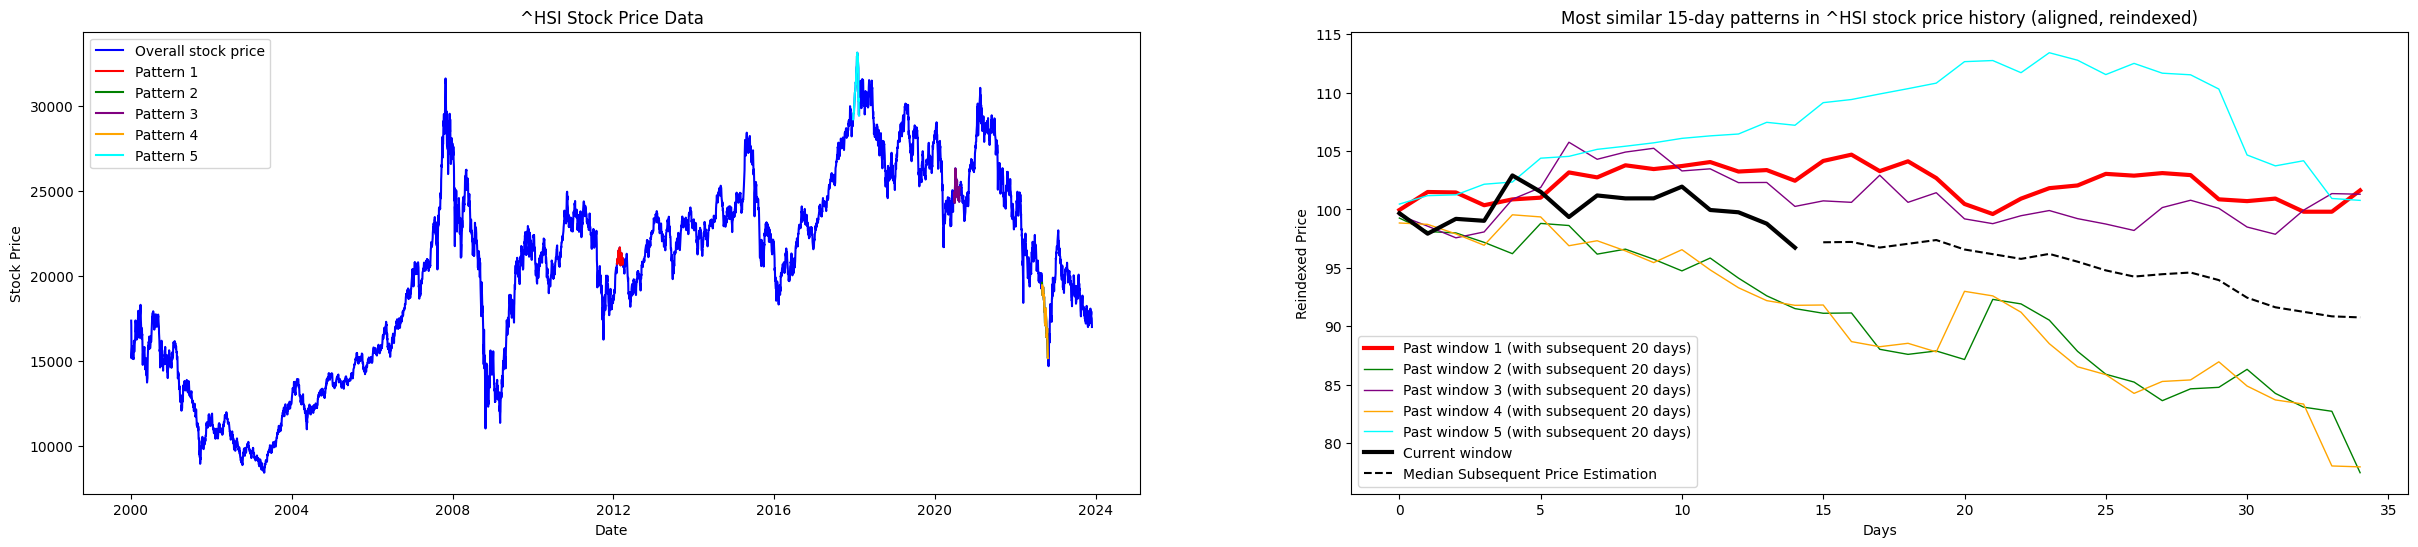

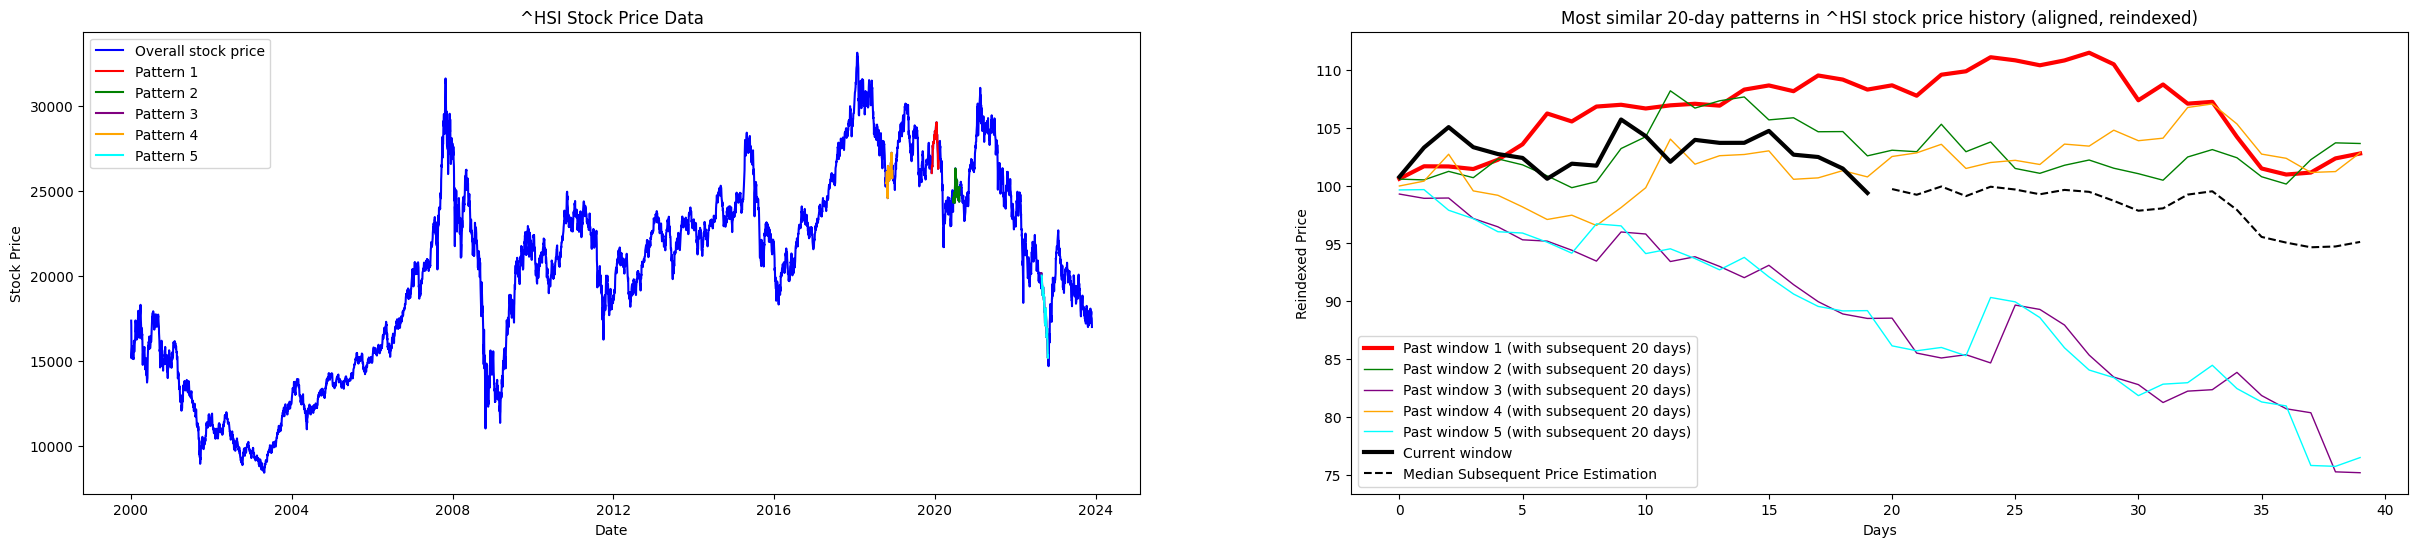

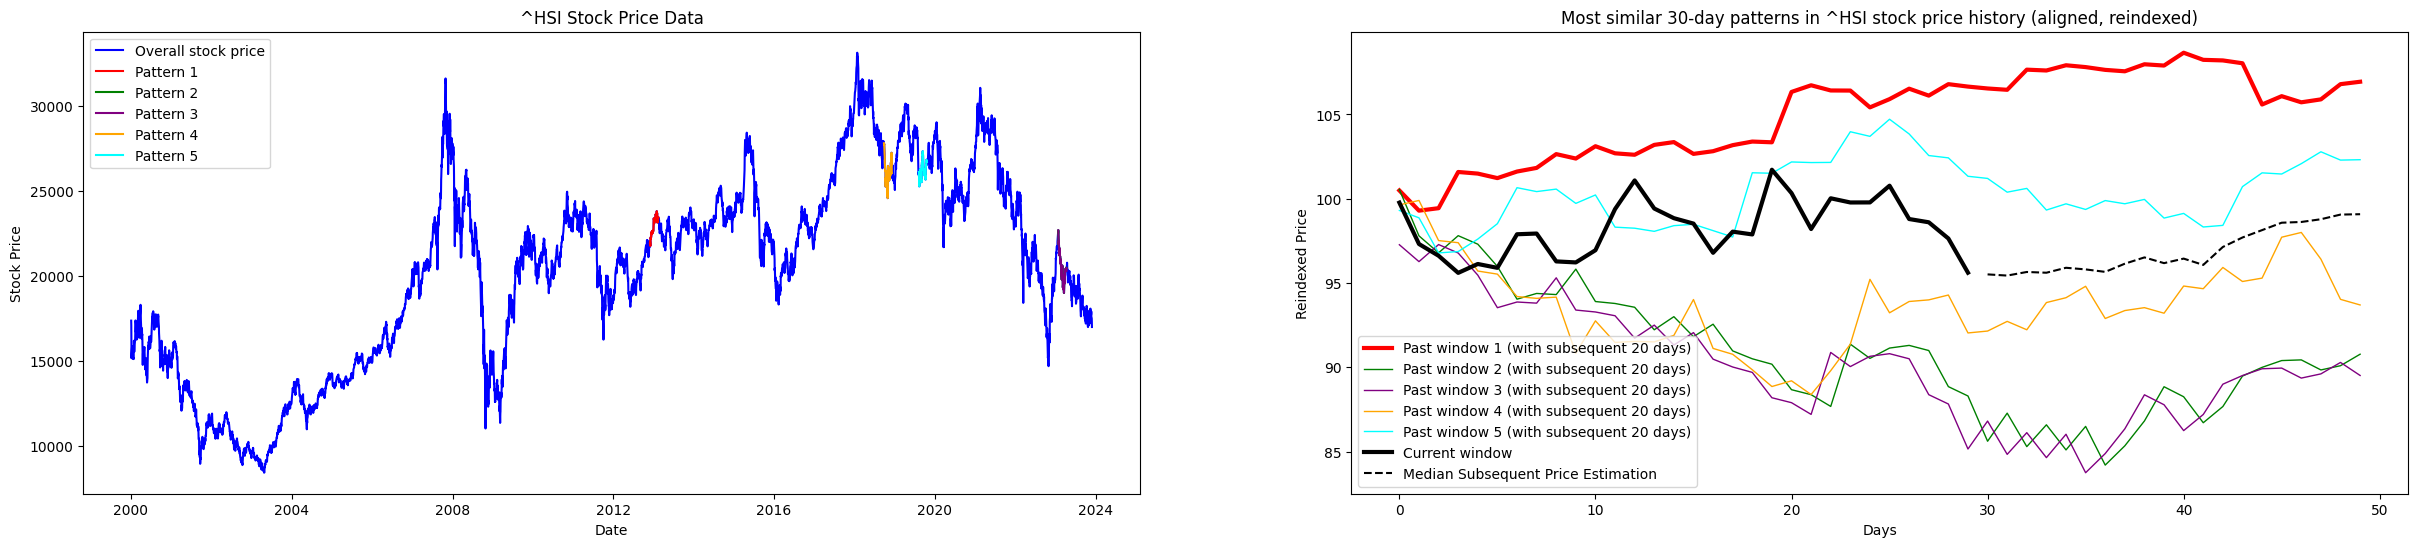

In [7]:
# Get data from yfinance
ticker = "^HSI"
start_date = '2000-01-01'
end_date = '2023-11-30'
data = yf.download(ticker, start=start_date, end=end_date)

# Transform price data into returns
price_data = data['Close']
price_data_pct_change = price_data.pct_change().dropna()

# Differnt Windows to find patterns on, 
# e.g. if 15, The code will  find the most similar 15 day in the history
days_to = [15, 20, 30]

# Number of days for price development observation
# e.g. if 20, then the subsequent 20 days after pattern window is found will be plotted
subsequent_days = 20

for n_days in days_to: 
    min_distances = find_most_similar_pattern(n_days, 5)
    fig, axs = plt.subplots(1, 2, figsize=(30, 6))
    axs[0].plot(price_data, color='blue', label='Overall stock price')
    color_cycle = ['red', 'green', 'purple', 'orange', 'cyan']
    subsequent_prices = []

    for i, (_, start_index) in enumerate(min_distances):
        color = color_cycle[i % len(color_cycle)]
        past_window_start_date = price_data.index[start_index]
        past_window_end_date = price_data.index[start_index + n_days + subsequent_days]
        axs[0].plot(price_data[past_window_start_date:past_window_end_date], color=color, label=f"Pattern {i + 1}")
        # Store subsequent prices for median calculation
        subsequent_window = price_data_pct_change[start_index + n_days : start_index + n_days + subsequent_days].values
        subsequent_prices.append(subsequent_window)

    axs[0].set_title(f'{ticker} Stock Price Data')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Stock Price')
    axs[0].legend()

    for i, (_, start_index) in enumerate(min_distances):
        color = color_cycle[i % len(color_cycle)]
        past_window = price_data_pct_change[start_index:start_index + n_days + subsequent_days]
        reindexed_past_window = (past_window + 1).cumprod() * 100
        axs[1].plot(range(n_days + subsequent_days), reindexed_past_window, color=color, linewidth=3 if i == 0 else 1, label=f"Past window {i + 1} (with subsequent {subsequent_days} days)")

    reindexed_current_window = (price_data_pct_change[-n_days:] + 1).cumprod() * 100
    axs[1].plot(range(n_days), reindexed_current_window, color='k', linewidth=3, label="Current window")
    
    # Compute and plot the median subsequent prices
    subsequent_prices = np.array(subsequent_prices)
    median_subsequent_prices = np.median(subsequent_prices, axis=0)
    median_subsequent_prices_cum = (median_subsequent_prices + 1).cumprod() * reindexed_current_window.iloc[-1]
    
    axs[1].plot(range(n_days, n_days + subsequent_days), median_subsequent_prices_cum, color='black', linestyle='dashed', label="Median Subsequent Price Estimation")
    axs[1].set_title(f"Most similar {n_days}-day patterns in {ticker} stock price history (aligned, reindexed)")
    axs[1].set_xlabel("Days")
    axs[1].set_ylabel("Reindexed Price")
    axs[1].legend()

    plt.show()

In [8]:
start = '2001-11-01'
end = '2023-11-01'

train1 = '2011-11-01'
test_test = '2012-02-01'
train2 = '2018-11-01'
test = '2013-11-01'

In [9]:
# Check if the file exists
target_file_path = 'hsi.csv'
try:
    # Try to read the file
    hsi = pd.read_csv(target_file_path, header=0, index_col=0)
except FileNotFoundError:
    # If the file doesn't exist, download data
    hsi = pdr.get_data_yahoo('^HSI', start, end)

    # Save the DataFrame to a CSV file
    hsi.to_csv(target_file_path, index = True)

hsi.index = pd.to_datetime(hsi.index)

target = hsi.copy()
# convert to log return
target["log return"] = np.log(target["Adj Close"]/target["Adj Close"].shift(1))
target["pct return"] = target["Adj Close"].pct_change()
target.dropna(inplace = True)
target.iloc[:, -2:]

log return  pct return
Date                              
2001-11-02    0.002675    0.002678
2001-11-05    0.023735    0.024019
2001-11-06   -0.007184   -0.007159
2001-11-07   -0.008364   -0.008329
2001-11-08    0.025840    0.026177
...                ...         ...
2023-10-25    0.005505    0.005520
2023-10-26   -0.002386   -0.002383
2023-10-27    0.020563    0.020776
2023-10-30    0.000438    0.000438
2023-10-31   -0.017028   -0.016883

[5423 rows x 2 columns]

In [10]:
target = hsi.copy()
# convert to log return
target["log return"] = np.log(target["Adj Close"]/target["Adj Close"].shift(1))
target["pct return"] = target["Adj Close"].pct_change()
target.dropna(inplace = True)
target.iloc[:, -2:]

log return  pct return
Date                              
2001-11-02    0.002675    0.002678
2001-11-05    0.023735    0.024019
2001-11-06   -0.007184   -0.007159
2001-11-07   -0.008364   -0.008329
2001-11-08    0.025840    0.026177
...                ...         ...
2023-10-25    0.005505    0.005520
2023-10-26   -0.002386   -0.002383
2023-10-27    0.020563    0.020776
2023-10-30    0.000438    0.000438
2023-10-31   -0.017028   -0.016883

[5423 rows x 2 columns]

> # DTW with kNN to match with ALL `PAST DATA`
* very computational costly
* reduced test window frame
* best result in test may not be performing in deployment, may be due to lack of testing entry
* best tuned parameter results:
1. nDTW=17, window frame to calculate on `euclidean` distance of scaled time series data in DTW
2. kNN=2, number of nearest neighbours for predictions
3. subsequent_days=1, number of days to predict in current window 
4. threshold=0.0004, threshold for filter out significant trading signals
* possible improvment:
1. effectiveness of `PAST DATA`
2. threshold for `euclidean` distance to be explored
3. updating of `PAST DATA`
4. further fine tuning on parameters

> #### Trial test for 3 months to see if DTW with kNN could be profitable

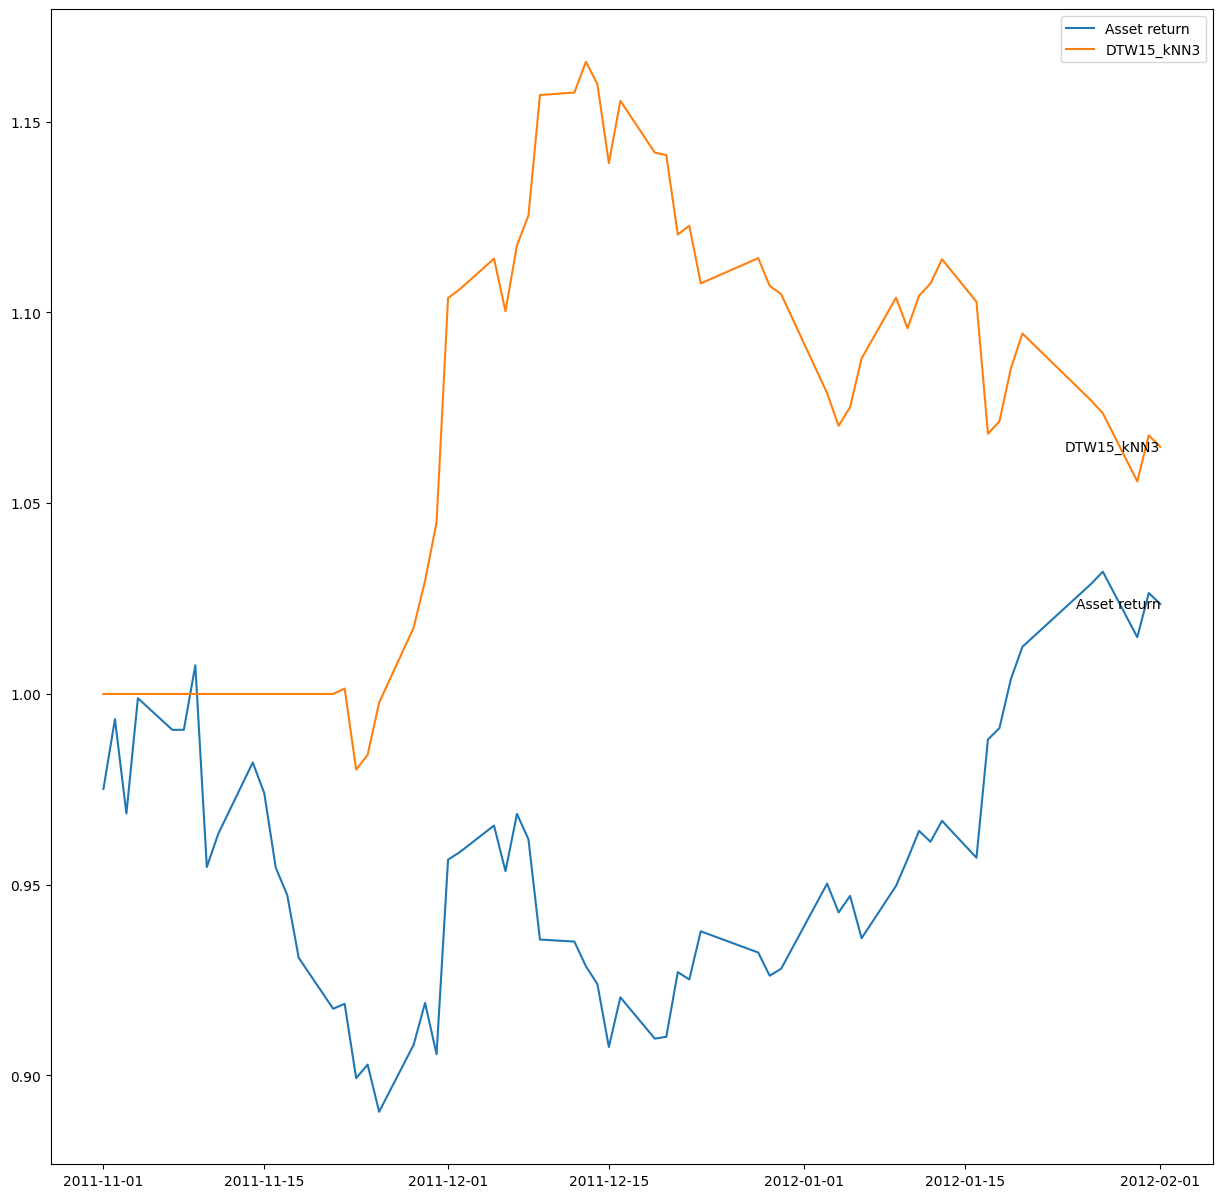

CAGR%  Sharpe Ratio  Sortino Ratio  Max Drawdown%  \
Asset return   9.689341      0.883068       1.339893     -11.616365   
DTW15_kNN3    28.273630      1.348453       2.195705      -9.434970   

              Max Drawdown$  Max Drawdown (Days)  \
Asset return  -11703.823480                   71   
DTW15_kNN3    -10998.325456                   49   

              Multiples of Invested Capital  Win  Loss       Win%  
Asset return                       1.023584   32    29  52.459016  
DTW15_kNN3                         1.064772   27    19  58.695652

In [11]:
hsi_DTW_kNN = DTW_kNN(target.iloc[:, -2:], 15, 3, 2,
                      [start, train1, test_test],
                     1e5, 0)

hsi_DTW_kNN

In [12]:
f'{0.0012:.2e}'

'1.20e-03'

> #### Fine tuning test for 3 months to find best combination of (W, K, F)
* W: DTW window frame
* K: number of nearest neighbours
* F: number of days to predict

#### the best result is W=17, K=2, F=1

13 1 1 0
13 1 2 0
13 1 3 0
13 2 1 0
13 2 2 0
13 2 3 0
13 3 1 0
13 3 2 0
13 3 3 0
15 1 1 0
15 1 2 0
15 1 3 0
15 2 1 0
15 2 2 0
15 2 3 0
15 3 1 0
15 3 2 0
15 3 3 0
17 1 1 0
17 1 2 0
17 1 3 0
17 2 1 0
17 2 2 0
17 2 3 0
17 3 1 0
17 3 2 0
17 3 3 0


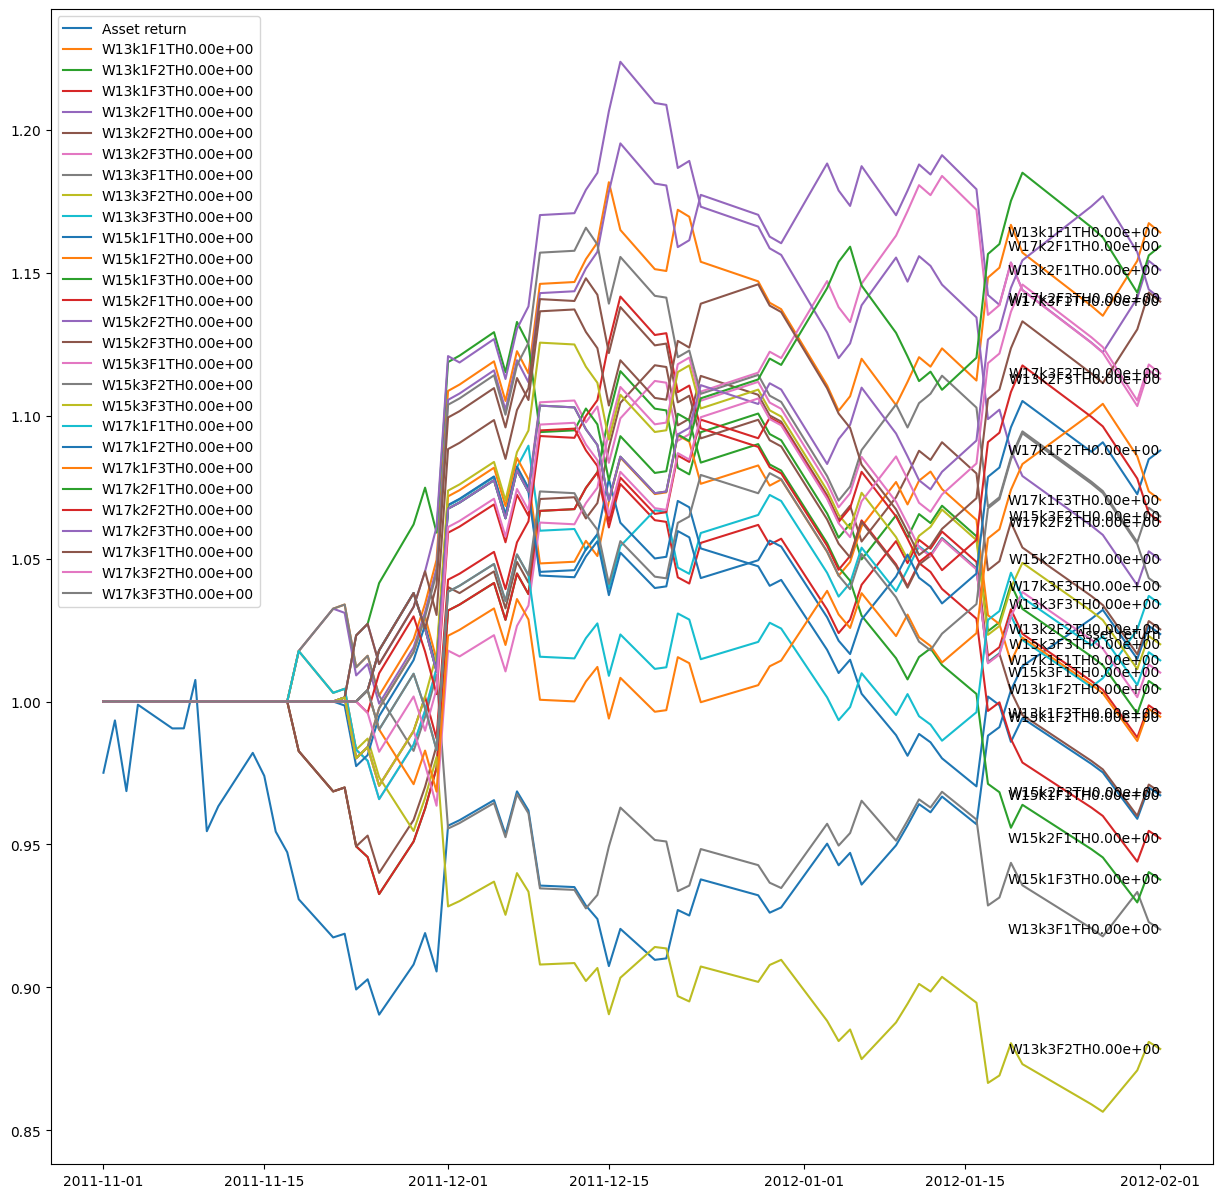

CAGR%  Sharpe Ratio  Sortino Ratio  Max Drawdown%  \
W17k2F1TH0.00e+00  79.736821      3.136037       6.721758      -4.317382   
W13k1F1TH0.00e+00  82.678405      3.082990       6.128297      -6.764876   
W17k3F1TH0.00e+00  68.088102      2.779453       5.762983      -8.262349   
W17k2F3TH0.00e+00  68.703181      2.799674       5.649268      -3.338006   
W13k2F1TH0.00e+00  74.640523      2.858325       5.298812      -6.114741   
W17k3F2TH0.00e+00  53.866651      2.313269       4.674253      -4.384977   
W13k2F3TH0.00e+00  52.806895      2.186103       3.823260      -6.798664   
W17k1F2TH0.00e+00  39.631249      1.811336       3.189611      -5.942284   
W17k1F3TH0.00e+00  31.020603      1.481147       2.636467      -4.036039   
W17k2F2TH0.00e+00  27.342090      1.332748       2.531634      -4.896981   
W15k3F2TH0.00e+00  28.273630      1.348453       2.195705      -9.434970   
W15k2F2TH0.00e+00  21.164009      1.060603       1.798809     -14.960740   
W17k3F3TH0.00e+00  16.943276      0.896606       1.657605      -5.737809   
Asset return        9.689341      0.883068       1.339893     -11.616365   
W13k3F3TH0.00e+00  14.194606      0.752344       1.149743      -7.745442   
W13k2F2TH0.00e+00  10.397443      0.586179       0.942588      -9.043908   
W15k3F3TH0.00e+00   8.185105      0.494343       0.794356     -10.142349   
W17k1F1TH0.00e+00   5.834444      0.388457       0.644140      -6.193676   
W15k3F1TH0.00e+00   4.072790      0.300866       0.482690     -10.601359   
W13k1F2TH0.00e+00   1.745218      0.188530       0.298987     -10.731594   
W13k1F3TH0.00e+00  -1.626625      0.024427       0.037969      -8.585617   
W15k1F2TH0.00e+00  -2.103127     -0.004367      -0.006668      -9.780175   
W15k2F3TH0.00e+00 -12.017789     -0.537216      -0.834534     -16.376812   
W15k1F1TH0.00e+00 -12.392277     -0.557835      -0.895783     -11.381258   
W15k2F1TH0.00e+00 -17.694186     -0.871286      -1.327360     -17.309729   
W15k1F3TH0.00e+00 -22.519034     -1.175835      -1.744837     -17.921352   
W13k3F1TH0.00e+00 -28.077317     -1.532456      -1.857140     -11.224582   
W13k3F2TH0.00e+00 -40.187781     -2.471232      -2.834611     -15.832673   

                   Max Drawdown$  Max Drawdown (Days)  \
W17k2F1TH0.00e+00   -5004.098345                   12   
W13k1F1TH0.00e+00   -7993.511274                   47   
W17k3F1TH0.00e+00   -9468.018170                   34   
W17k2F3TH0.00e+00   -3709.511502                   18   
W13k2F1TH0.00e+00   -7308.270783                   44   
W17k3F2TH0.00e+00   -4849.714518                   19   
W13k2F3TH0.00e+00   -8048.325696                   16   
W17k1F2TH0.00e+00   -6422.539316                   41   
W17k1F3TH0.00e+00   -4180.679863                   26   
W17k2F2TH0.00e+00   -5472.588141                   20   
W15k3F2TH0.00e+00  -10998.325456                   49   
W15k2F2TH0.00e+00  -18307.892878                   44   
W17k3F3TH0.00e+00   -6196.099188                   20   
Asset return       -11703.823480                   71   
W13k3F3TH0.00e+00   -8438.432511                   54   
W13k2F2TH0.00e+00  -10107.468036                   43   
W15k3F3TH0.00e+00  -11415.253875                   51   
W17k1F1TH0.00e+00   -6512.150084                   55   
W15k3F1TH0.00e+00  -11876.557711                   40   
W13k1F2TH0.00e+00  -11971.551079                   44   
W13k1F3TH0.00e+00   -9273.672862                   48   
W15k1F2TH0.00e+00  -10690.743556                   41   
W15k2F3TH0.00e+00  -18800.834408                   49   
W15k1F1TH0.00e+00  -12316.072739                   55   
W15k2F1TH0.00e+00  -19761.037097                   44   
W15k1F3TH0.00e+00  -20300.262668                   55   
W13k3F1TH0.00e+00  -11605.304714                   70   
W13k3F2TH0.00e+00  -16112.008107                   72   

                   Multiples of Invested Capital  Win  Loss       Win%  
W17k2F1TH0.00e+00                       1.159264   25    19  56.818182  
W13k1F1TH0.00e+00 

In [13]:
hsi_DTW_kNN_tuning_all =\
    DTW_kNN_tuning(target.iloc[:, -2:],
                   [13,15,17], [1,2,3], [1,2,3],
                   [start, train1, test_test],
                   [0], 1e5)

hsi_DTW_kNN_tuning_all.sort_values(by='Sortino Ratio', ascending = False)

> #### Fine tuning test for 3 months to find best Threshold TH based on above result 
* W: DTW window frame
* K: number of nearest neighbours
* F: number of days to predict

#### the best result within choices is TH=0.0004
#### Final combination of (W,K,F,TH)=(17,2,1,0.0004)

17 2 1 0
17 2 1 0.0004
17 2 1 0.0008
17 2 1 0.0012
17 2 1 0.0014


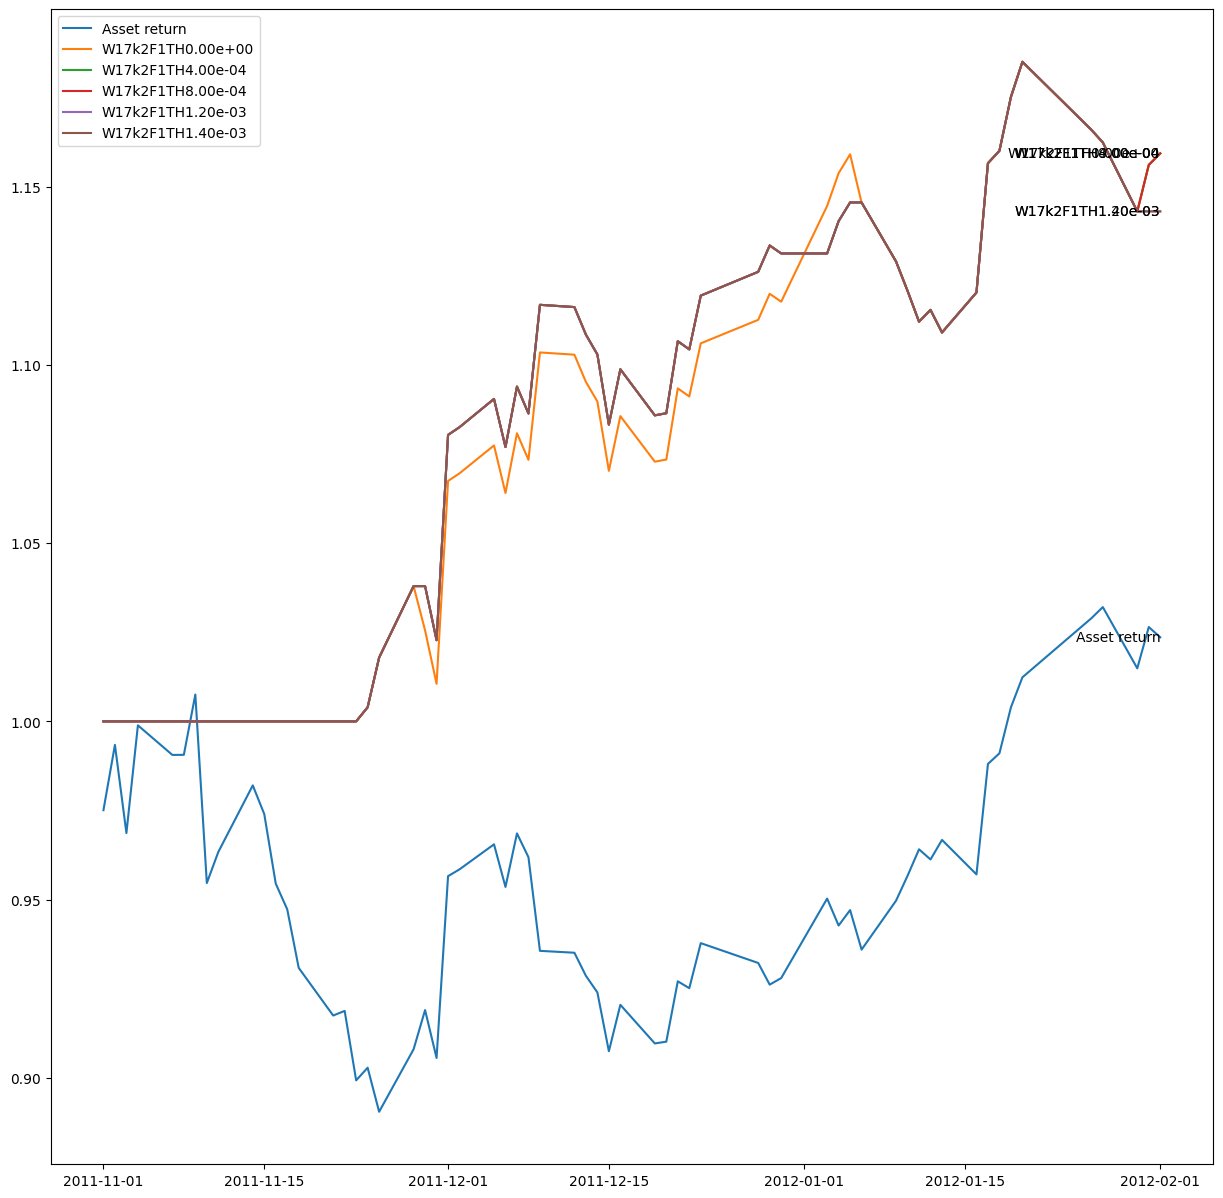

CAGR%  Sharpe Ratio  Sortino Ratio  Max Drawdown%  \
W17k2F1TH4.00e-04  79.785362      3.277678       7.195575      -3.541405   
W17k2F1TH8.00e-04  79.785362      3.277678       7.195575      -3.541405   
W17k2F1TH0.00e+00  79.736821      3.136037       6.721758      -4.317382   
W17k2F1TH1.20e-03  69.968428      2.983711       6.523904      -3.541405   
W17k2F1TH1.40e-03  69.968428      2.983711       6.523904      -3.541405   
Asset return        9.689341      0.883068       1.339893     -11.616365   

                   Max Drawdown$  Max Drawdown (Days)  \
W17k2F1TH4.00e-04   -4196.624280                   11   
W17k2F1TH8.00e-04   -4196.624280                   11   
W17k2F1TH0.00e+00   -5004.098345                   12   
W17k2F1TH1.20e-03   -4196.624280                   11   
W17k2F1TH1.40e-03   -4196.624280                   11   
Asset return       -11703.823480                   71   

                   Multiples of Invested Capital  Win  Loss       Win%  
W17k2F1TH4.00e-04                       1.159343   24    17  58.536585  
W17k2F1TH8.00e-04                       1.159343   24    17  58.536585  
W17k2F1TH0.00e+00                       1.159264   25    19  56.818182  
W17k2F1TH1.20e-03                       1.143051   22    17  56.410256  
W17k2F1TH1.40e-03                       1.143051   22    17  56.410256  
Asset return                            1.023584   32    29  52.459016

In [14]:
hsi_DTW_kNN_TH =\
    DTW_kNN_tuning(target.iloc[:, -2:],
                   [17], [2], [1],
                   [start, train1, test_test],
                   [0, 0.0004, 0.0008, 0.0012, 0.0014], 1e5)

hsi_DTW_kNN_TH.sort_values(by='Sortino Ratio', ascending = False)

> # Deploy test on (W,K,F,TH)=(17,2,1,0.0004)
* rolling window of 6 months is chosen, as a balance between consistance and computing time.
* 20 results for 10 year period shows 10 better than asset, and 10 worse than asset.

In [15]:
nDTW_, kNN_, subsequent_days_, threshold_ =\
17, 2, 1, 0.0004

nDTW_, kNN_, subsequent_days_, threshold_

(17, 2, 1, 0.0004)

In [16]:
deploy_6m = '2014-05-01'
deploy_12m = '2014-11-01'
deploy_18m = '2015-05-01'
deploy_24m = '2015-11-01'
deploy_30m = '2016-05-01'

deploy_36m = '2016-11-01'
deploy_42m = '2017-05-01'
deploy_48m = '2017-11-01'
deploy_54m = '2018-05-01'
deploy_60m = '2018-11-01'

deploy_66m = '2019-05-01'
deploy_72m = '2019-11-01'
deploy_78m = '2020-05-01'
deploy_84m = '2020-11-01'
deploy_90m = '2021-05-01'

deploy_96m = '2021-11-01'
deploy_102m = '2022-05-01'
deploy_108m = '2022-11-01'
deploy_114m = '2023-05-01'
deploy_120m = '2023-11-01'

In [17]:
rolling_6m_DTW=\
    [
    test,
    deploy_6m,
    deploy_12m,
    deploy_18m,
    deploy_24m,    
    deploy_30m,
    
    deploy_36m,  
    deploy_42m,
    deploy_48m,
    deploy_54m,    
    deploy_60m,    
    
    deploy_66m,
    deploy_72m,
    deploy_78m,
    deploy_84m,    
    deploy_90m,
    
    deploy_96m,  
    deploy_102m,
    deploy_108m,
    deploy_114m,    
    deploy_120m,     
    ]

len(rolling_6m_DTW)

21

17 2 1 0.0004


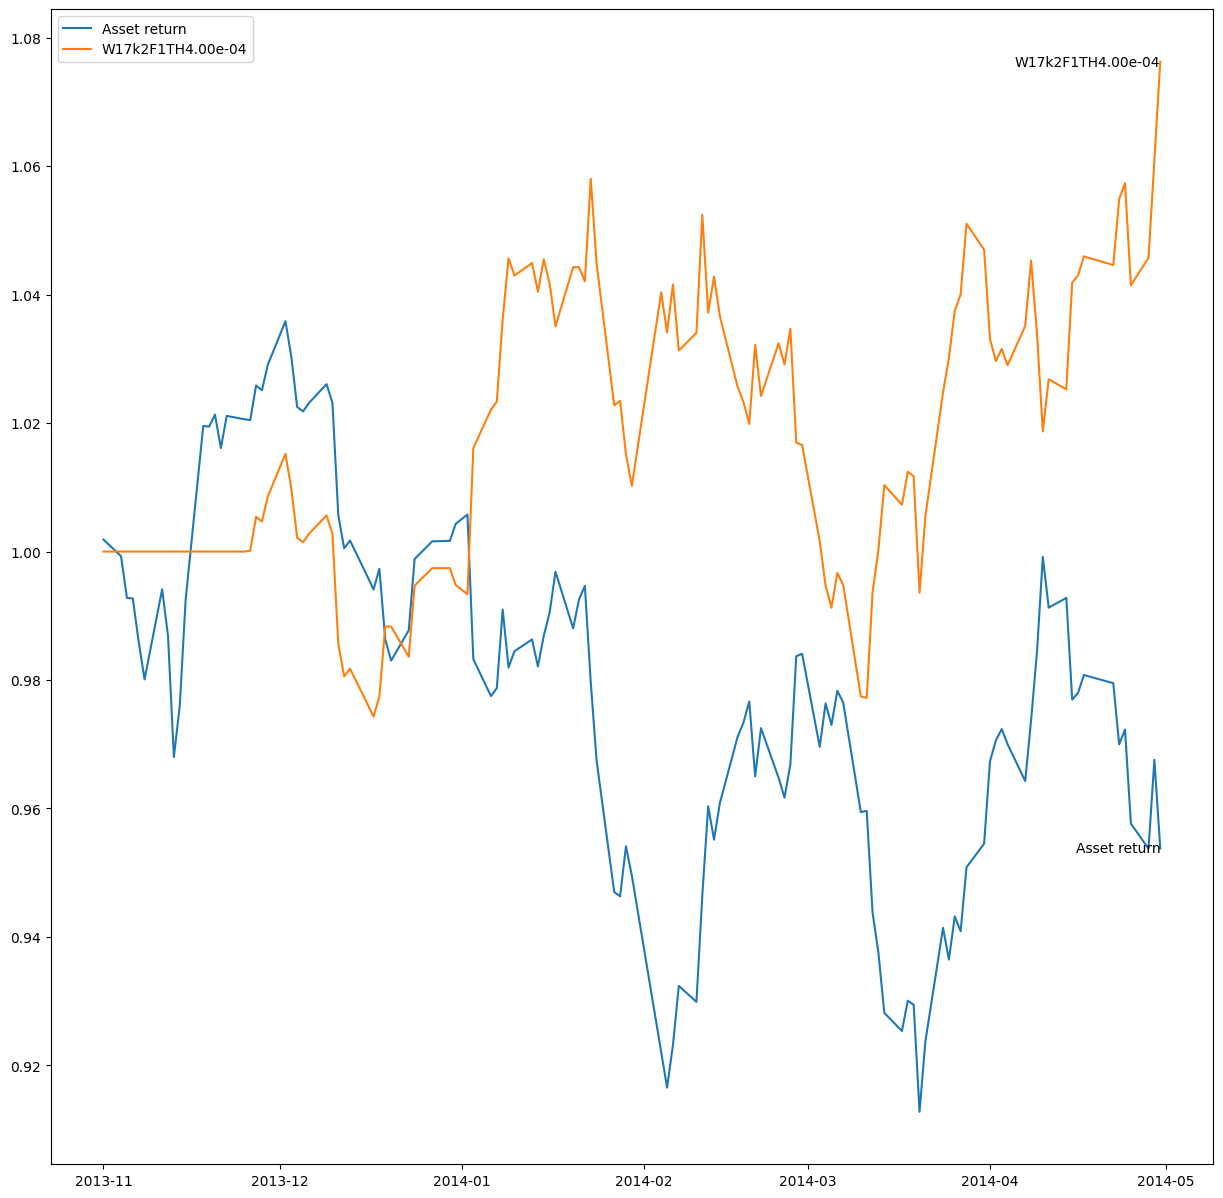

CAGR%  Sharpe Ratio  Sortino Ratio  Max Drawdown%  \
Asset return       -9.148209     -0.599477      -0.806626     -11.882541   
W17k2F1TH4.00e-04  16.068749      1.176425       1.815015      -7.636689   

                   Max Drawdown$  Max Drawdown (Days)  \
Asset return       -12308.649439                  148   
W17k2F1TH4.00e-04   -8079.821657                   95   

                   Multiples of Invested Capital  Win  Loss       Win%  
Asset return                            0.953789   62    60  50.819672  
W17k2F1TH4.00e-04                       1.076253   52    50  50.980392

In [18]:
hsi_DTW_kNN_deploy_6m =\
    DTW_kNN_tuning(target.iloc[:, -2:],
                   [nDTW_], [kNN_], [subsequent_days_],
                   [start, test, deploy_6m],
                   [threshold_], 1e5)

hsi_DTW_kNN_deploy_6m

In [19]:
nDTW_, kNN_, subsequent_days_, threshold_

(17, 2, 1, 0.0004)

2013-11-01 2014-05-01
17 2 1 0.0004


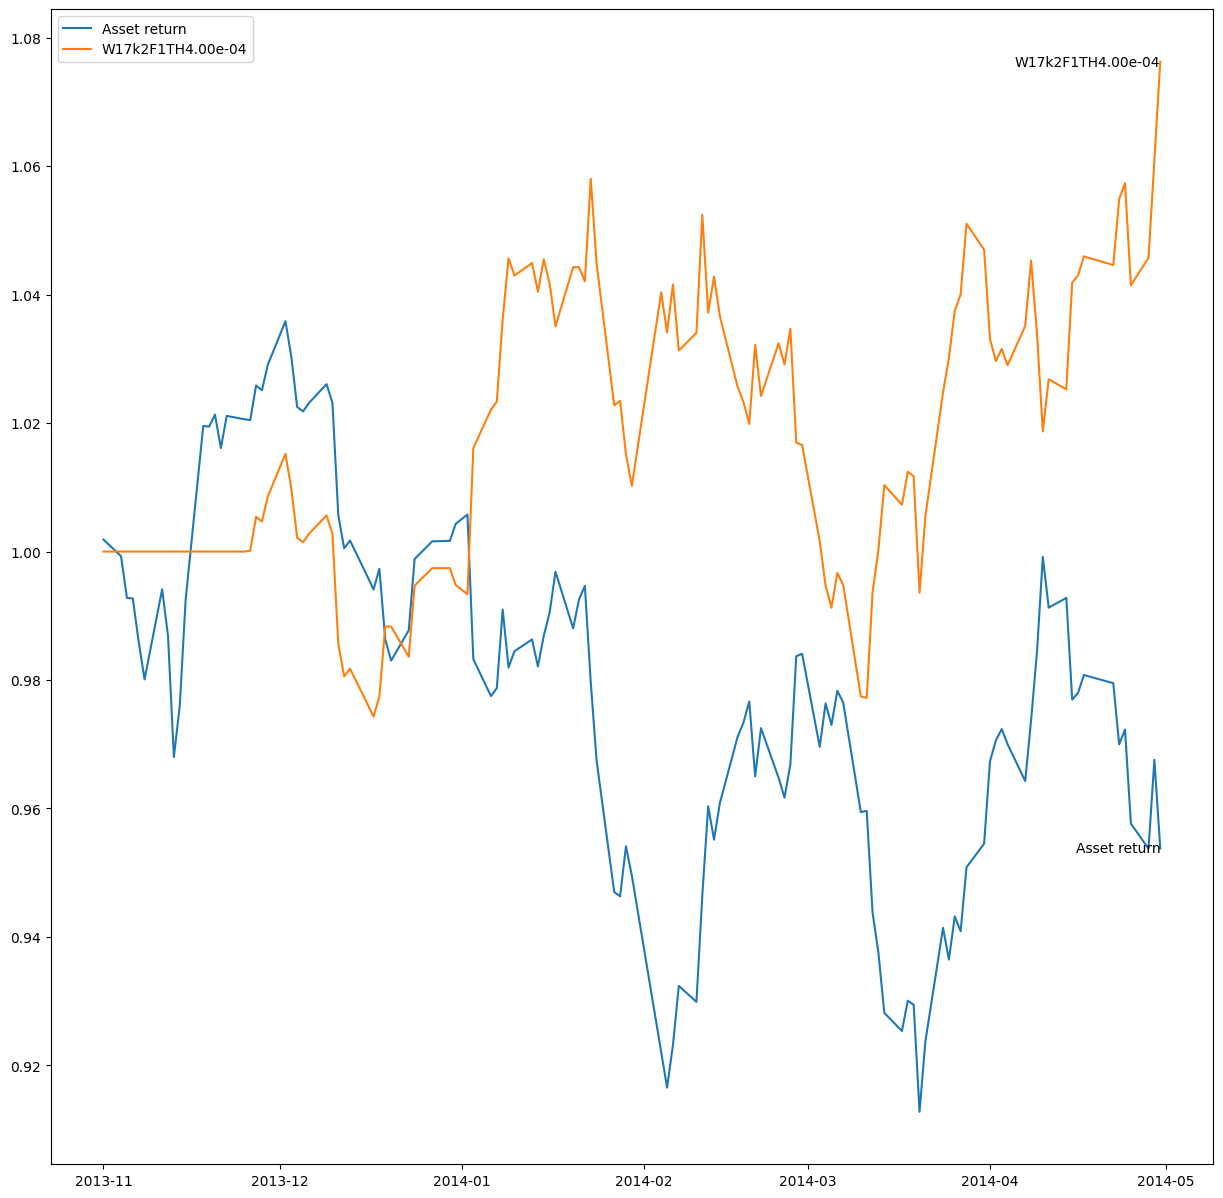

2014-05-01 2014-11-01
17 2 1 0.0004


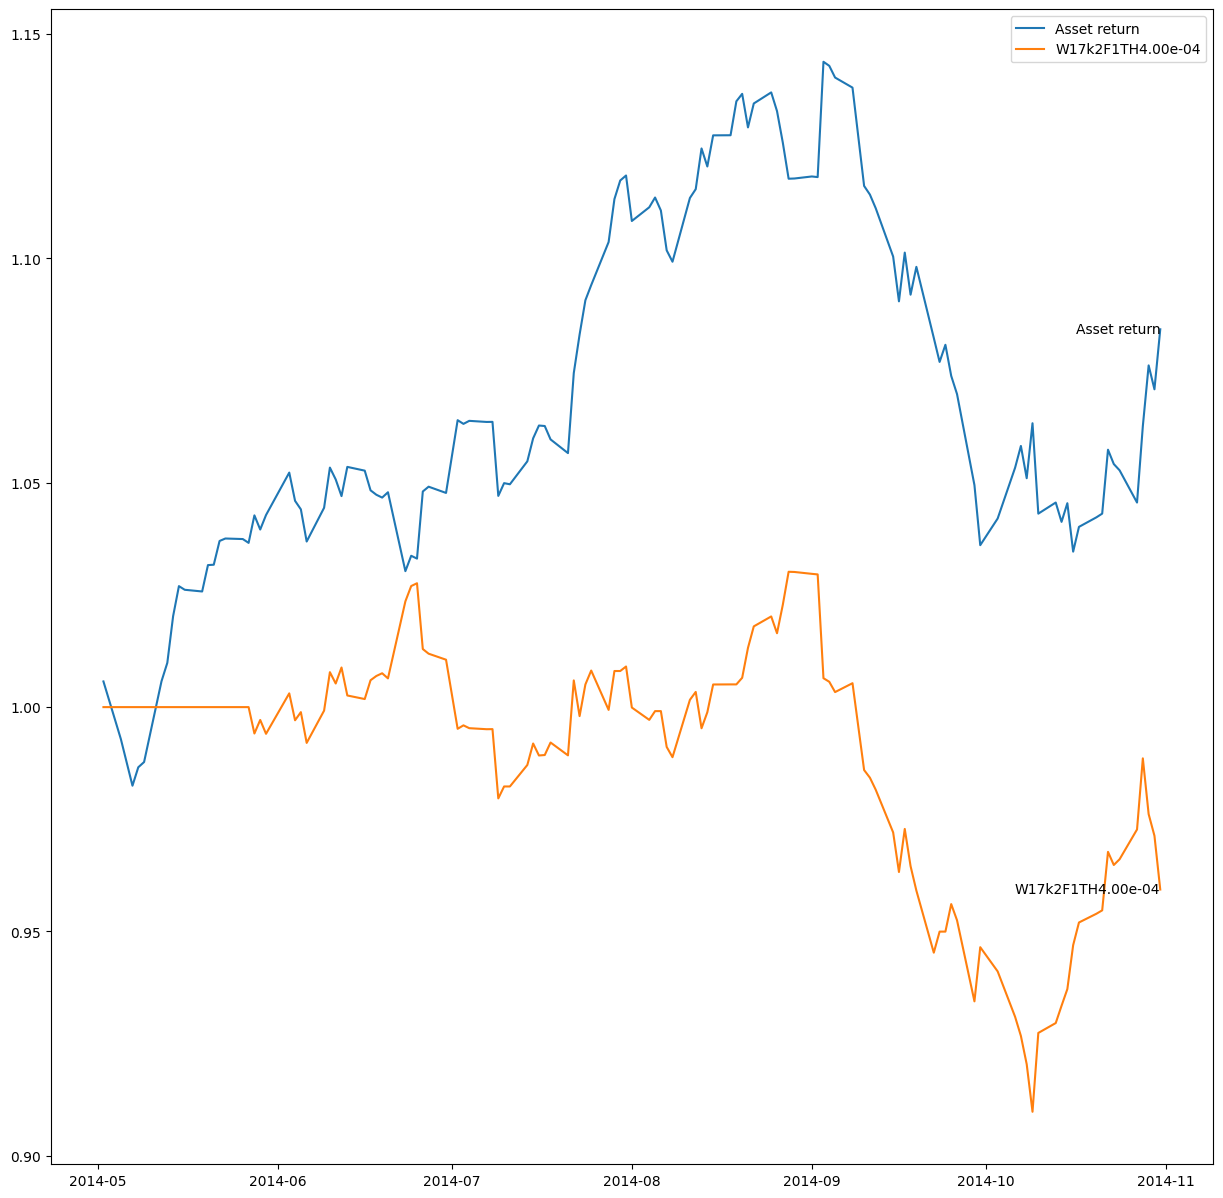

2014-11-01 2015-05-01
17 2 1 0.0004


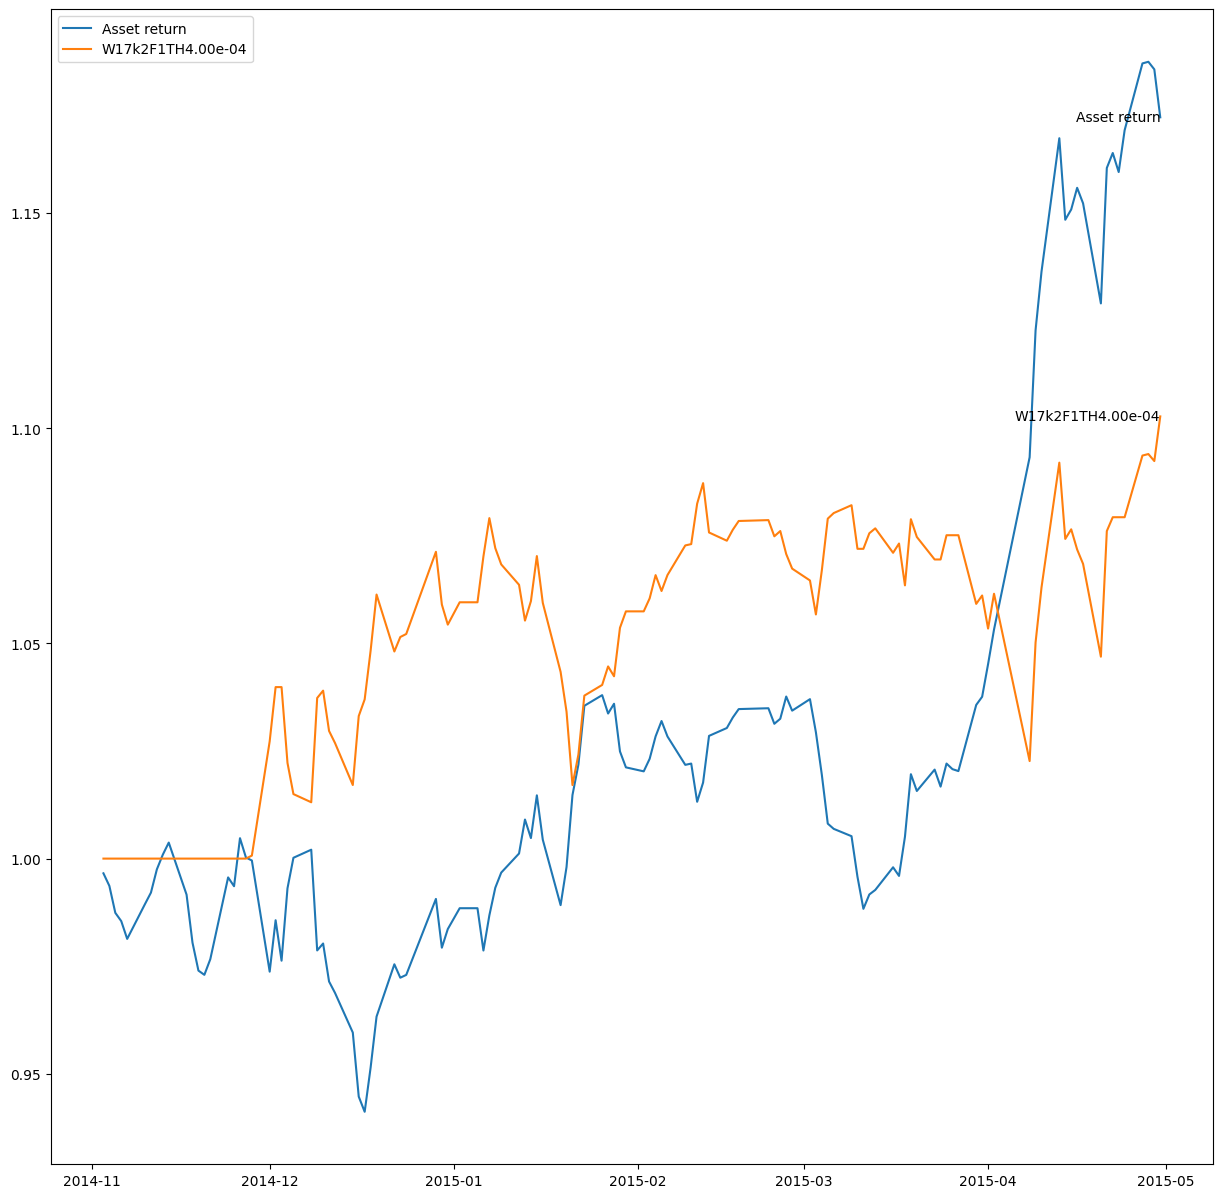

2015-05-01 2015-11-01
17 2 1 0.0004


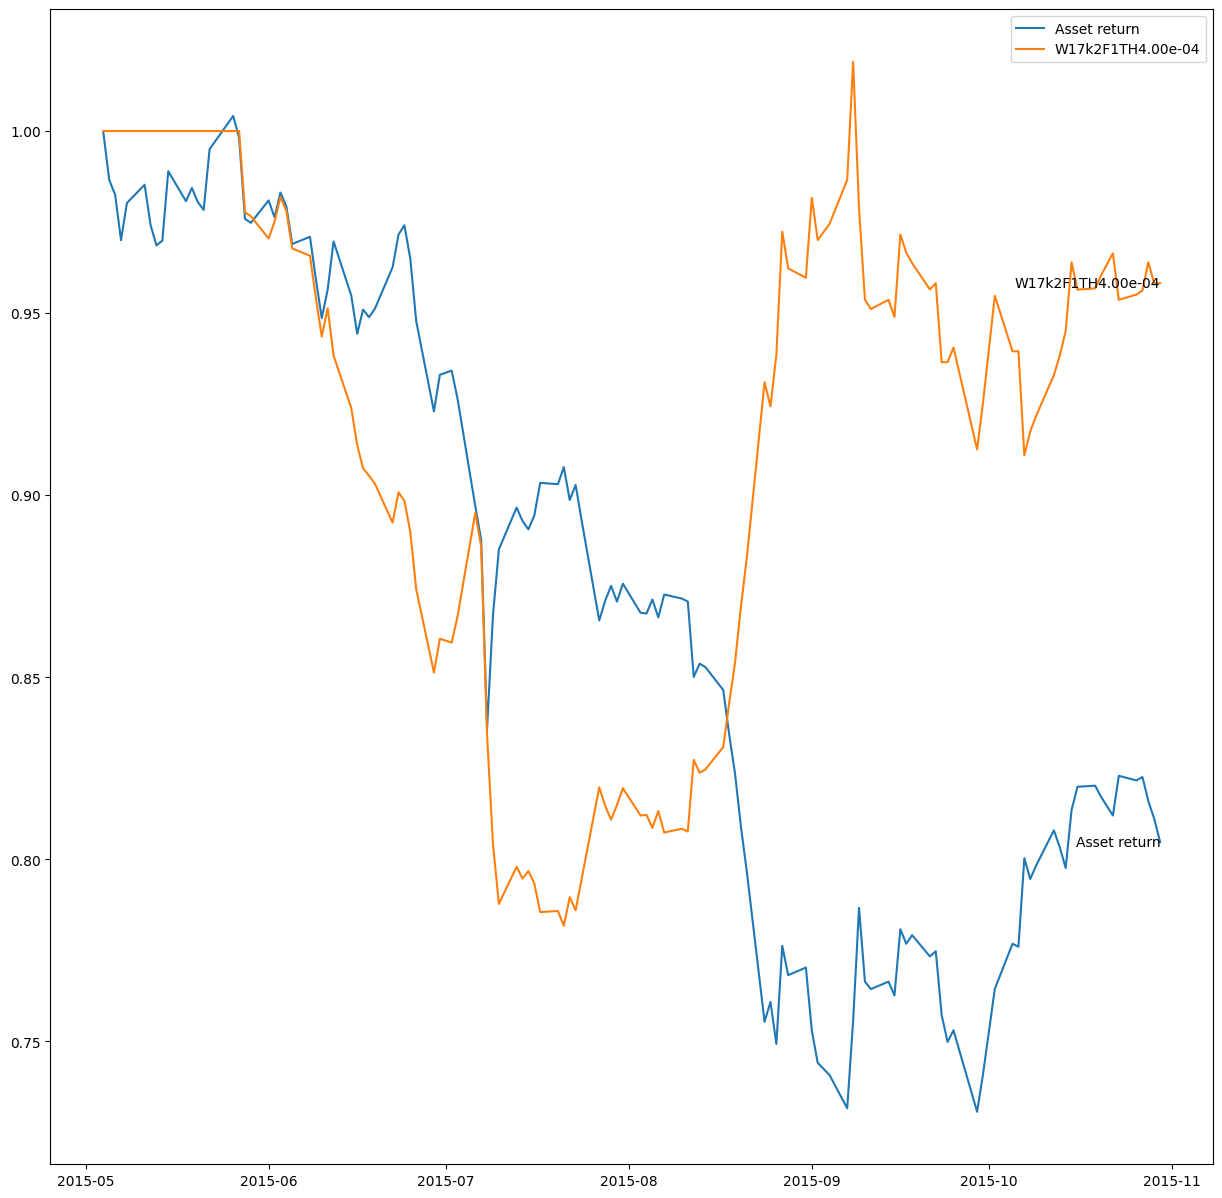

2015-11-01 2016-05-01
17 2 1 0.0004


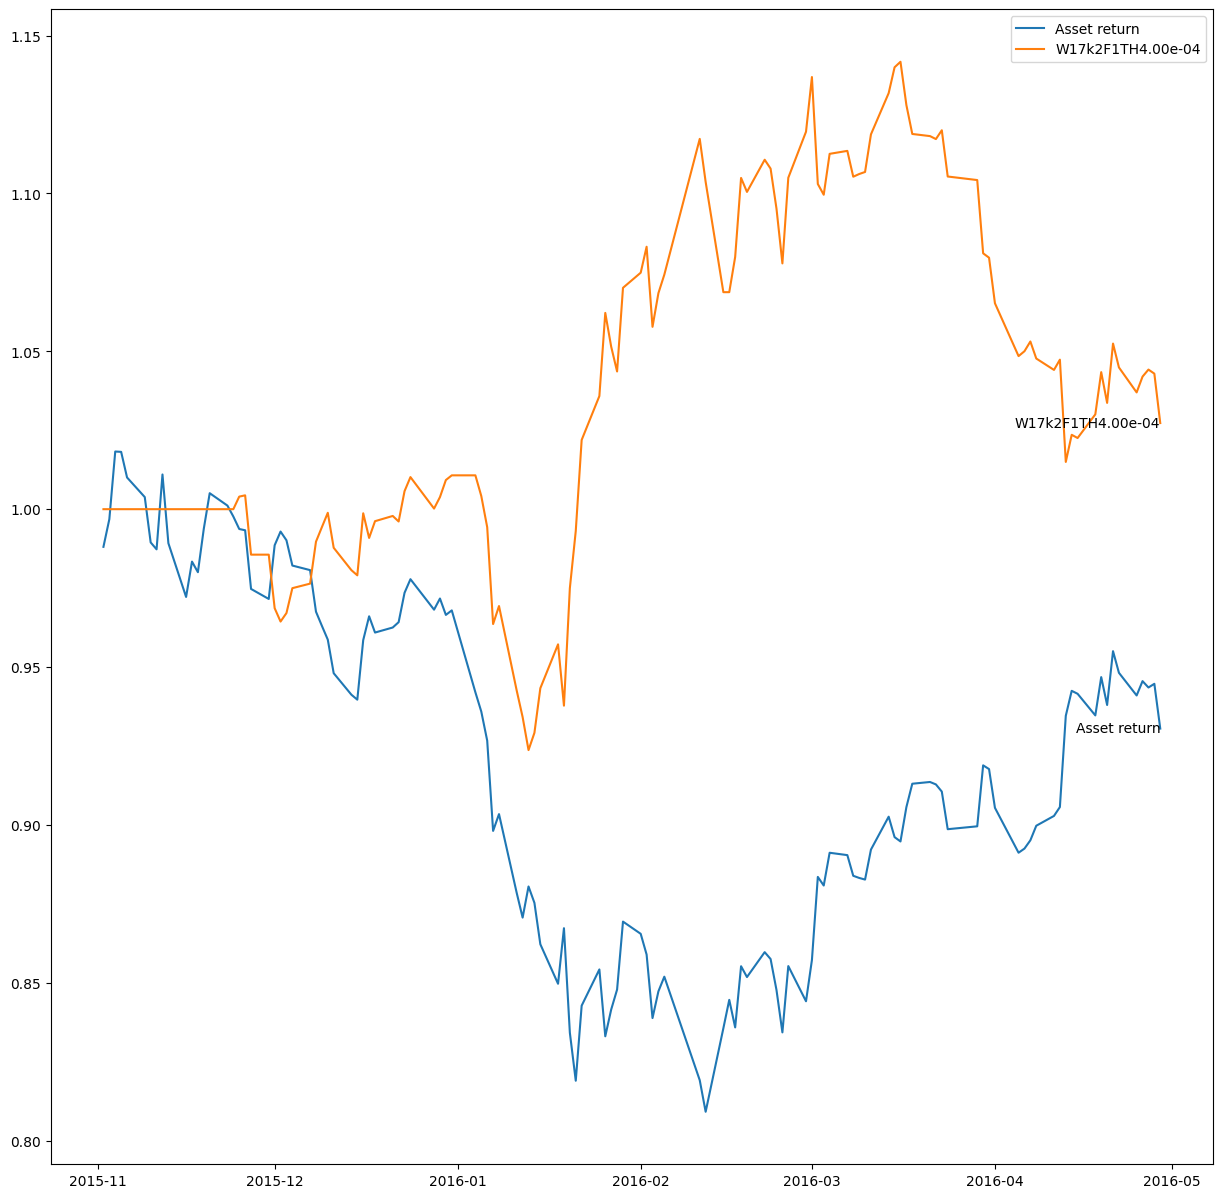

2016-05-01 2016-11-01
17 2 1 0.0004


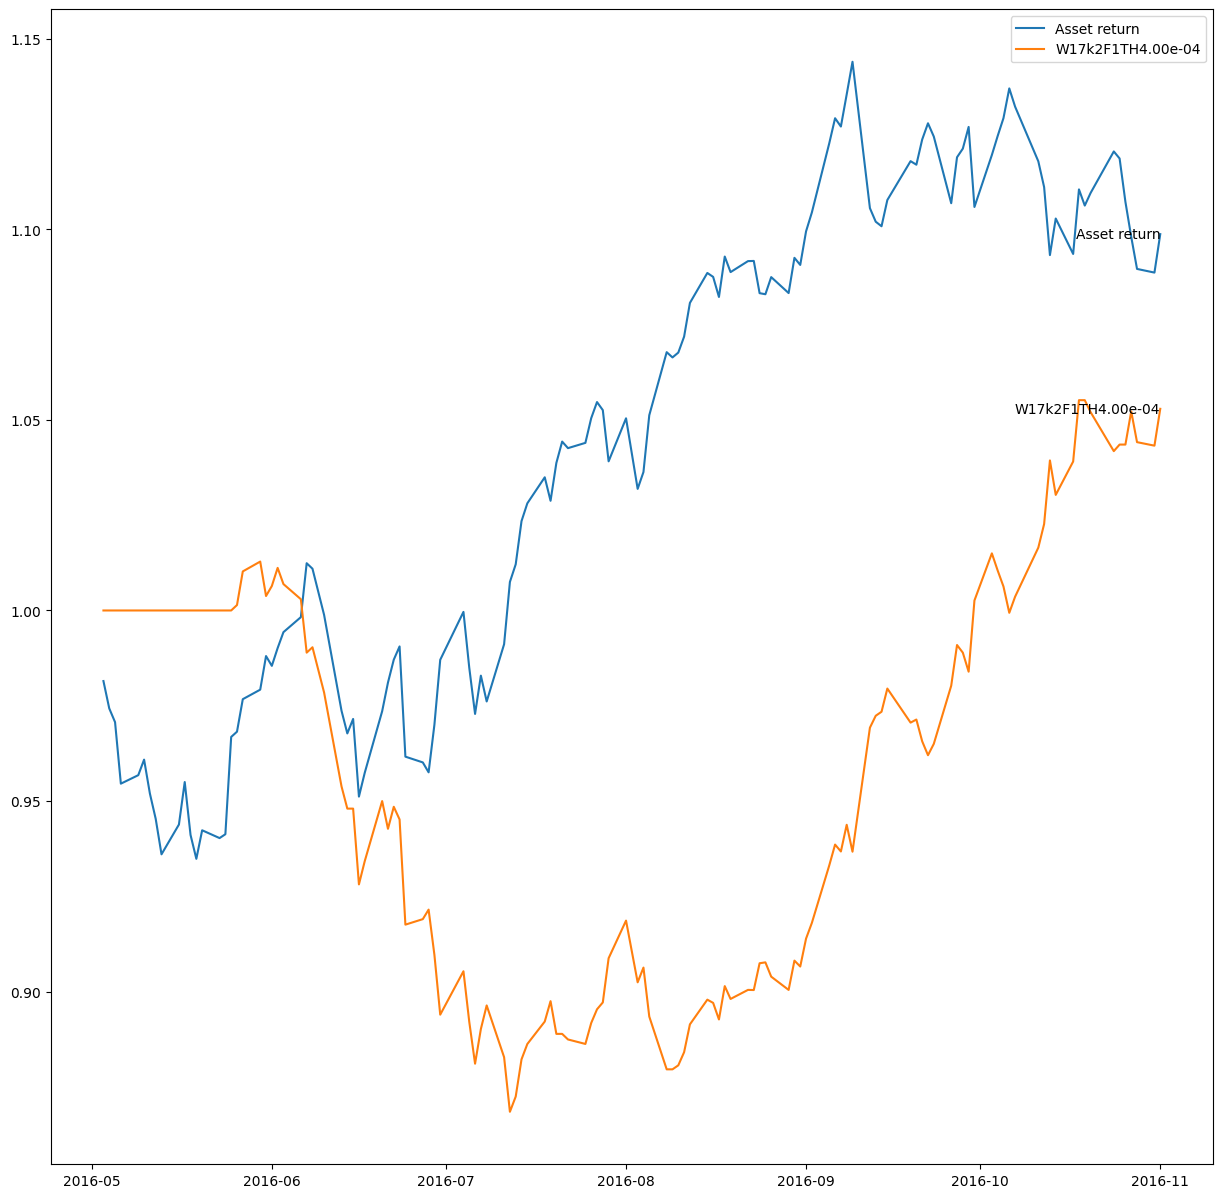

2016-11-01 2017-05-01
17 2 1 0.0004


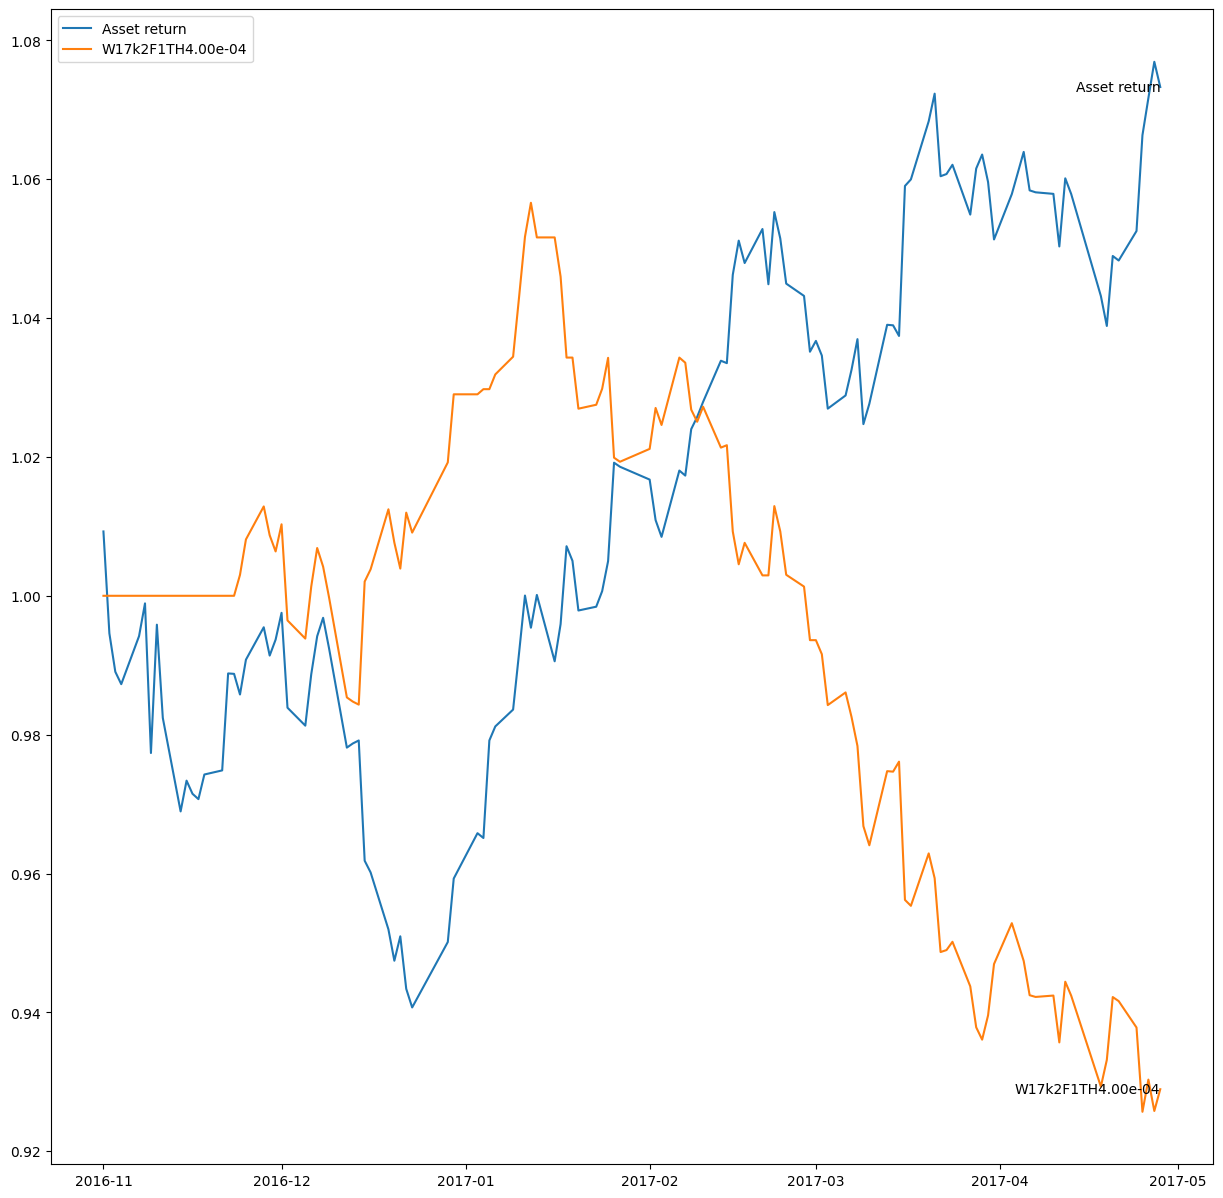

2017-05-01 2017-11-01
17 2 1 0.0004


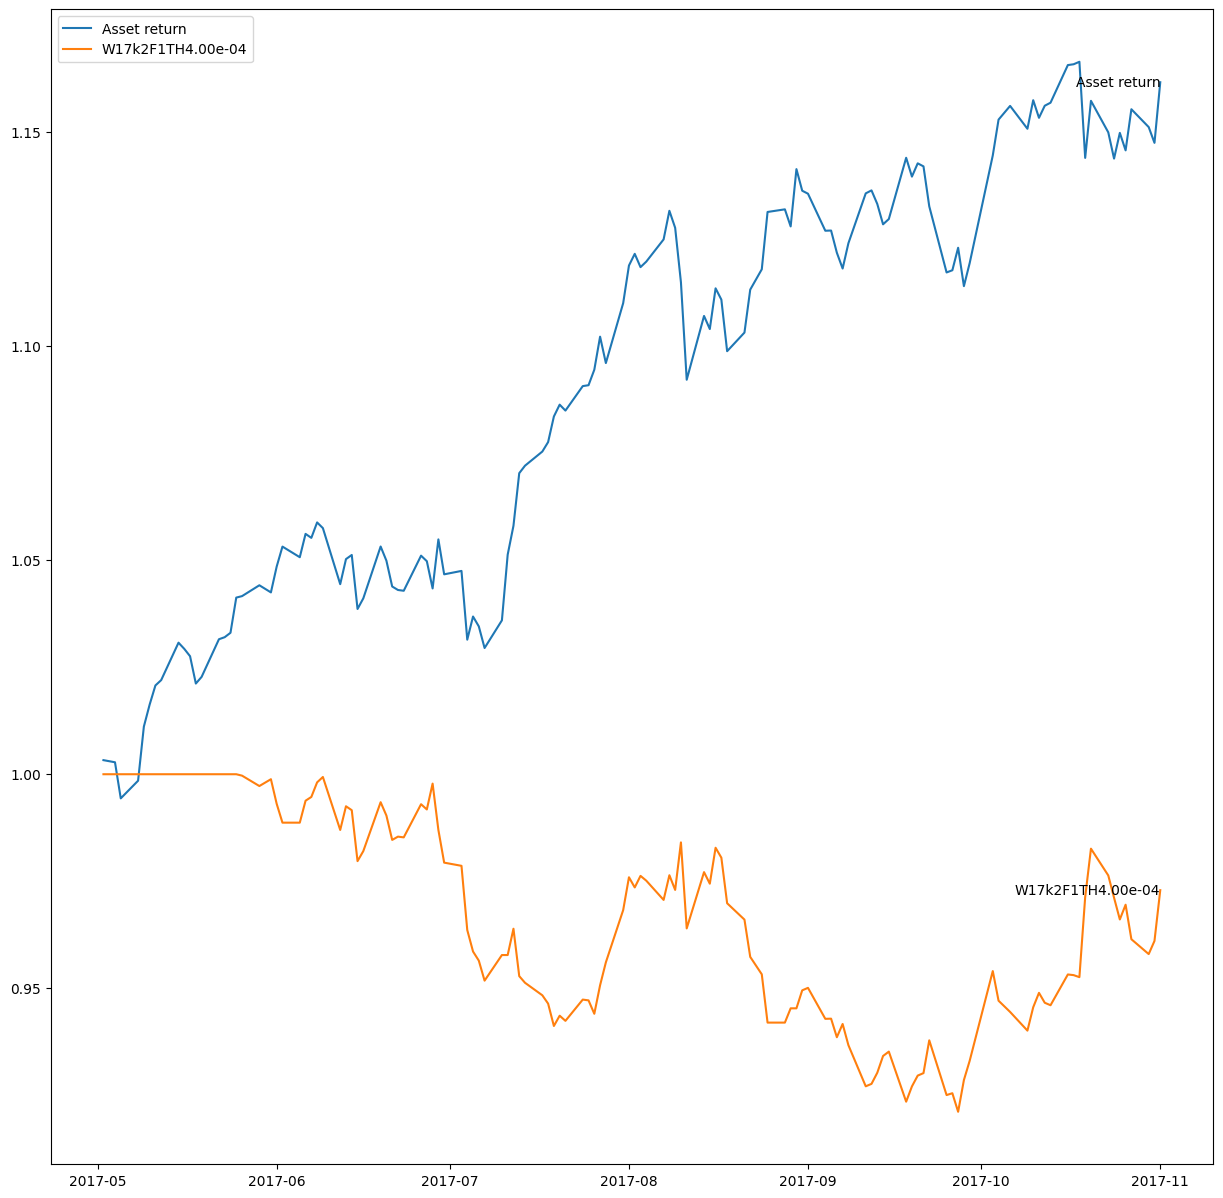

2017-11-01 2018-05-01
17 2 1 0.0004


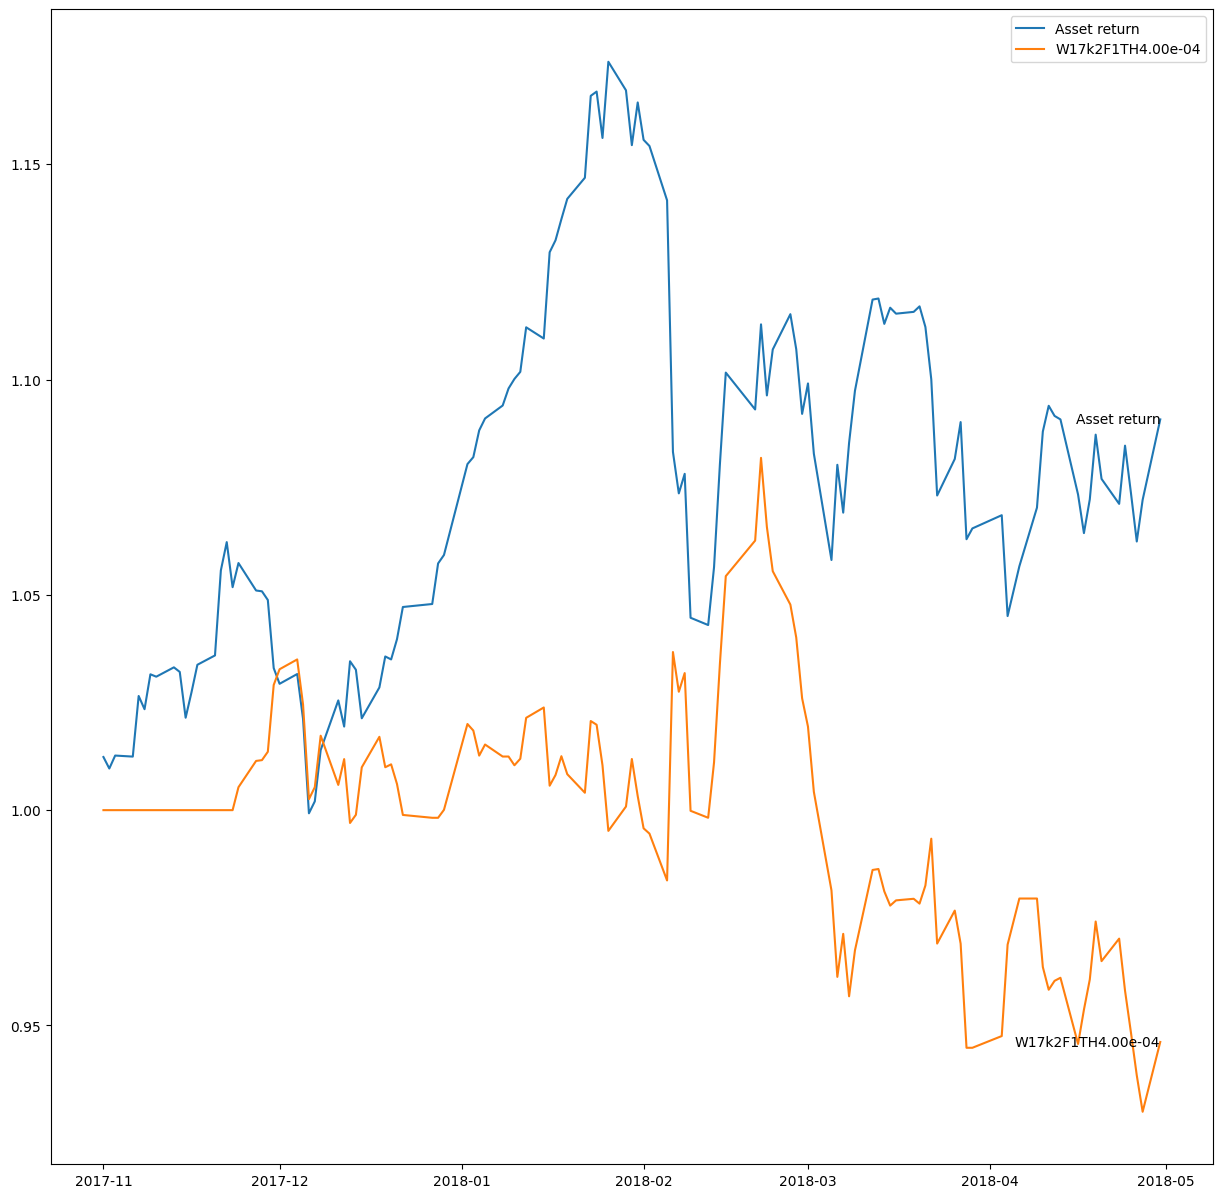

2018-05-01 2018-11-01
17 2 1 0.0004


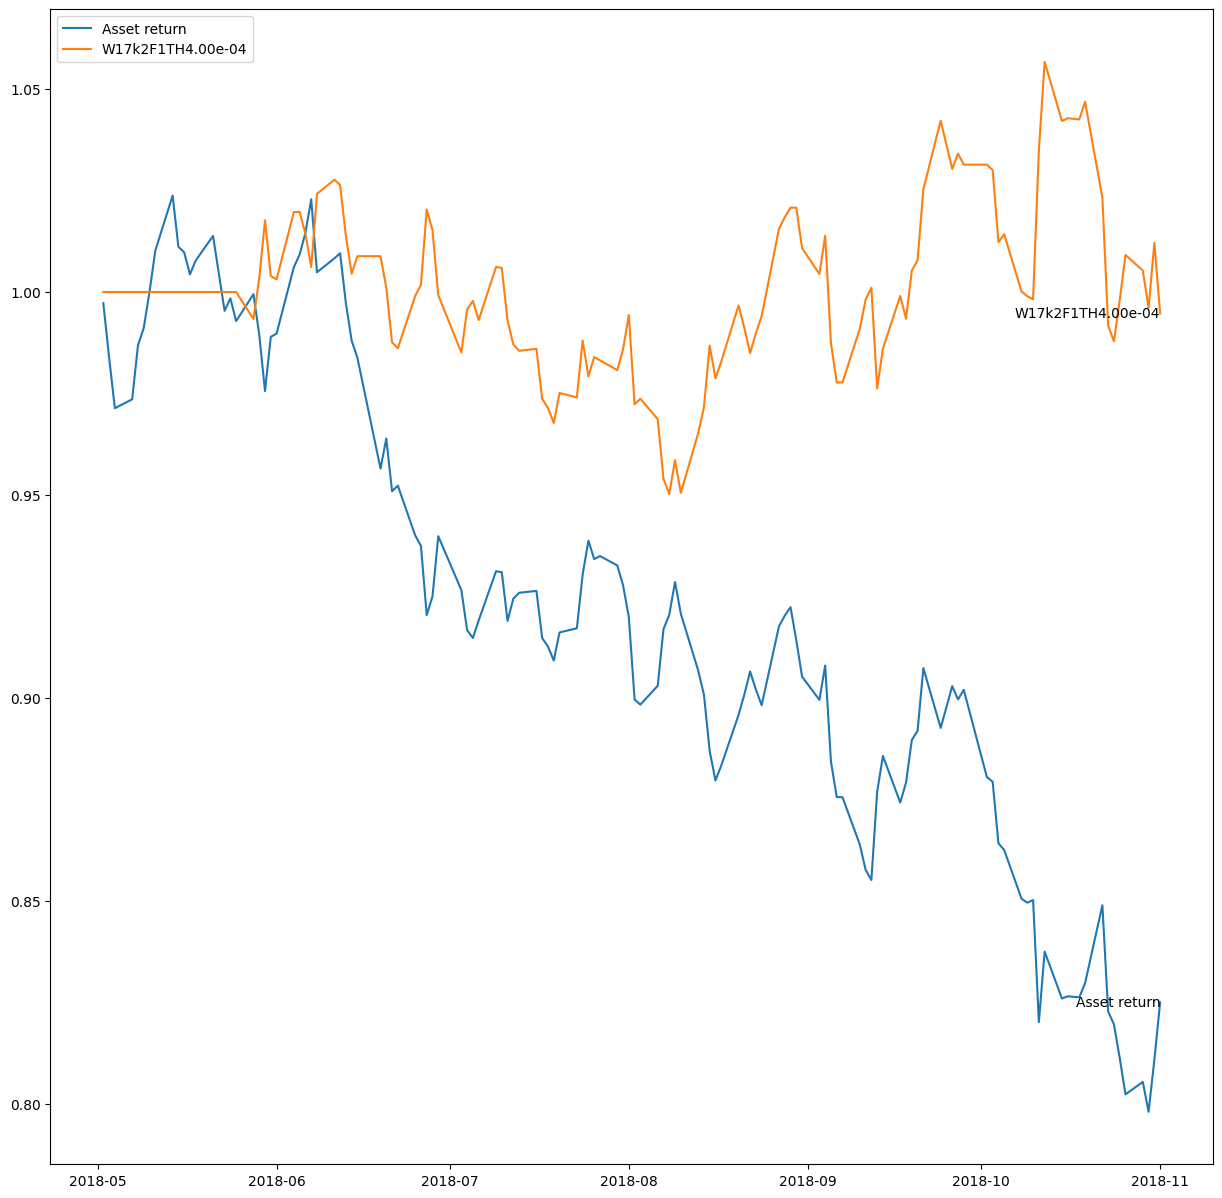

2018-11-01 2019-05-01
17 2 1 0.0004


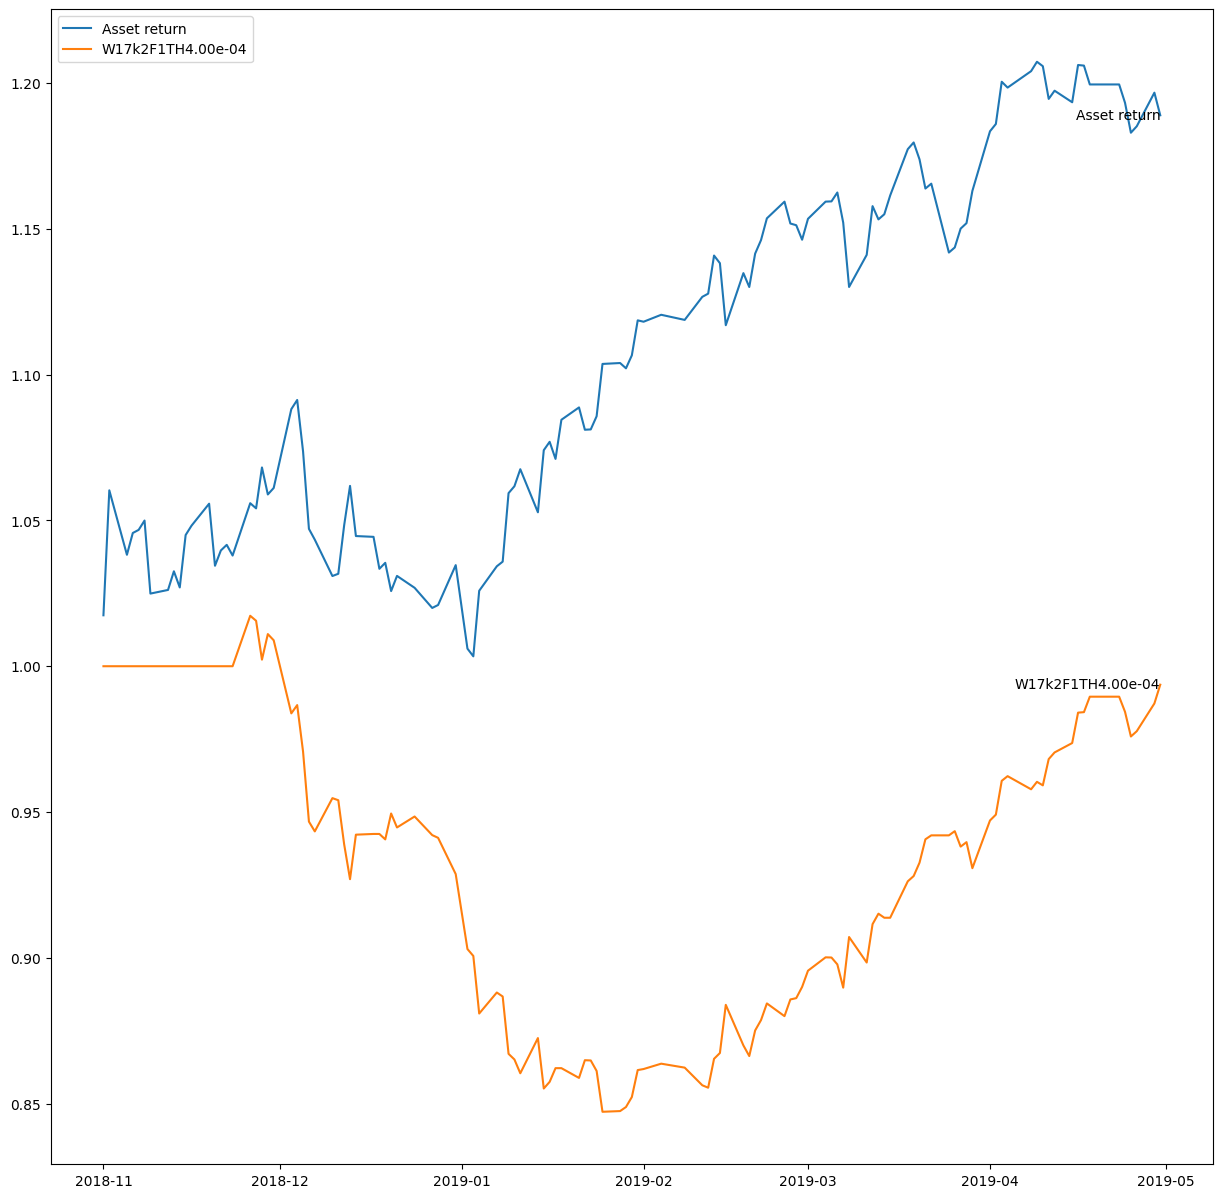

2019-05-01 2019-11-01
17 2 1 0.0004


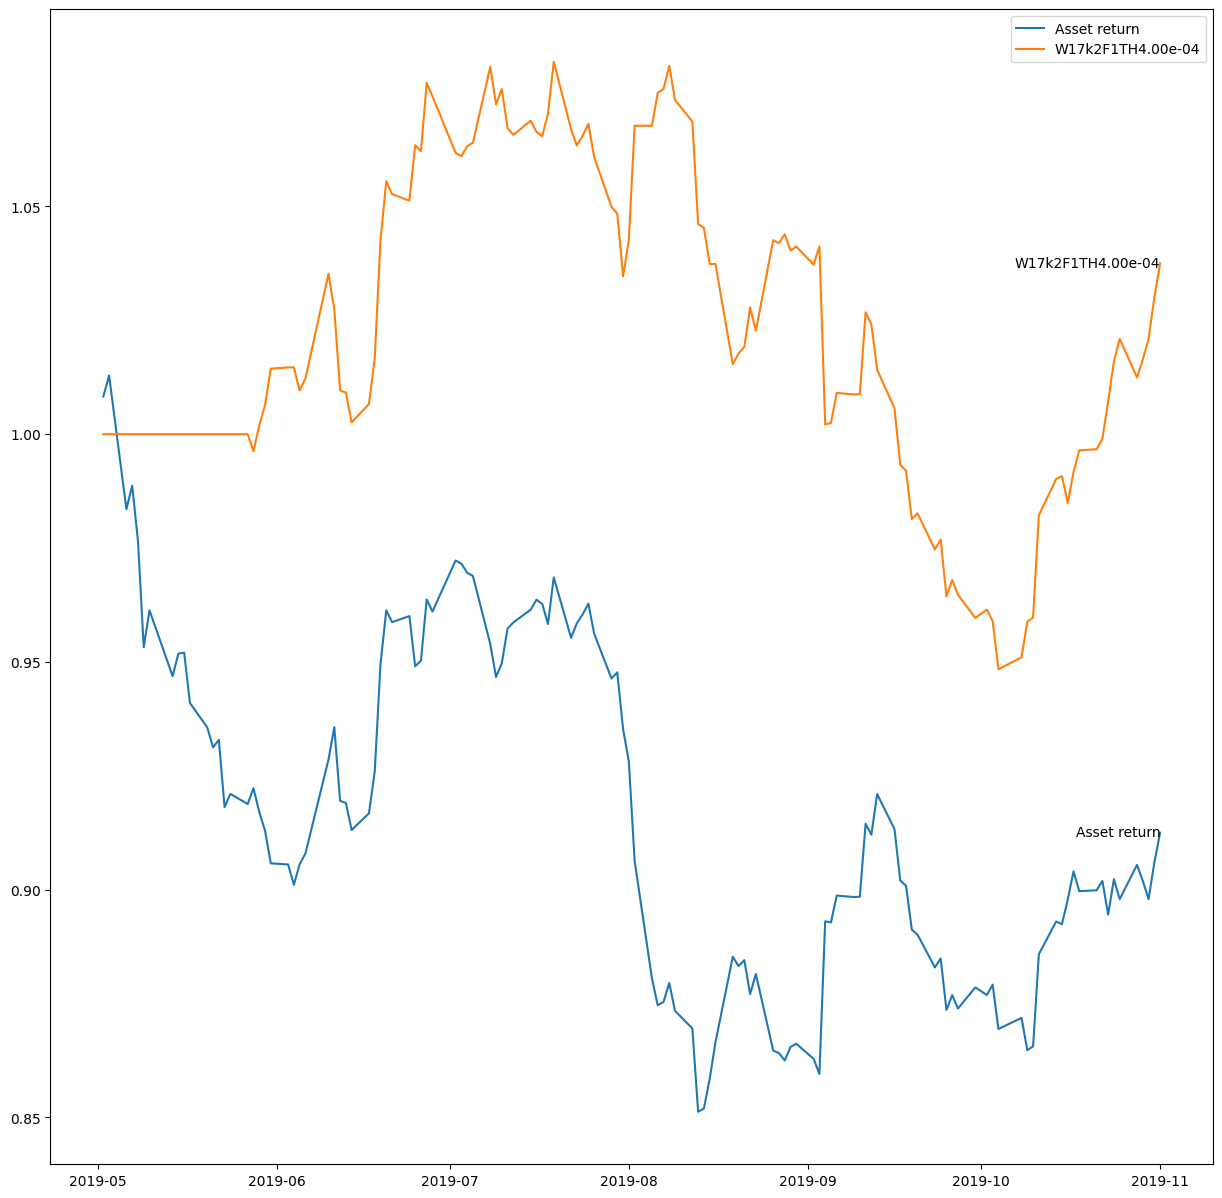

2019-11-01 2020-05-01
17 2 1 0.0004


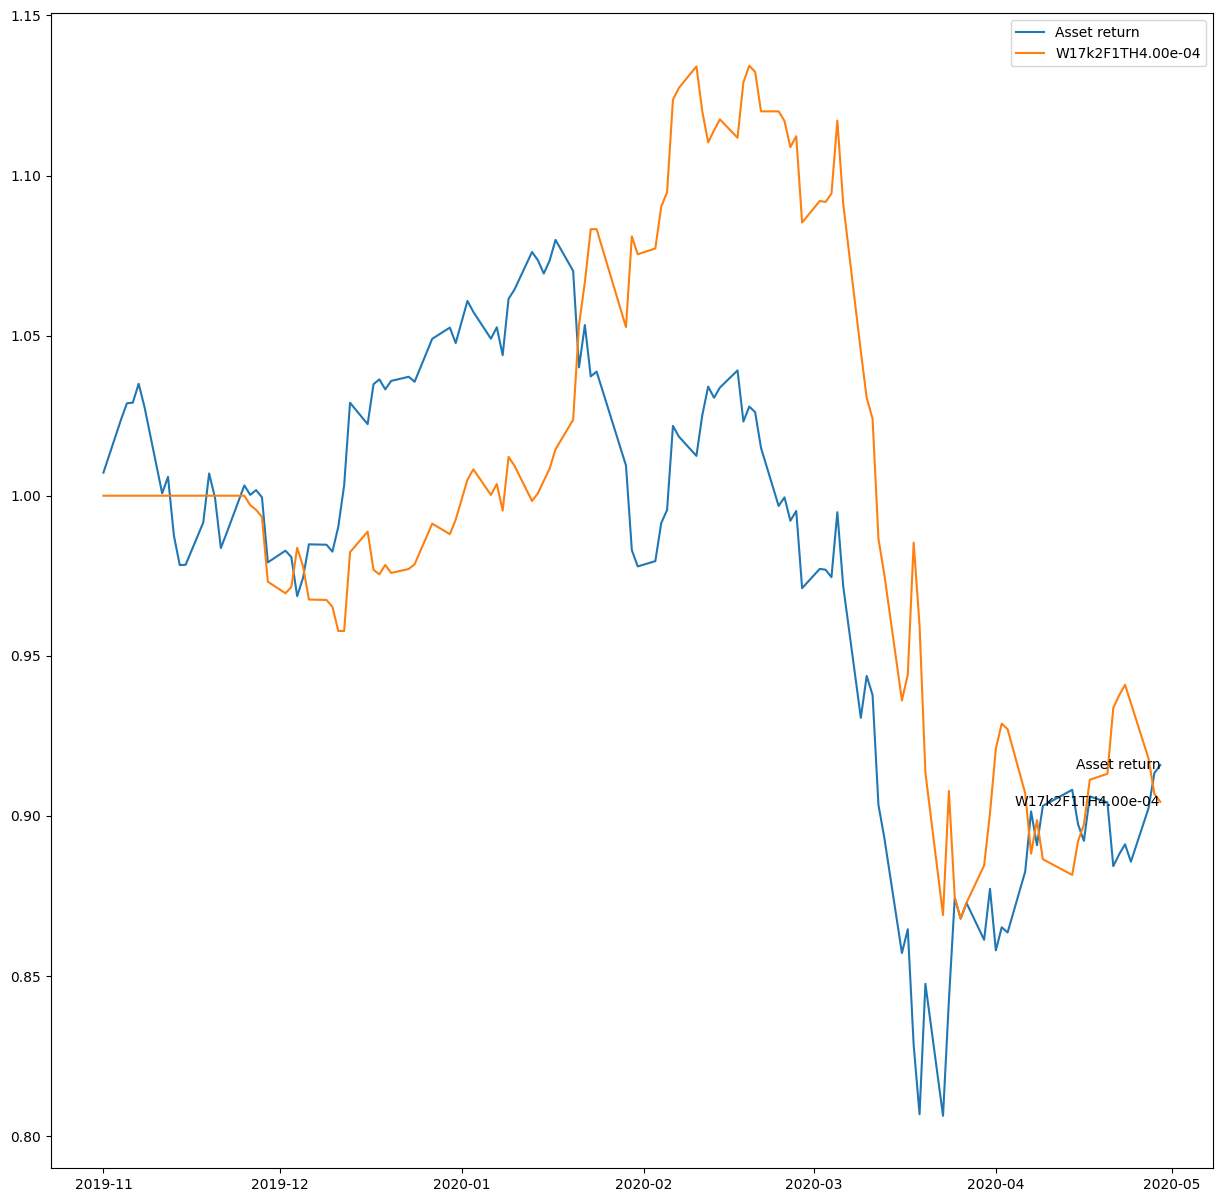

2020-05-01 2020-11-01
17 2 1 0.0004


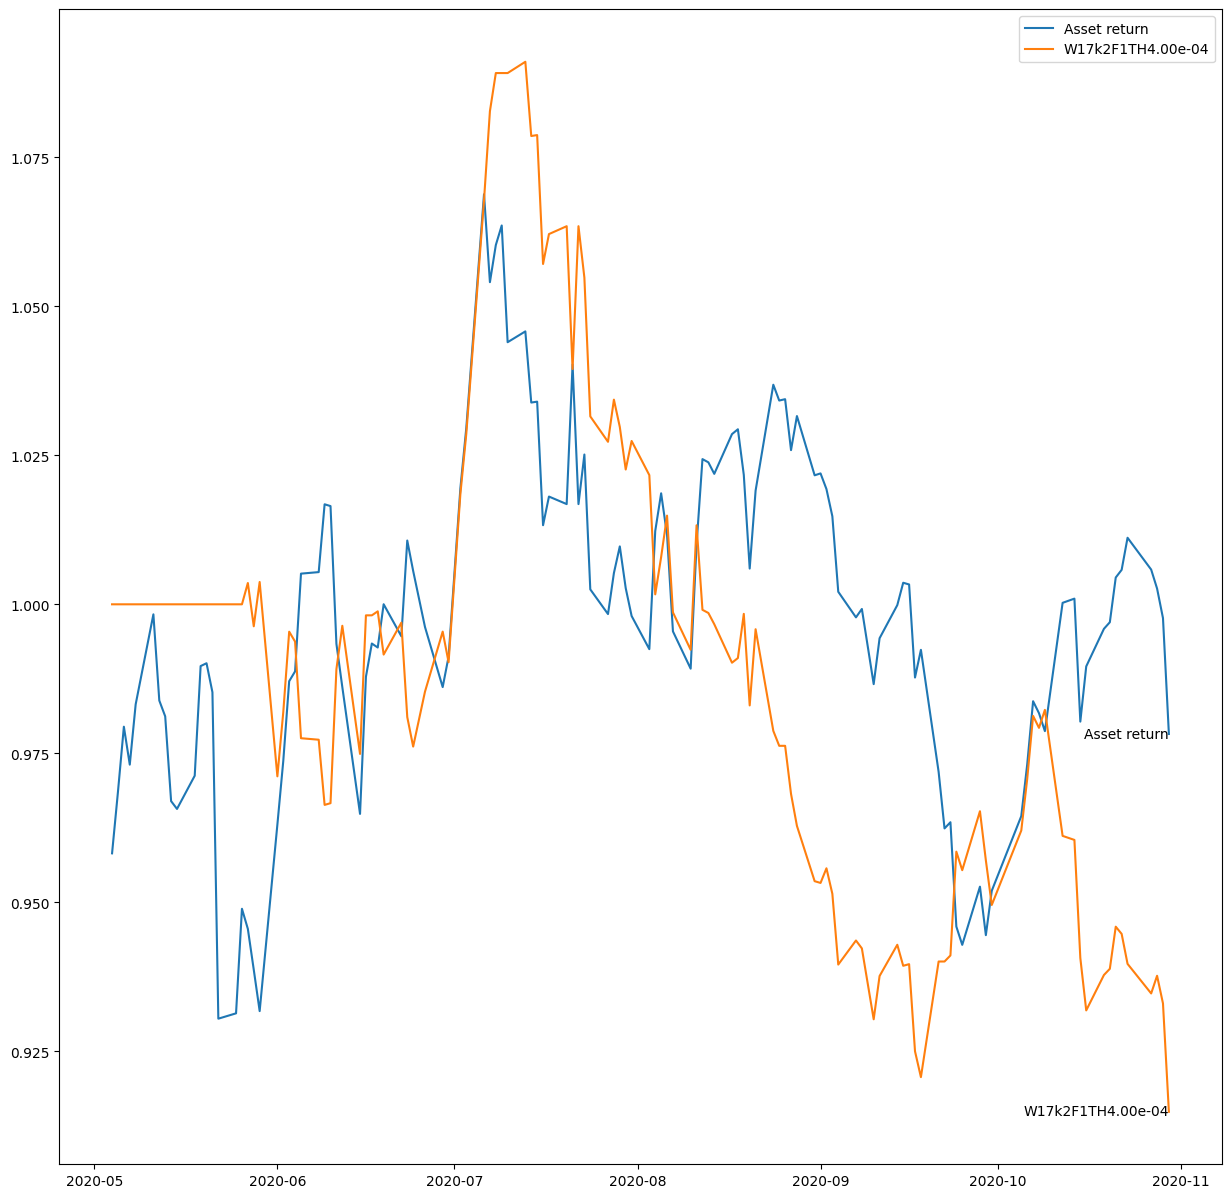

2020-11-01 2021-05-01
17 2 1 0.0004


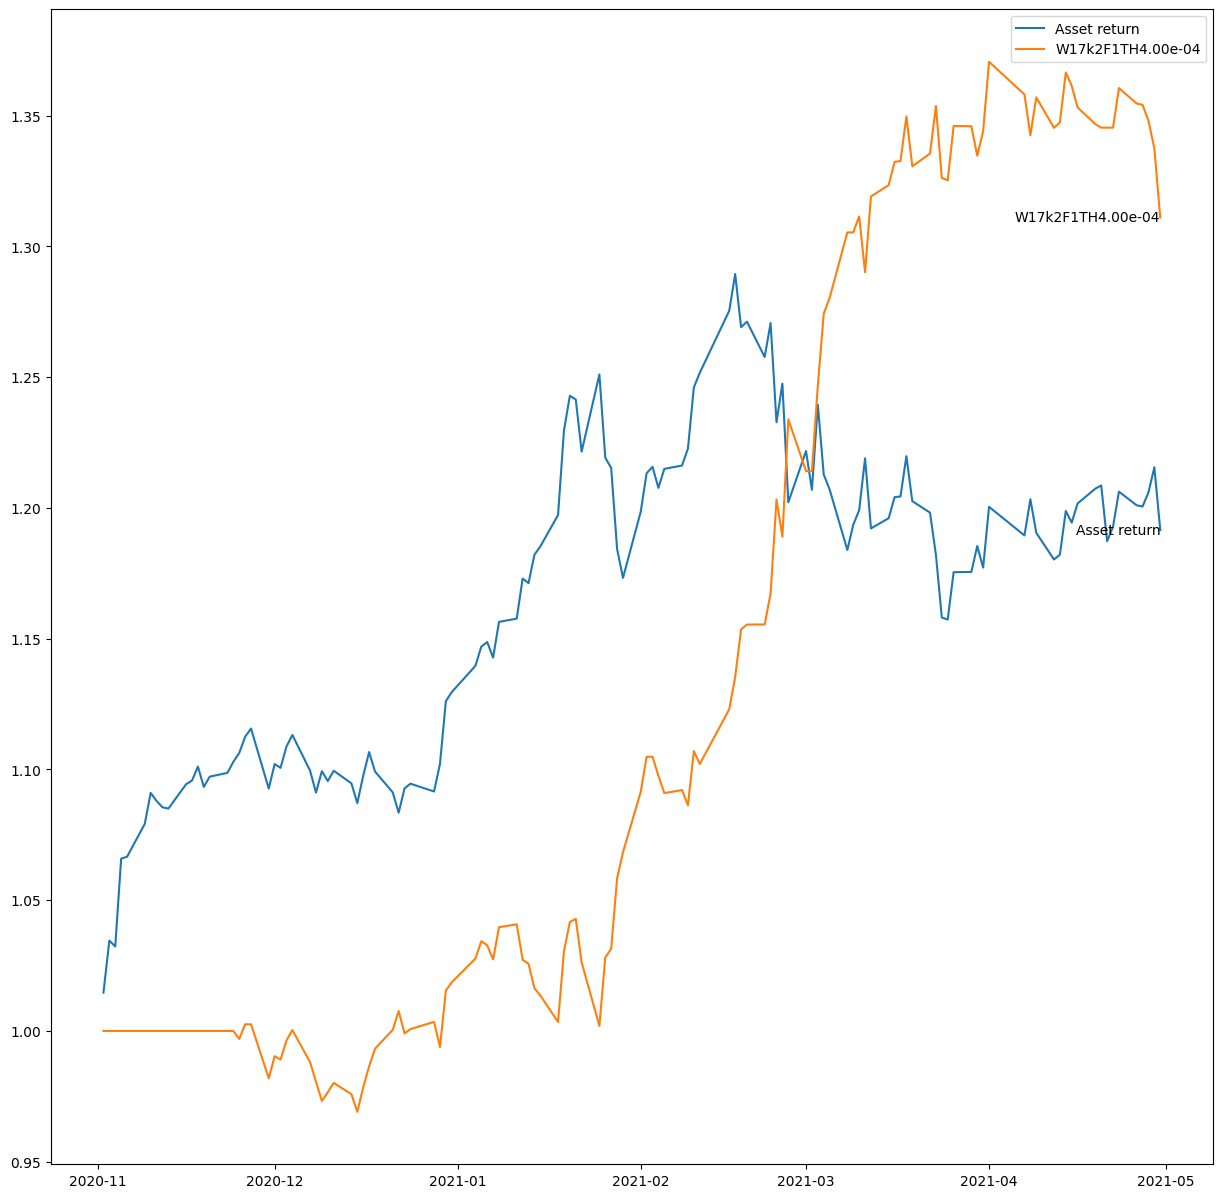

2021-05-01 2021-11-01
17 2 1 0.0004


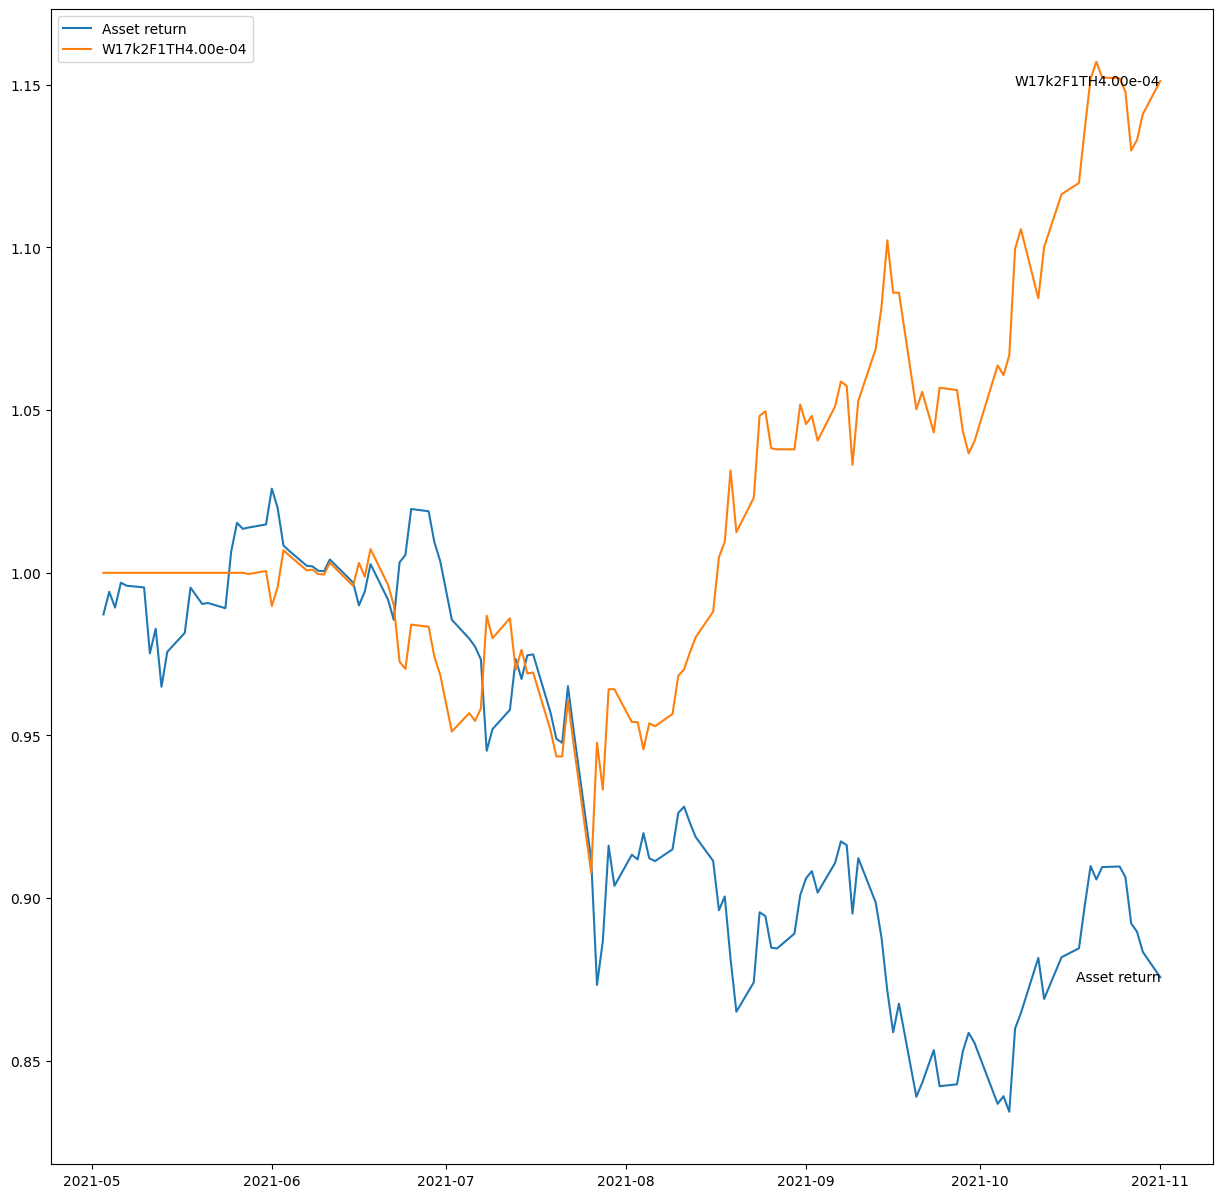

2021-11-01 2022-05-01
17 2 1 0.0004


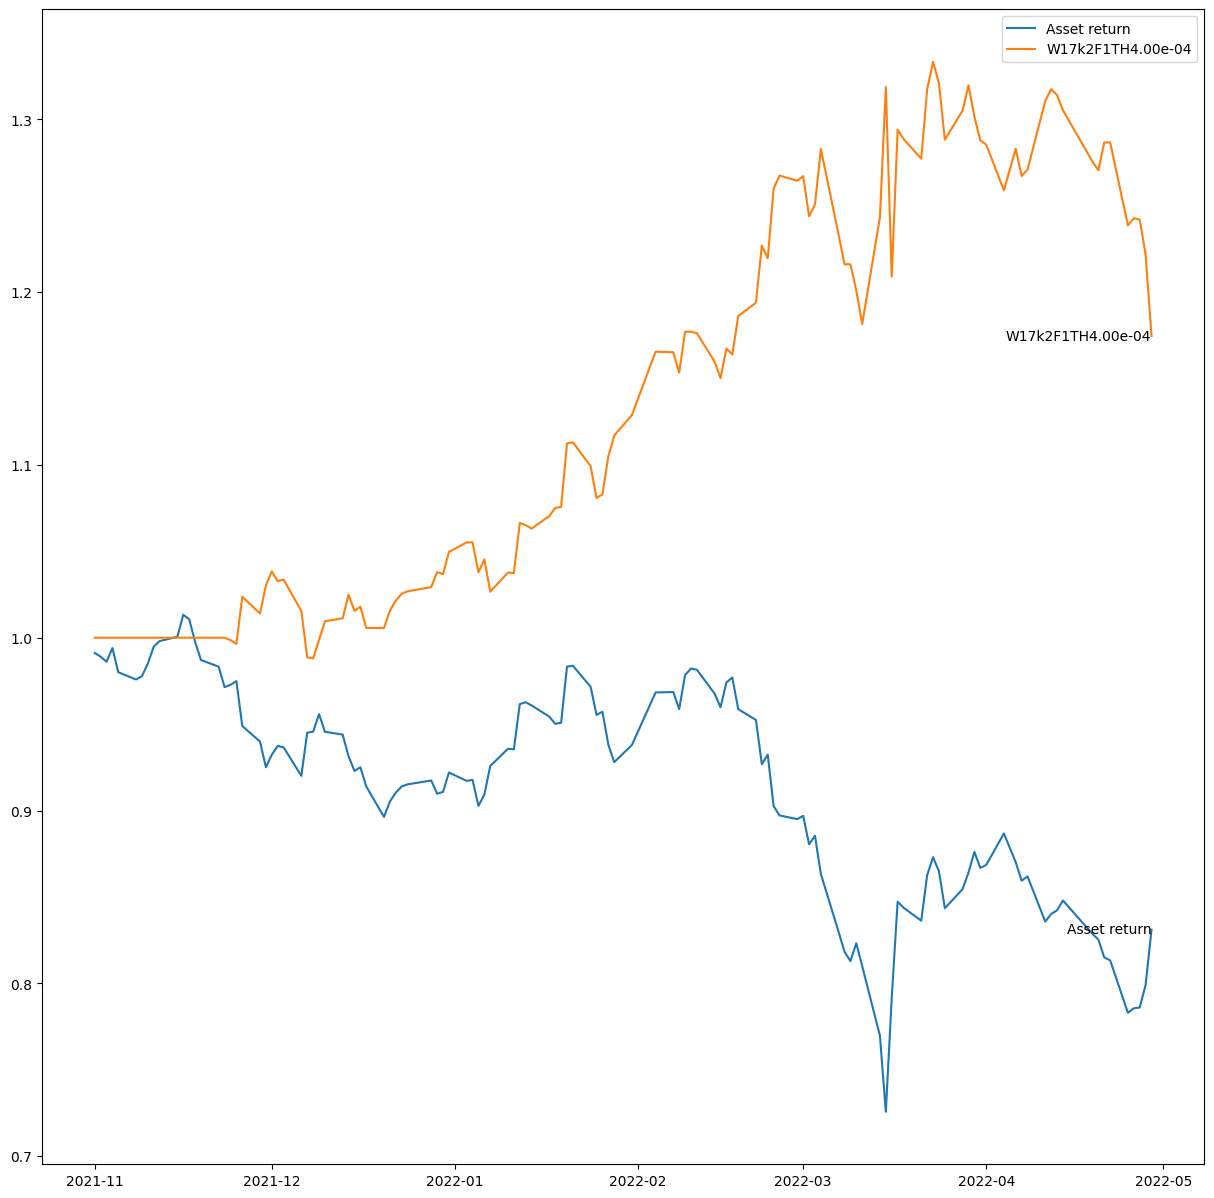

2022-05-01 2022-11-01
17 2 1 0.0004


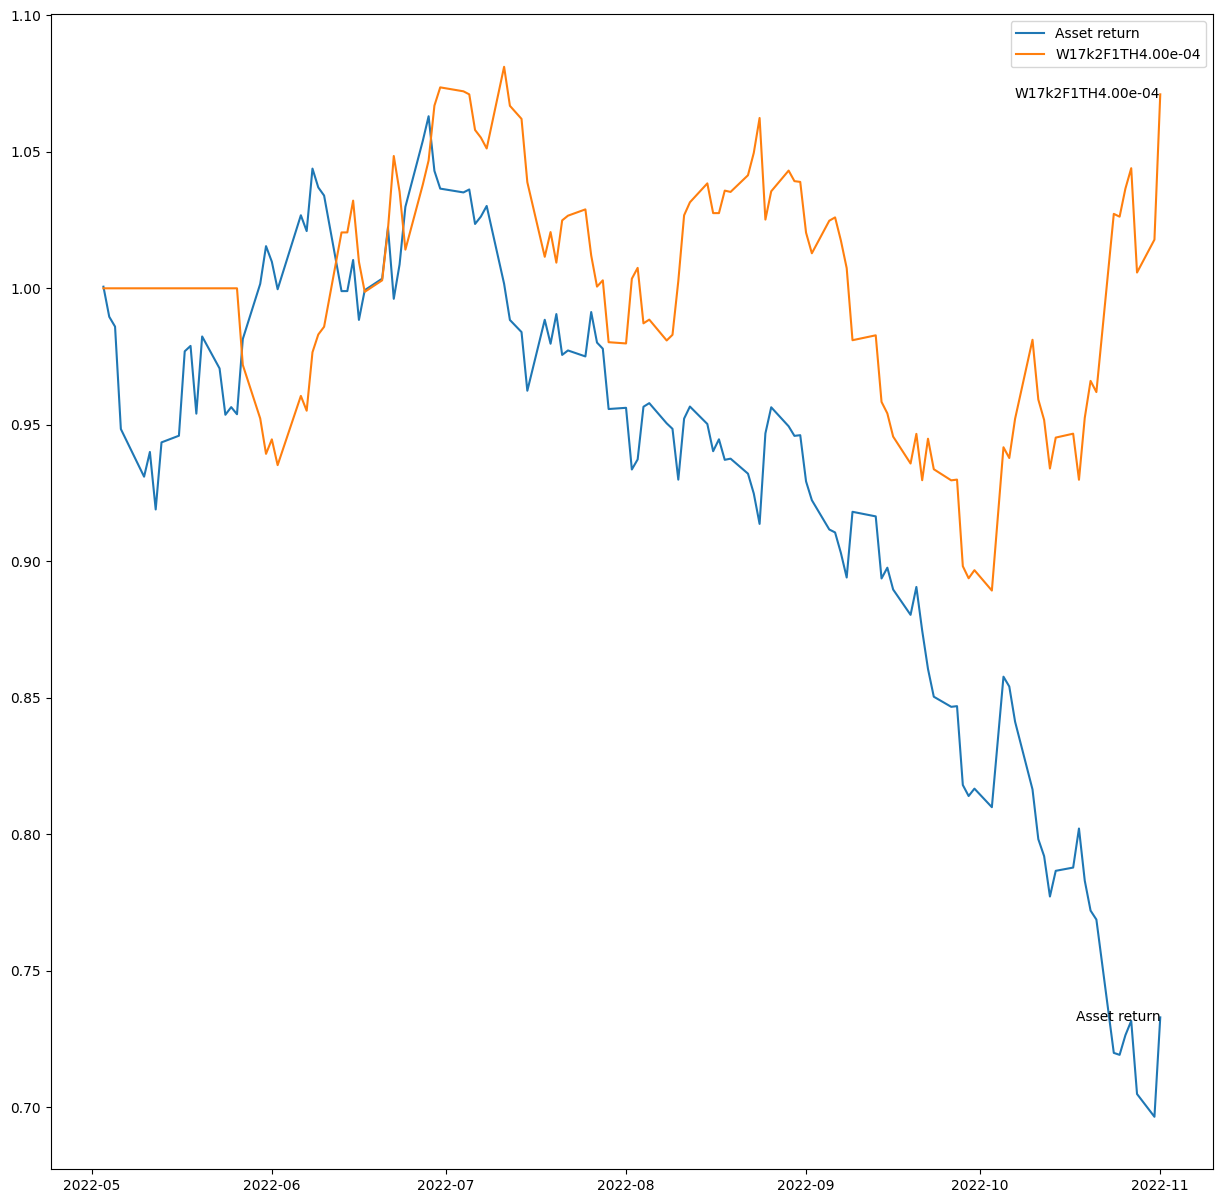

2022-11-01 2023-05-01
17 2 1 0.0004


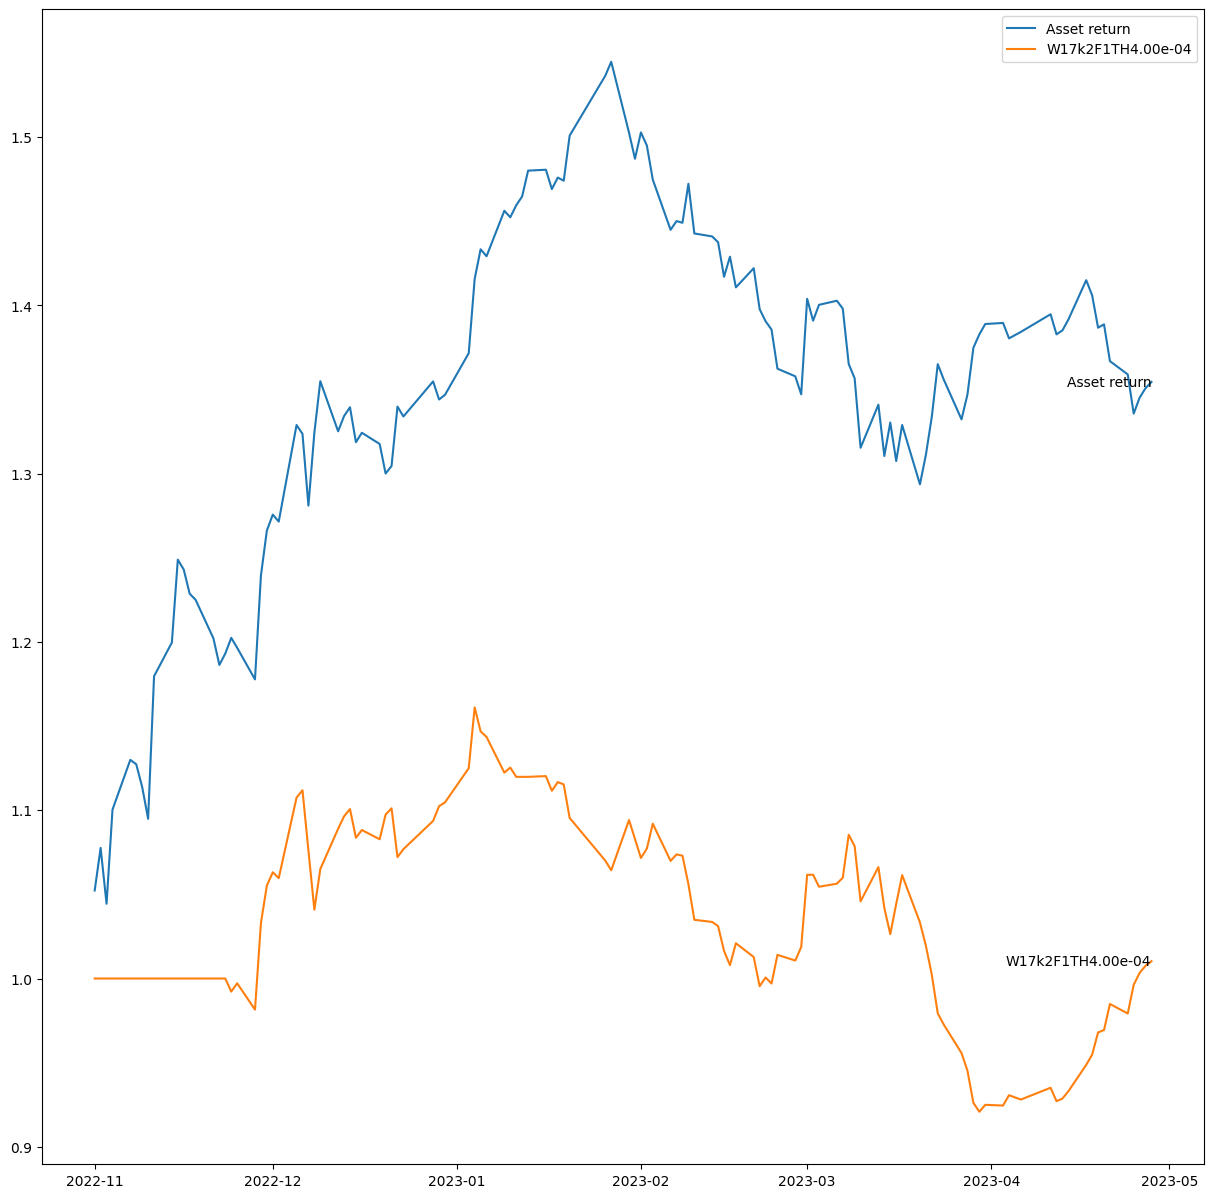

2023-05-01 2023-11-01
17 2 1 0.0004


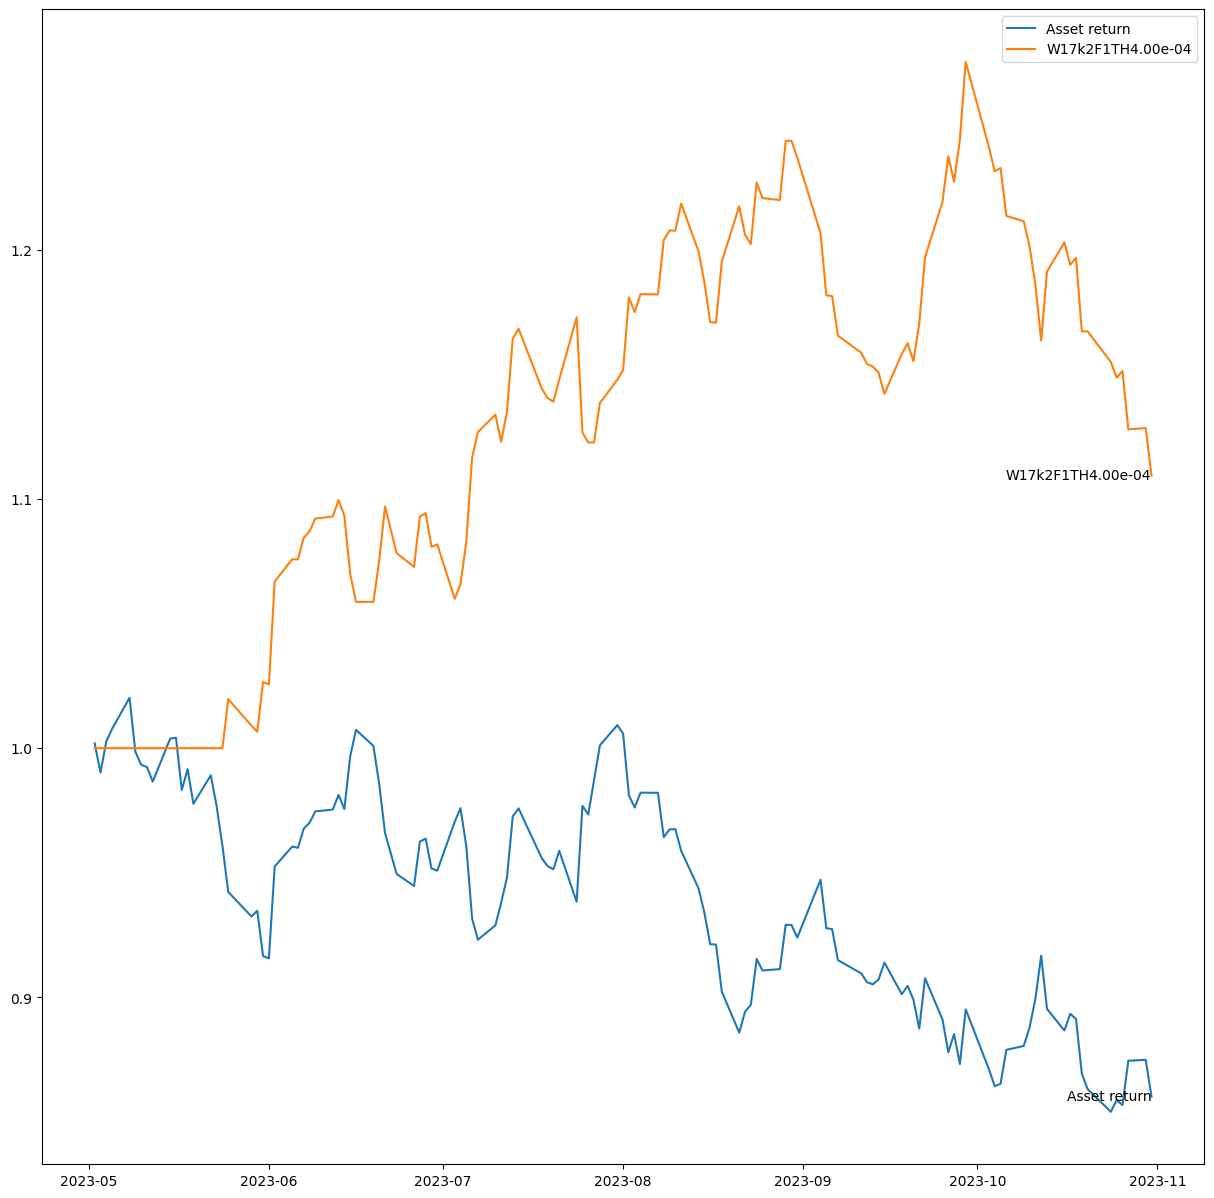

CAGR%  Sharpe Ratio  Sortino Ratio  Max Drawdown%  \
Asset_0-6m      -9.148209     -0.599477      -0.806626     -11.882541   
DTW_0-6m        16.068749      1.176425       1.815015      -7.636689   
Asset_6-12m     17.605214      1.295559       1.941514      -9.546625   
DTW_6-12m       -7.987827     -0.670856      -0.893728     -11.684558   
Asset_12-18m    38.538533      2.212205       3.717001      -6.329387   
DTW_12-18m      22.216128      1.430453       2.236797      -5.941618   
Asset_18-24m   -35.785512     -1.699682      -2.218408     -27.232913   
DTW_18-24m      -8.334388     -0.248423      -0.350075     -21.821537   
Asset_24-30m   -13.656399     -0.455067      -0.640989     -20.534738   
DTW_24-30m       5.640253      0.374648       0.546314     -11.099438   
Asset_30-36m    20.783959      1.508758       2.091874      -6.047476   
DTW_30-36m      10.892536      0.781391       1.111961     -14.252081   
Asset_36-42m    15.605135      1.144774       1.665330      -6.792698   
DTW_36-42m     -14.029337     -1.544313      -1.985034     -12.390856   
Asset_42-48m    34.831626      2.664903       4.181846      -3.487358   
DTW_42-48m      -5.328683     -0.468960      -0.664171      -7.885003   
Asset_48-54m    19.258054      0.927683       1.247952     -11.143382   
DTW_48-54m     -10.614499     -0.548060      -0.794669     -14.036756   
Asset_54-60m   -31.871104     -1.973261      -2.484269     -22.052354   
DTW_54-60m      -1.050405      0.020876       0.029789      -7.533599   
Asset_60-66m    42.036663      1.996305       3.096184      -8.055923   
DTW_60-66m      -1.280351     -0.023075      -0.030283     -16.719806   
Asset_66-72m   -16.690724     -1.148909      -1.562552     -15.957455   
DTW_66-72m       7.618506      0.595421       0.858924     -12.330180   
Asset_72-78m   -16.319071     -0.638105      -0.846147     -25.331025   
DTW_72-78m     -18.433853     -0.730893      -0.949700     -23.477965   
Asset_78-84m    -4.386343      0.307028       0.435016     -11.783748   
DTW_78-84m     -16.595861     -0.944386      -1.314390     -16.148444   
Asset_84-90m    42.952343      1.803088       2.625003     -10.247181   
DTW_84-90m      73.702407      3.211357       5.972598      -4.347358   
Asset_90-96m   -23.371210     -1.096450      -1.415916     -18.669437   
DTW_90-96m      32.608884      1.573680       2.453309      -9.877379   
Asset_96-102m  -31.436037     -1.061156      -1.567323     -28.384389   
DTW_96-102m     38.865701      1.277567       1.961019     -11.895385   
Asset_102-108m -46.385357     -2.040993      -2.755745     -34.488431   
DTW_102-108m    14.763607      0.646456       1.050158     -17.751835   
Asset_108-114m  86.322744      1.971024       3.629275     -16.255479   
DTW_108-114m     2.128797      0.207614       0.315808     -20.699503   
Asset_114-120m -26.073977     -1.292102      -1.789177     -16.285634   
DTW_114-120m    23.148689      1.118226       1.724656     -13.019482   

                Max Drawdown$  Max Drawdown (Days)  \
Asset_0-6m      -12308.649439                  148   
DTW_0-6m         -8079.821657                   95   
Asset_6-12m     -10919.910386                   57   
DTW_6-12m       -12037.065844                   63   
Asset_12-18m     -6359.433180                   64   
DTW_12-18m       -6460.167551                   59   
Asset_18-24m    -27346.034073                  156   
DTW_18-24m      -21821.537404                  103   
Asset_24-30m    -20909.814781                  176   
DTW_24-30m      -12672.124340                   43   
Asset_30-36m     -6122.453142                   50   
DTW_30-36m      -14434.947535                  125   
Asset_36-42m     -6855.644853                   85   
DTW_36-42m      -13092.260466                  105   
Asset_42-48m     -3946.354769                   34   
DTW_42-48m       -7885.002511                  159   
Asset_48-54m    -13079.906976                   91   
DTW_48-54m      -15185.074564                   67   


In [20]:
DTW_rolling_6m_results = pd.DataFrame()
for i in range(len(rolling_6m_DTW)-1):

    print (rolling_6m_DTW[i], rolling_6m_DTW[i+1])

    rolling_deploy_6m =\
        DTW_kNN_tuning(target.iloc[:, -2:],
                       [nDTW_], [kNN_], [subsequent_days_],
                       [start, test, rolling_6m_DTW[i], rolling_6m_DTW[i+1]],
                       [threshold_], 1e5)
    
    rolling_deploy_6m.index = [f'Asset_{6*i}-{6*(i+1)}m', f'DTW_{6*i}-{6*(i+1)}m']
    DTW_rolling_6m_results = pd.concat([DTW_rolling_6m_results, rolling_deploy_6m])
DTW_rolling_6m_results    

> # DTW with kNN to match with `UP-TRENDING DATA`
* LESS computational costly
* extended test window frame
* best result in test is performing in deployment, may be due to improved testing window frame length.
* best tuned parameter results:
1. nDTW=15, window frame to calculate on `euclidean` distance of scaled time series data in DTW
2. kNN=1, number of nearest neighbours for predictions
3. subsequent_days=1, number of days to predict in current window 
4. threshold=0.001, threshold for filter out significant trading signals
* possible improvment:
1. fine tune on effectiveness of `TRENDING DATA`
2. threshold for `euclidean` distance to be explored
3. further construction of `PAST DATA` to include `UP TREND`, `DOWN TREND`, and `CONSOLIDATION BOX`
4. further fine tuning on parameters

In [21]:
def DTW_kNN_up(Y,
               nDTW, kNN, subsequent_days,
               time_tags,
               starting_amt=1e5, threshold=0):
    Y_train, Y_test =\
    (
    Y[time_tags[0]:time_tags[1]], 
    Y[time_tags[-2]:time_tags[-1]]
    )
    ts_index = Y_test.index

    ts_past = Y_train.iloc[:,-1].values
   
    ts_current = Y_test.iloc[:,-1].values   

    DTW_kNN_signal = pd.DataFrame(Y_test.iloc[:,0], index = ts_index)
#     DTW_kNN_signal.columns = ['return']
    backtest_return = DTW_kNN_signal[['log return']]
    backtest_return =\
        backtest_return.rename(columns={'log return': 'Asset return'})    
        
    DTW_results = []
    subsequent_moves = []
    DTW_predicts = []
    
    for i in range(nDTW, len(ts_current)):
        window_end = i
        window_start = i - nDTW

        # Extract the short time series window
        current_window = ts_current[window_start:window_end]        
        min_distances = [(float('inf'), -1) for _ in range(kNN)]

        for start_index in range(len(ts_past) - subsequent_days):
            past_window = ts_past[start_index:start_index + nDTW]
            distance = dtw_distance(current_window, past_window)
            for j, (min_distance, _) in enumerate(min_distances):
                if distance < min_distance:
                    min_distances[j] = (distance, start_index)
                    break   
                    
                    
        subsequent_moves = []                    
        for k, (_, start_index) in enumerate(min_distances):
            
            subsequent_window =\
                ts_past[start_index + nDTW : start_index + nDTW + subsequent_days]
            subsequent_moves += [subsequent_window]        
        
        DTW_predicts += [[ts_index[i], subsequent_moves]]         
        DTW_results += [ts_index[i], min_distances]        

    col = f"DTW{nDTW}_kNN{kNN}"
    DTW_kNN_signal[col]=0
    for j in range(len(DTW_predicts)):
        temp_index = DTW_predicts[j][0]
        
        try:
            temp_position = np.sum(DTW_predicts[j][1])/(kNN*subsequent_days)
#             print("normal")
        except ValueError:
            temp_position = np.concatenate(DTW_predicts[j][1]).sum()
            print(DTW_predicts[j][0])
        except Exception as e:    
            temp_position = 0
            
#         temp_position = np.sum(DTW_predicts[j][1])/(kNN*subsequent_days)
        DTW_kNN_signal.loc[temp_index, col] =\
            np.where(abs(temp_position) >= threshold, np.sign(temp_position), 0)
        
    backtest_return[col] =\
        backtest_return["Asset return"]*DTW_kNN_signal[col]   
    
    
    plt.figure(figsize=[15,15])

    closing_amt = []
    for name in backtest_return.columns:
        plt.plot(np.exp(backtest_return[f"{name}"].cumsum()),
                 label = f"{name}")
        # Add labels on the plot
        final_factor =\
            np.exp(backtest_return[f"{name}"].cumsum()).iloc[-1]
        closing_amt += [final_factor * starting_amt]
        plt.text(backtest_return.index[-1],
                 final_factor, f"{name}", ha='right', va='center')
    plt.legend()
    plt.show()    
       
    backtest_return_performance =\
        cal_performance_metrics(backtest_return, starting_amt)

    
    signs = np.sign(backtest_return)

    # Count positive and negative values for each column
    positive_counts = (signs > 0).sum()
    negative_counts = (signs < 0).sum()

    # Combine positive and negative counts into a DataFrame
    Accuracy = pd.DataFrame({
        'Win': positive_counts,
        'Loss': negative_counts
    })
    Accuracy['Win%'] = Accuracy['Win']/Accuracy.sum(axis = 1)*100
    
    backtest_return_performance =\
        pd.concat([backtest_return_performance, Accuracy], axis = 1)       
    
    return backtest_return_performance

> #### Trial test for 3 months to see if using previous best tuned parameters with past `TRENDING DATA` could be profitable. The result is not as good. New set of fine tuning is thus needed.

2011-11-30 00:00:00
2011-12-05 00:00:00
2012-01-18 00:00:00


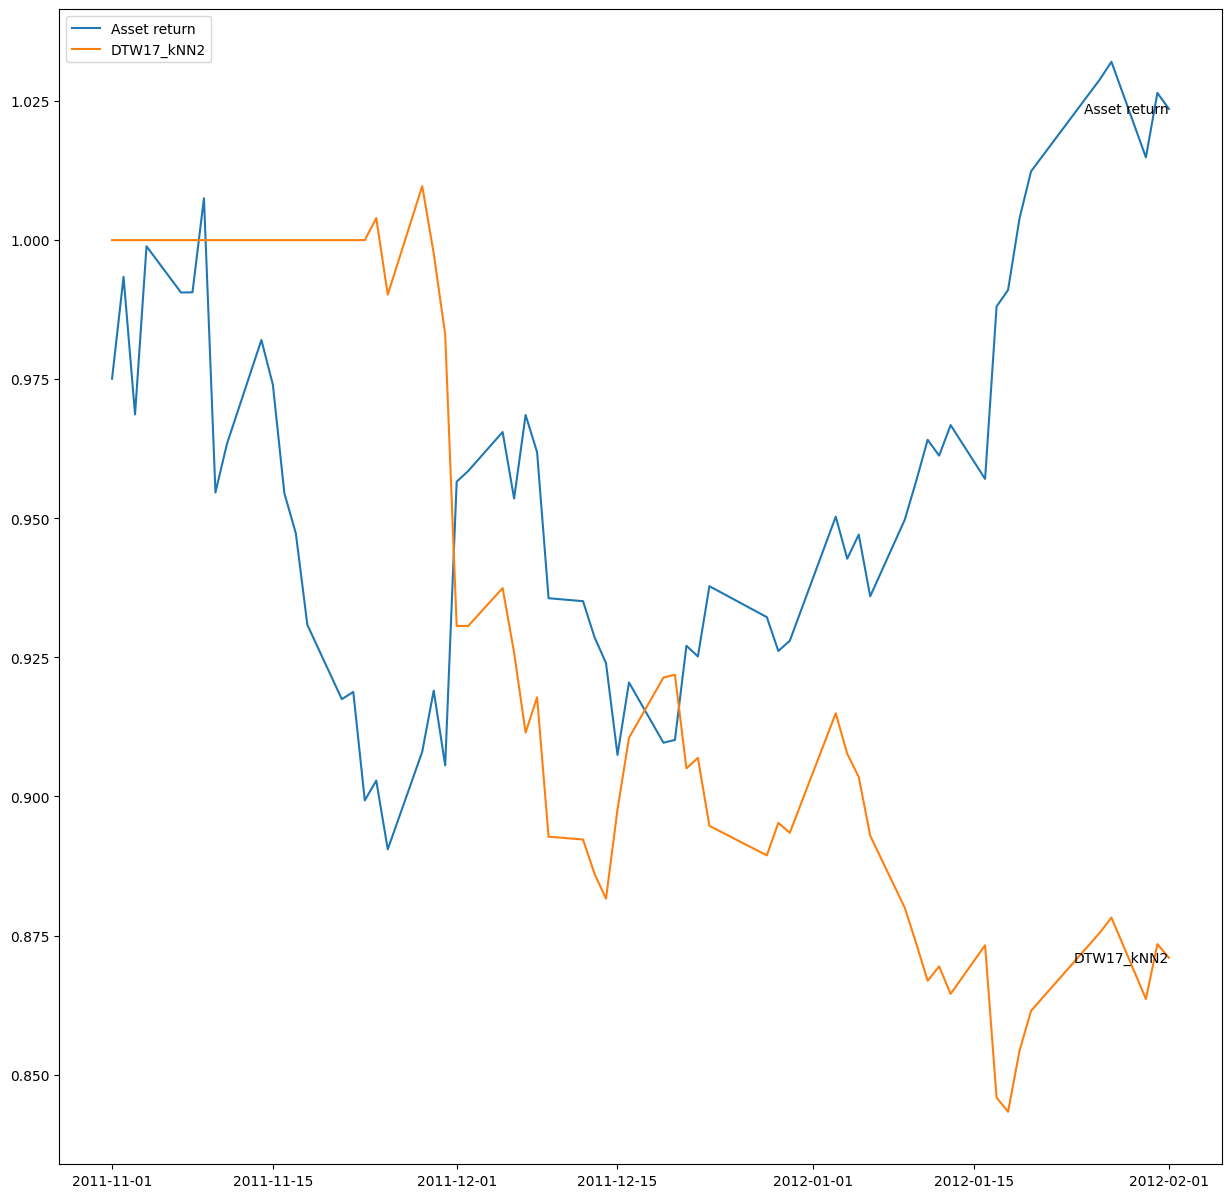

CAGR%  Sharpe Ratio  Sortino Ratio  Max Drawdown%  \
Asset return   9.689341      0.883068       1.339893     -11.616365   
DTW17_kNN2   -42.182797     -2.788329      -3.235926     -16.478341   

              Max Drawdown$  Max Drawdown (Days)  \
Asset return  -11703.823480                   71   
DTW17_kNN2    -16638.269693                   64   

              Multiples of Invested Capital  Win  Loss       Win%  
Asset return                       1.023584   32    29  52.459016  
DTW17_kNN2                         0.871014   18    25  41.860465

In [22]:
time_tags = ['2012-06-05', '2013-04-19', train1, test_test]


DTW_kNN_up_test =\
    DTW_kNN_up(target.iloc[:, -2:],
               nDTW_, kNN_, subsequent_days_,
               time_tags,
               starting_amt=1e5, threshold=0)


DTW_kNN_up_test

> #### 1st round of fine tuning on 3 months to look for rough range of best combinations
* W = 10
* K = [2,3]

5 1 1 0
5 2 1 0
5 3 1 0
10 1 1 0
10 2 1 0
10 3 1 0
15 1 1 0
15 2 1 0
15 3 1 0
20 1 1 0
20 2 1 0
20 3 1 0
25 1 1 0
25 2 1 0
25 3 1 0


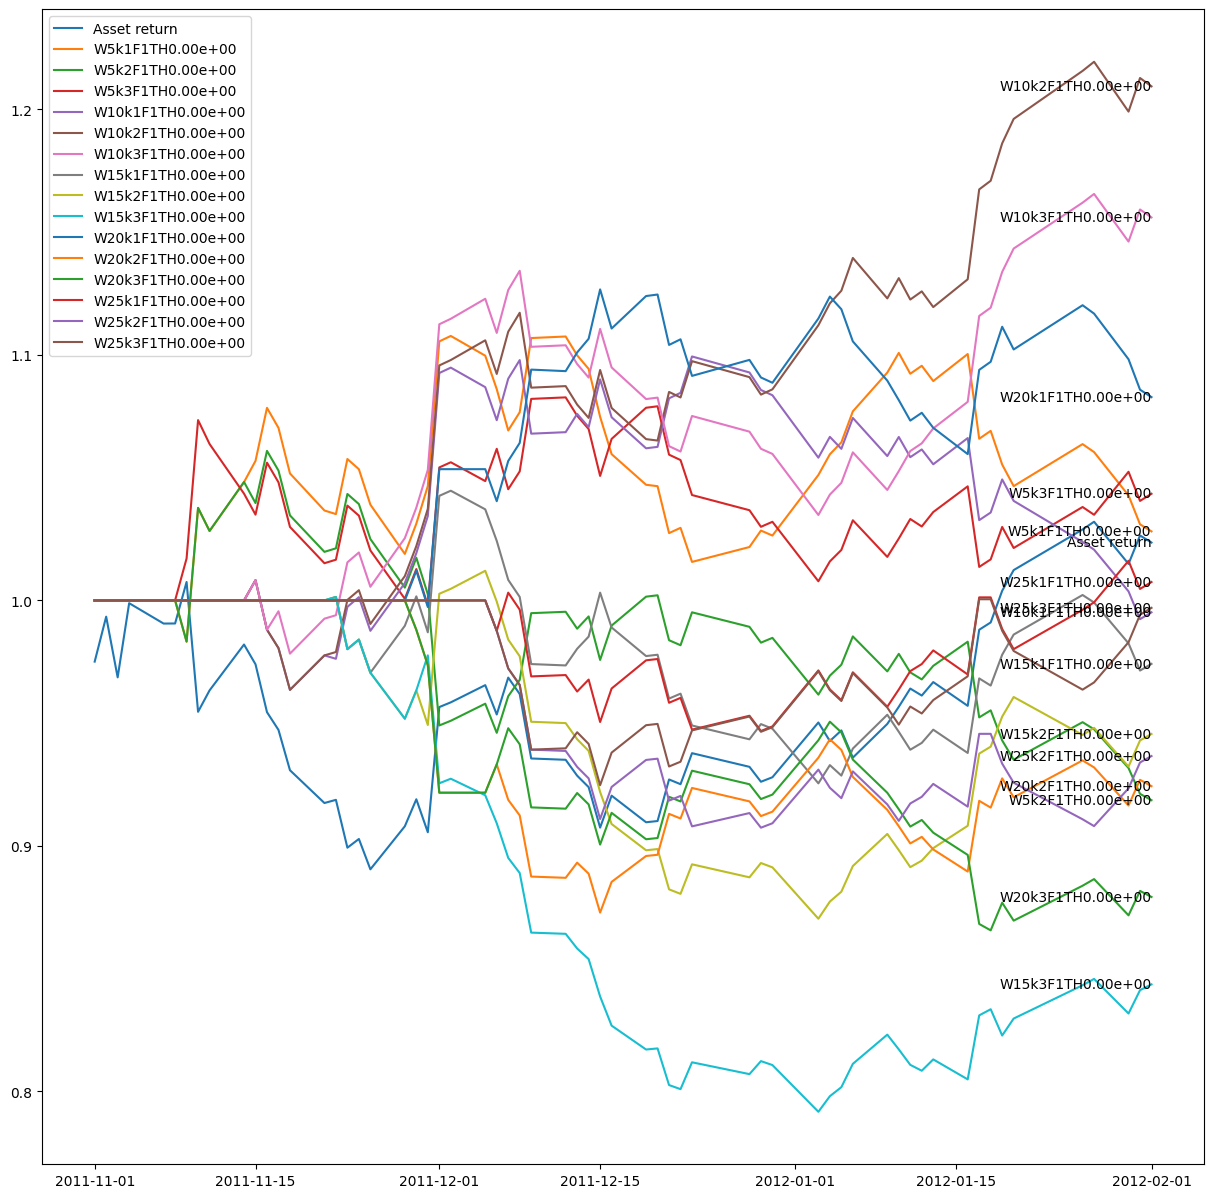

CAGR%  Sharpe Ratio  Sortino Ratio  Max Drawdown%  \
Asset return         9.689341      0.883068       1.339893     -11.616365   
W5k1F1TH0.00e+00    11.631534      0.575796       1.020287      -8.308287   
W5k2F1TH0.00e+00   -28.582833     -1.282029      -1.755576     -13.409828   
W5k3F1TH0.00e+00    18.386196      0.818645       1.424192      -7.030668   
W10k1F1TH0.00e+00   -1.905525      0.015357       0.023522      -9.732738   
W10k2F1TH0.00e+00  112.602974      3.783677       7.359162      -4.658993   
W10k3F1TH0.00e+00   77.735067      2.882121       5.058760      -8.768218   
W15k1F1TH0.00e+00   -9.860817     -0.415835      -0.660092     -11.407851   
W15k2F1TH0.00e+00  -19.895213     -1.007241      -1.502625     -14.002298   
W15k3F1TH0.00e+00  -49.065553     -3.393684      -3.894290     -20.937776   
W20k1F1TH0.00e+00   37.110959      1.764209       3.621195      -5.953771   
W20k2F1TH0.00e+00  -26.809924     -1.583226      -2.005778     -12.714395   
W20k3F1TH0.00e+00  -39.988211     -2.686026      -3.126999     -13.436818   
W25k1F1TH0.00e+00    3.012879      0.274835       0.411297      -5.617544   
W25k2F1TH0.00e+00  -22.875945     -1.670499      -2.290666      -9.255159   
W25k3F1TH0.00e+00   -1.189191     -0.003497      -0.005107      -7.524417   

                   Max Drawdown$  Max Drawdown (Days)  \
Asset return       -11703.823480                   71   
W5k1F1TH0.00e+00    -9203.358494                   58   
W5k2F1TH0.00e+00   -14226.722907                   76   
W5k3F1TH0.00e+00    -7547.046797                   50   
W10k1F1TH0.00e+00  -10699.917217                   35   
W10k2F1TH0.00e+00   -5204.887085                   26   
W10k3F1TH0.00e+00   -9945.484652                   42   
W15k1F1TH0.00e+00  -11917.685466                   58   
W15k2F1TH0.00e+00  -14171.493101                   57   
W15k3F1TH0.00e+00  -20967.345851                   70   
W20k1F1TH0.00e+00   -6708.023602                   47   
W20k2F1TH0.00e+00  -12714.394614                   64   
W20k3F1TH0.00e+00  -13436.818030                   64   
W25k1F1TH0.00e+00   -5635.378301                   53   
W25k2F1TH0.00e+00   -9255.158786                   57   
W25k3F1TH0.00e+00   -7524.416740                   42   

                   Multiples of Invested Capital  Win  Loss       Win%  
Asset return                            1.023584   32    29  52.459016  
W5k1F1TH0.00e+00                        1.028123   25    31  44.642857  
W5k2F1TH0.00e+00                        0.918650   27    29  48.214286  
W5k3F1TH0.00e+00                        1.043460   29    27  51.785714  
W10k1F1TH0.00e+00                       0.995162   26    25  50.980392  
W10k2F1TH0.00e+00                       1.209387   32    19  62.745098  
W10k3F1TH0.00e+00                       1.155996   33    18  64.705882  
W15k1F1TH0.00e+00                       0.974172   22    24  47.826087  
W15k2F1TH0.00e+00                       0.945620   23    23  50.000000  
W15k3F1TH0.00e+00                       0.843628   20    26  43.478261  
W20k1F1TH0.00e+00                       1.082804   19    20  48.717949  
W20k2F1TH0.00e+00                       0.924346   15    24  38.461538  
W20k3F1TH0.00e+00                       0.879232   15    24  38.461538  
W25k1F1TH0.00e+00                       1.007510   20    15  57.142857  
W25k2F1TH0.00e+00                       0.936625   15    20  42.857143  
W25k3F1TH0.00e+00                       0.996989   19    16  54.285714

In [23]:
hsi_DTW_kNN_up_tuning =\
    DTW_kNN_tuning(target.iloc[:, -2:],
                   [5, 10, 15, 20, 25], [1, 2, 3], [1],
                   ['2012-06-05', '2013-04-19', train1, test_test],
                   [0], 1e5)

hsi_DTW_kNN_up_tuning

> #### 2nd round of fine tuning on 3 months to look for better combinations
* W = 10
* K = [2,3]

6 1 1 0
6 2 1 0
6 3 1 0
7 1 1 0
7 2 1 0
7 3 1 0
8 1 1 0
8 2 1 0
8 3 1 0
9 1 1 0
9 2 1 0
9 3 1 0
10 1 1 0
10 2 1 0
10 3 1 0
11 1 1 0
11 2 1 0
11 3 1 0
12 1 1 0
12 2 1 0
12 3 1 0
13 1 1 0
13 2 1 0
13 3 1 0
14 1 1 0
14 2 1 0
14 3 1 0


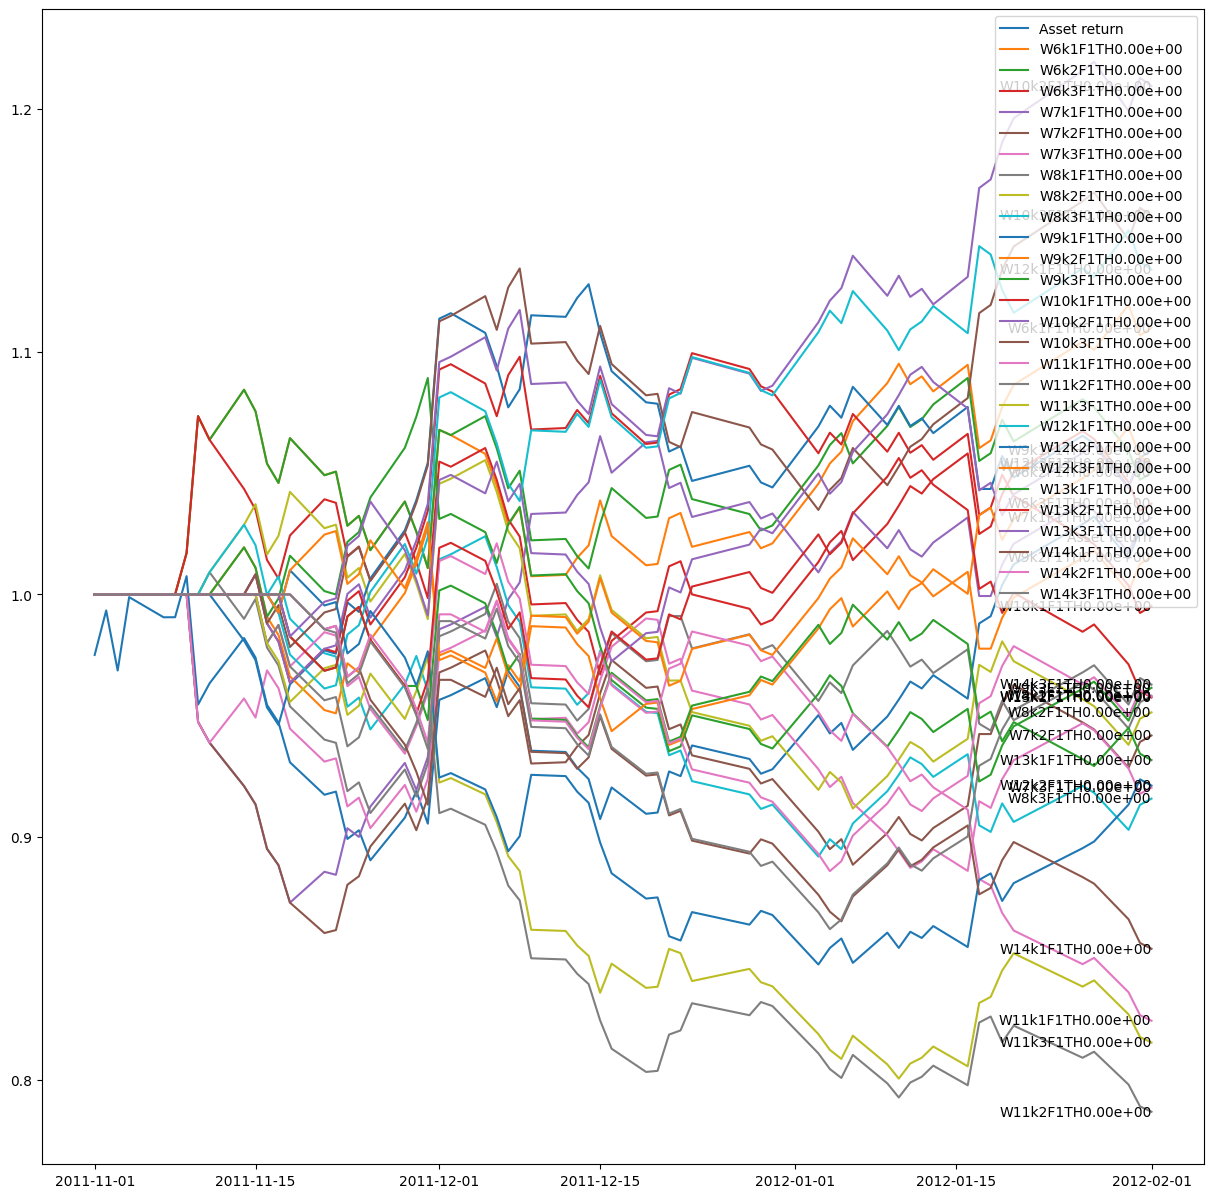

CAGR%  Sharpe Ratio  Sortino Ratio  Max Drawdown%  \
Asset return         9.689341      0.883068       1.339893     -11.616365   
W6k1F1TH0.00e+00    51.199505      1.836838       3.285330      -7.086228   
W6k2F1TH0.00e+00    21.429688      0.923761       1.609226      -6.791563   
W6k3F1TH0.00e+00    15.682360      0.723622       1.229121      -9.913362   
W7k1F1TH0.00e+00    13.158623      0.641603       0.922062     -12.694022   
W7k2F1TH0.00e+00   -21.136804     -0.876500      -1.224140     -13.947012   
W7k3F1TH0.00e+00   -28.033410     -1.262599      -1.772035     -11.386505   
W8k1F1TH0.00e+00   -15.562702     -0.681818      -0.996707      -9.827301   
W8k2F1TH0.00e+00   -17.920948     -0.812663      -1.244183     -13.598737   
W8k3F1TH0.00e+00   -29.428139     -1.526587      -2.158973     -13.286972   
W9k1F1TH0.00e+00    25.682521      1.180245       1.983297      -7.477603   
W9k2F1TH0.00e+00     6.270023      0.397123       0.533432      -6.995354   
W9k3F1TH0.00e+00   -14.410200     -0.629497      -0.796053     -15.257233   
W10k1F1TH0.00e+00   -1.905525      0.015357       0.023522      -9.732738   
W10k2F1TH0.00e+00  112.602974      3.783677       7.359162      -4.658993   
W10k3F1TH0.00e+00   77.735067      2.882121       5.058760      -8.768218   
W11k1F1TH0.00e+00  -53.517596     -3.651125      -4.809909     -19.260532   
W11k2F1TH0.00e+00  -61.354877     -4.691601      -5.186582     -21.308968   
W11k3F1TH0.00e+00  -55.495046     -3.927669      -4.484242     -19.943866   
W12k1F1TH0.00e+00   64.566198      2.542608       5.415743      -4.141738   
W12k2F1TH0.00e+00  -27.775258     -1.502073      -1.910491     -16.076818   
W12k3F1TH0.00e+00   23.145143      1.129835       1.574182      -8.909551   
W13k1F1TH0.00e+00  -24.451131     -1.276455      -1.877581      -7.404503   
W13k2F1TH0.00e+00  -15.809941     -0.734821      -1.121388      -9.339724   
W13k3F1TH0.00e+00   22.643206      1.100921       1.762440      -7.797176   
W14k1F1TH0.00e+00  -46.525068     -3.055570      -4.033019     -14.595852   
W14k2F1TH0.00e+00  -15.662736     -0.739264      -1.141301     -11.395483   
W14k3F1TH0.00e+00  -13.942612     -0.639179      -0.993909     -13.785390   

                   Max Drawdown$  Max Drawdown (Days)  \
Asset return       -11703.823480                   71   
W6k1F1TH0.00e+00    -7683.719628                   55   
W6k2F1TH0.00e+00    -7364.209527                   62   
W6k3F1TH0.00e+00   -10641.151338                   82   
W7k1F1TH0.00e+00   -12694.022030                   47   
W7k2F1TH0.00e+00   -13947.012495                   83   
W7k3F1TH0.00e+00   -11386.505286                   83   
W8k1F1TH0.00e+00    -9917.096234                   79   
W8k2F1TH0.00e+00   -14351.177140                   57   
W8k3F1TH0.00e+00   -13668.326207                   78   
W9k1F1TH0.00e+00    -8433.047976                   48   
W9k2F1TH0.00e+00    -7189.234993                   62   
W9k3F1TH0.00e+00   -16617.446882                   62   
W10k1F1TH0.00e+00  -10699.917217                   35   
W10k2F1TH0.00e+00   -5204.887085                   26   
W10k3F1TH0.00e+00   -9945.484652                   42   
W11k1F1TH0.00e+00  -19666.219934                   56   
W11k2F1TH0.00e+00  -21308.968470                   77   
W11k3F1TH0.00e+00  -19943.865571                   77   
W12k1F1TH0.00e+00   -4486.800950                   12   
W12k2F1TH0.00e+00  -16236.701735                   72   
W12k3F1TH0.00e+00   -9174.639574                   47   
W13k1F1TH0.00e+00   -7431.382187                   58   
W13k2F1TH0.00e+00   -9864.581027                   29   
W13k3F1TH0.00e+00   -8223.613670                   30   
W14k1F1TH0.00e+00  -14595.852092                   72   
W14k2F1TH0.00e+00  -11395.482676                   72   
W14k3F1TH0.00e+00  -13785.390224                   72   

                   Multiples of Invested Capital  Win  Loss       Win%  
Asset return                            1.023584   32    29  52

In [24]:
hsi_DTW_kNN_up_tuning2 =\
    DTW_kNN_tuning(target.iloc[:, -2:],
                   [6, 7, 8, 9, 10, 11, 12, 13, 14], [1, 2, 3], [1],
                   ['2012-06-05', '2013-04-19', train1, test_test],
                   [0], 1e5)

hsi_DTW_kNN_up_tuning2

> #### 3rd round of fine tuning on 3 months to fine tune on Threshold
* W = 10
* K = [2,3]
* TH = [0, 0.0004]

10 2 1 0
10 2 1 0.0001
10 2 1 0.001
10 3 1 0
10 3 1 0.0001
10 3 1 0.001


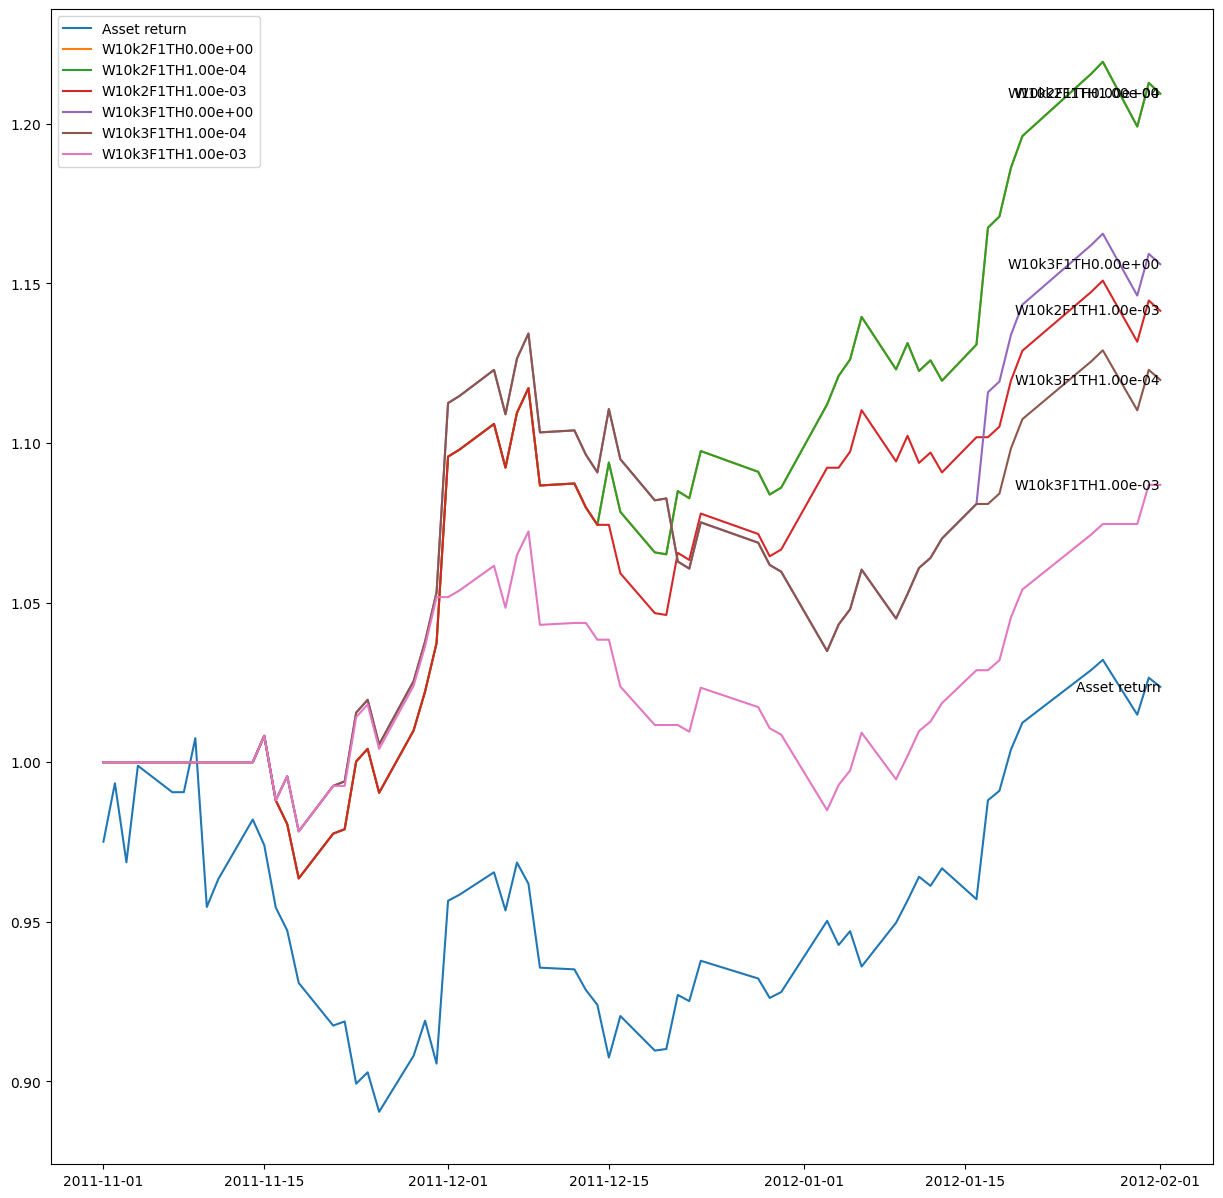

CAGR%  Sharpe Ratio  Sortino Ratio  Max Drawdown%  \
Asset return         9.689341      0.883068       1.339893     -11.616365   
W10k2F1TH0.00e+00  112.602974      3.783677       7.359162      -4.658993   
W10k2F1TH1.00e-04  112.602974      3.783677       7.359162      -4.658993   
W10k2F1TH1.00e-03   68.998502      2.800388       5.157965      -6.360640   
W10k3F1TH0.00e+00   77.735067      2.882121       5.058760      -8.768218   
W10k3F1TH1.00e-04   56.628836      2.361013       3.971473      -8.768218   
W10k3F1TH1.00e-03   39.167954      2.225048       3.209261      -8.145154   

                   Max Drawdown$  Max Drawdown (Days)  \
Asset return       -11703.823480                   71   
W10k2F1TH0.00e+00   -5204.887085                   26   
W10k2F1TH1.00e-04   -5204.887085                   26   
W10k2F1TH1.00e-03   -7105.914939                   41   
W10k3F1TH0.00e+00   -9945.484652                   42   
W10k3F1TH1.00e-04   -9945.484652                   54   
W10k3F1TH1.00e-03   -8733.960534                   49   

                   Multiples of Invested Capital  Win  Loss       Win%  
Asset return                            1.023584   32    29  52.459016  
W10k2F1TH0.00e+00                       1.209387   32    19  62.745098  
W10k2F1TH1.00e-04                       1.209387   32    19  62.745098  
W10k2F1TH1.00e-03                       1.141403   29    19  60.416667  
W10k3F1TH0.00e+00                       1.155996   33    18  64.705882  
W10k3F1TH1.00e-04                       1.119743   32    18  64.000000  
W10k3F1TH1.00e-03                       1.086875   28    14  66.666667

In [25]:
hsi_DTW_kNN_up_tuning3 =\
    DTW_kNN_tuning(target.iloc[:, -2:],
                   [10], [2, 3], [1],
                   ['2012-06-05', '2013-04-19', train1, test_test],
                   [0, 0.0001, 0.001], 1e5)

hsi_DTW_kNN_up_tuning3

> #### 4th round of fine tuning on 3 months to fine tune on Threshold
* W = 10
* K = [2,3]
* TH = [0, 0.001]

10 2 1 0
10 2 1 0.001
10 2 1 0.002
10 2 1 0.003
10 2 1 0.004
10 3 1 0
10 3 1 0.001
10 3 1 0.002
10 3 1 0.003
10 3 1 0.004


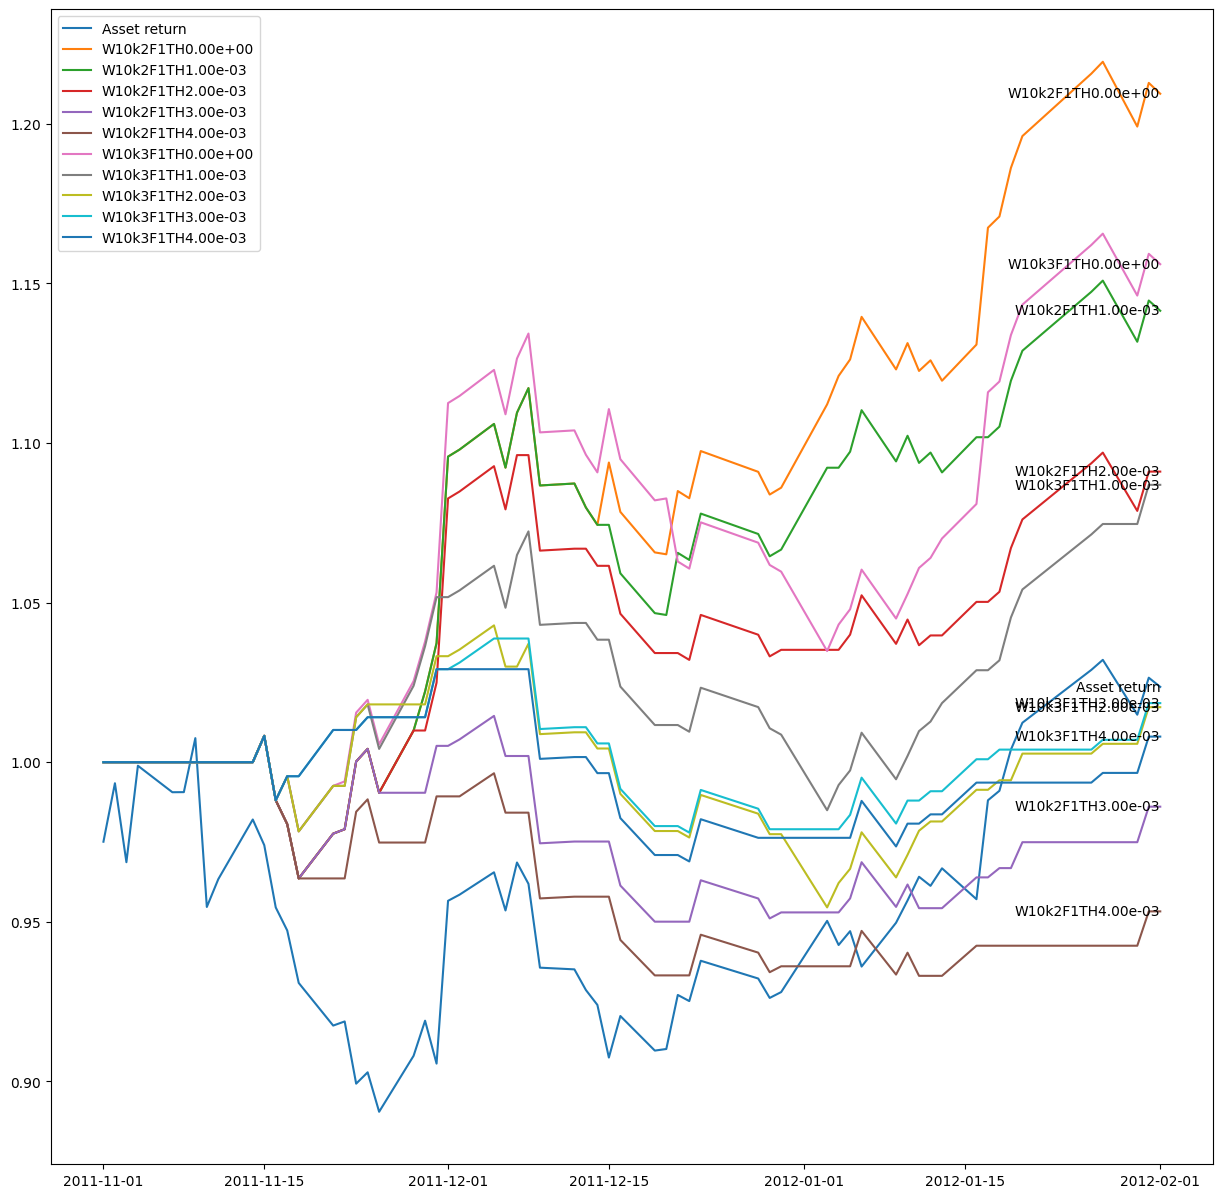

CAGR%  Sharpe Ratio  Sortino Ratio  Max Drawdown%  \
Asset return         9.689341      0.883068       1.339893     -11.616365   
W10k2F1TH0.00e+00  112.602974      3.783677       7.359162      -4.658993   
W10k2F1TH1.00e-03   68.998502      2.800388       5.157965      -6.360640   
W10k2F1TH2.00e-03   41.287750      1.974724       3.491976      -5.852080   
W10k2F1TH3.00e-03   -5.416043     -0.365642      -0.480162      -6.353546   
W10k2F1TH4.00e-03  -17.295291     -1.473112      -1.853697      -7.456663   
W10k3F1TH0.00e+00   77.735067      2.882121       5.058760      -8.768218   
W10k3F1TH1.00e-03   39.167954      2.225048       3.209261      -8.145154   
W10k3F1TH2.00e-03    7.012521      0.567002       0.748260      -8.470958   
W10k3F1TH3.00e-03    7.543416      0.721347       0.952407      -5.852080   
W10k3F1TH4.00e-03    3.217159      0.350749       0.459059      -5.852080   

                   Max Drawdown$  Max Drawdown (Days)  \
Asset return       -11703.823480                   71   
W10k2F1TH0.00e+00   -5204.887085                   26   
W10k2F1TH1.00e-03   -7105.914939                   41   
W10k2F1TH2.00e-03   -6414.985519                   49   
W10k2F1TH3.00e-03   -6445.646955                   57   
W10k2F1TH4.00e-03   -7518.225002                   77   
W10k3F1TH0.00e+00   -9945.484652                   42   
W10k3F1TH1.00e-03   -8733.960534                   49   
W10k3F1TH2.00e-03   -8833.932443                   57   
W10k3F1TH3.00e-03   -6078.769335                   54   
W10k3F1TH4.00e-03   -6022.535153                   54   

                   Multiples of Invested Capital  Win  Loss       Win%  
Asset return                            1.023584   32    29  52.459016  
W10k2F1TH0.00e+00                       1.209387   32    19  62.745098  
W10k2F1TH1.00e-03                       1.141403   29    19  60.416667  
W10k2F1TH2.00e-03                       1.091025   25    15  62.500000  
W10k2F1TH3.00e-03                       0.986063   18    12  60.000000  
W10k2F1TH4.00e-03                       0.953264   12    12  50.000000  
W10k3F1TH0.00e+00                       1.155996   33    18  64.705882  
W10k3F1TH1.00e-03                       1.086875   28    14  66.666667  
W10k3F1TH2.00e-03                       1.017230   22    12  64.705882  
W10k3F1TH3.00e-03                       1.018500   17     9  65.384615  
W10k3F1TH4.00e-03                       1.008013   13     8  61.904762

In [26]:
hsi_DTW_kNN_up_tuning4 =\
    DTW_kNN_tuning(target.iloc[:, -2:],
                   [10], [2, 3], [1],
                   ['2012-06-05', '2013-04-19', train1, test_test],
                   [0, 0.001, 0.002, 0.003, 0.004], 1e5)

hsi_DTW_kNN_up_tuning4

In [27]:
train1, test

('2011-11-01', '2013-11-01')

> #### 5th round of fine tuning on TWO YEARS to fine tune on combinations
* W = 10
* K = 2
* F = 1
* TH = 0.001

10 2 1 0
10 2 1 0.001
10 3 1 0
10 3 1 0.001


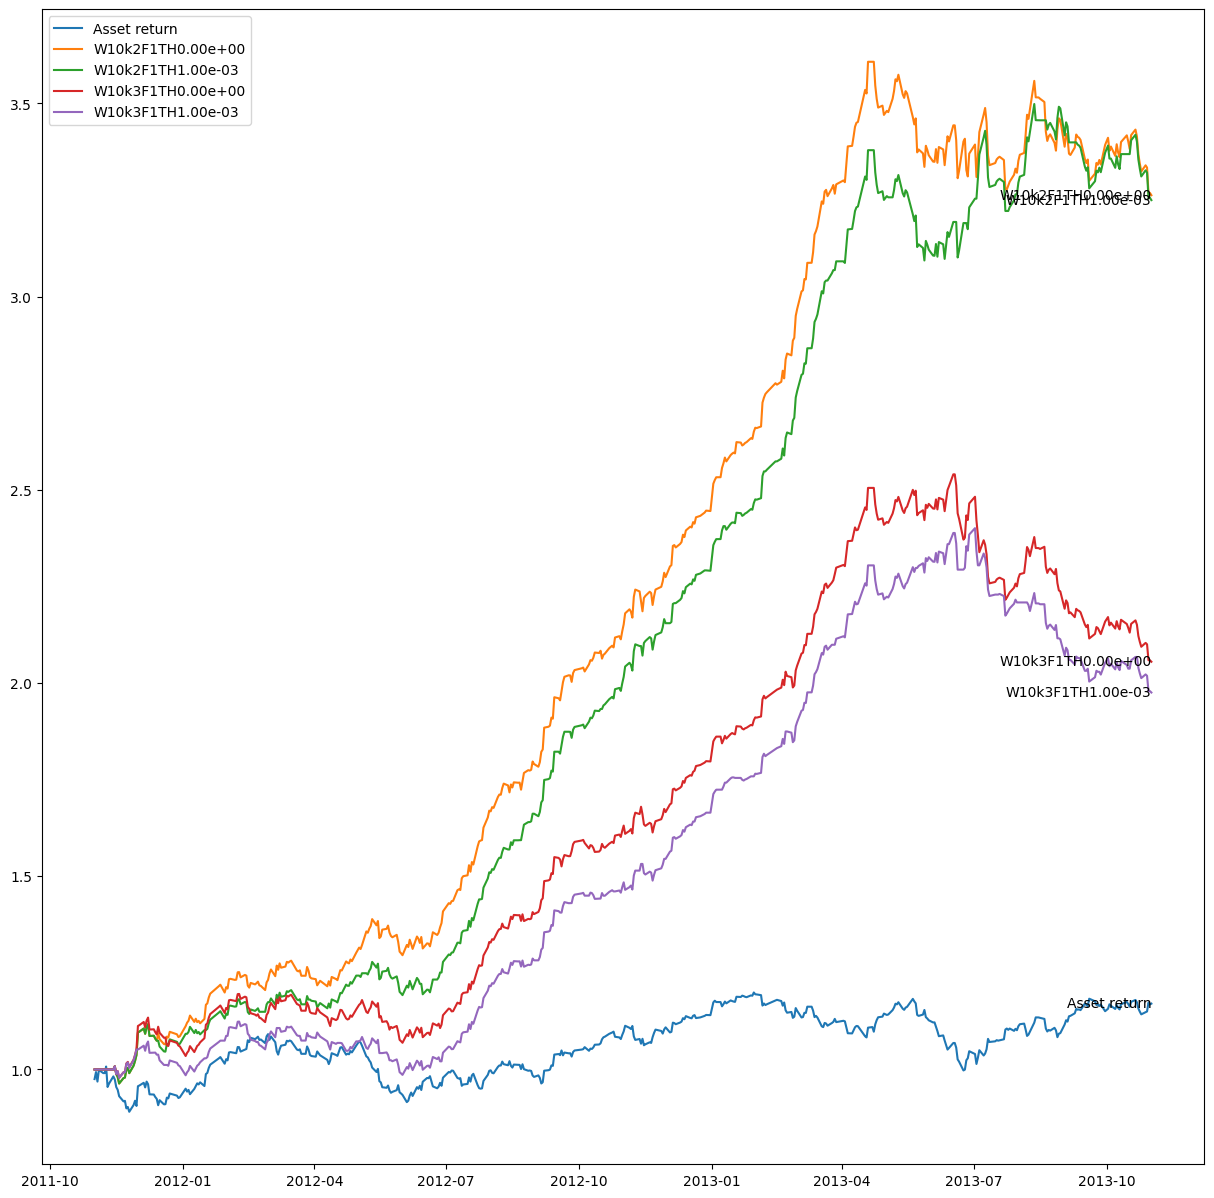

CAGR%  Sharpe Ratio  Sortino Ratio  Max Drawdown%  \
Asset return        8.173259      0.615390       0.896992     -16.825077   
W10k2F1TH0.00e+00  80.475352      3.753282       6.513029      -9.573166   
W10k2F1TH1.00e-03  80.124197      3.953582       7.030537      -8.447442   
W10k3F1TH0.00e+00  43.287195      2.283687       3.672679     -19.092646   
W10k3F1TH1.00e-03  40.486147      2.359612       3.757390     -17.718003   

                   Max Drawdown$  Max Drawdown (Days)  \
Asset return       -20176.725302                  274   
W10k2F1TH0.00e+00  -34537.950009                  191   
W10k2F1TH1.00e-03  -28544.126468                   80   
W10k3F1TH0.00e+00  -48497.668355                  154   
W10k3F1TH1.00e-03  -42538.426971                  164   

                   Multiples of Invested Capital  Win  Loss       Win%  
Asset return                            1.170397  251   241  51.016260  
W10k2F1TH0.00e+00                       3.262408  288   190  60.251046  
W10k2F1TH1.00e-03                       3.249708  264   163  61.826698  
W10k3F1TH0.00e+00                       2.055146  273   206  56.993737  
W10k3F1TH1.00e-03                       1.975475  239   174  57.869249

In [28]:
hsi_DTW_kNN_trend_test =\
    DTW_kNN_tuning(target.iloc[:, -2:],
                   [10], [2,3], [1],
                   ['2012-06-05', '2013-04-19', train1, test],
                   [0, 0.001], 1e5)

hsi_DTW_kNN_trend_test

> # Deploy test on (W,K,F,TH)=(10,2,1,0.001)
* with more effective past data as `UP-TREND` data, 10 years deploy result can be run as one shot.
* `HSI` return is negative, while `DTW-kNN` managed to make some profit.
* Extended testing to 2 years time result in consistance in deployment performance.
* Further improvement might be possible, if fine tuning is carried on 2 years.

> #### Deploy test on best tuned parameters

10 2 1 0.001


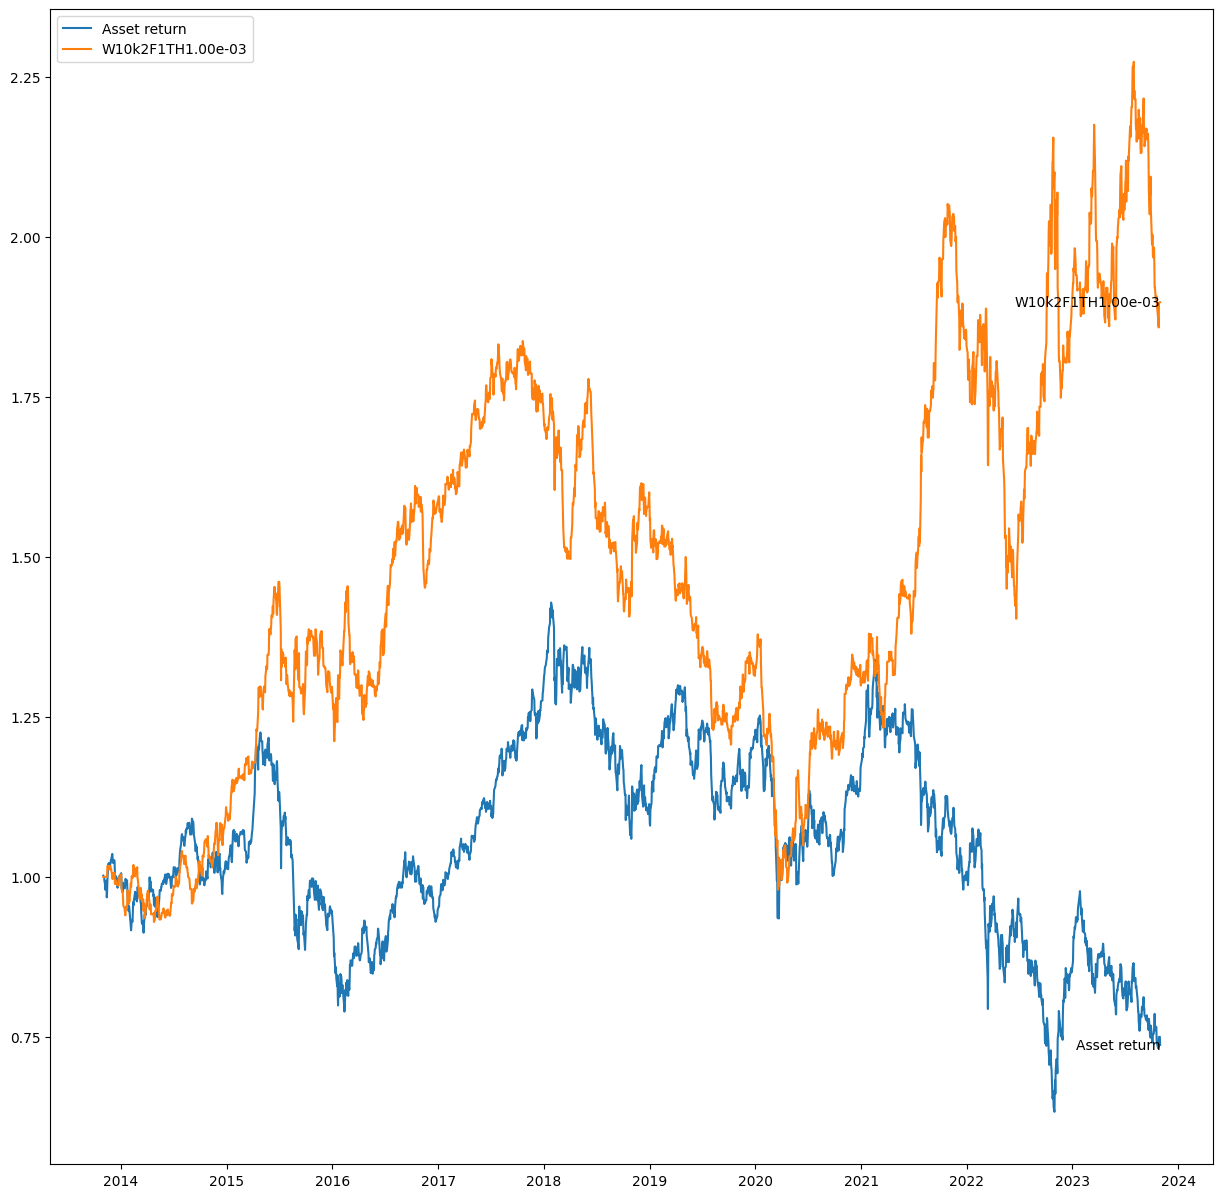

CAGR%  Sharpe Ratio  Sortino Ratio  Max Drawdown%  \
Asset return      -2.999449     -0.050424      -0.071336     -55.700772   
W10k2F1TH1.00e-03  6.615903      0.444959       0.651334     -46.661389   

                   Max Drawdown$  Max Drawdown (Days)  \
Asset return       -79577.729073                 2101   
W10k2F1TH1.00e-03  -85732.499452                 1425   

                   Multiples of Invested Capital   Win  Loss       Win%  
Asset return                            0.737404  1263  1198  51.320601  
W10k2F1TH1.00e-03                       1.898000  1088  1025  51.490771

In [29]:
hsi_DTW_kNN_deploy_120m =\
    DTW_kNN_tuning(target.iloc[:, -2:],
                   [10], [2], [1],
                   ['2012-06-05', '2013-04-19', test, end],
                   [0.001], 1e5)

hsi_DTW_kNN_deploy_120m

>#### Deploy test on FOUR reasonable combinations
* all better than asset return
* best performer changed from test set to deploy set

10 2 1 0
10 2 1 0.001
10 3 1 0
10 3 1 0.001


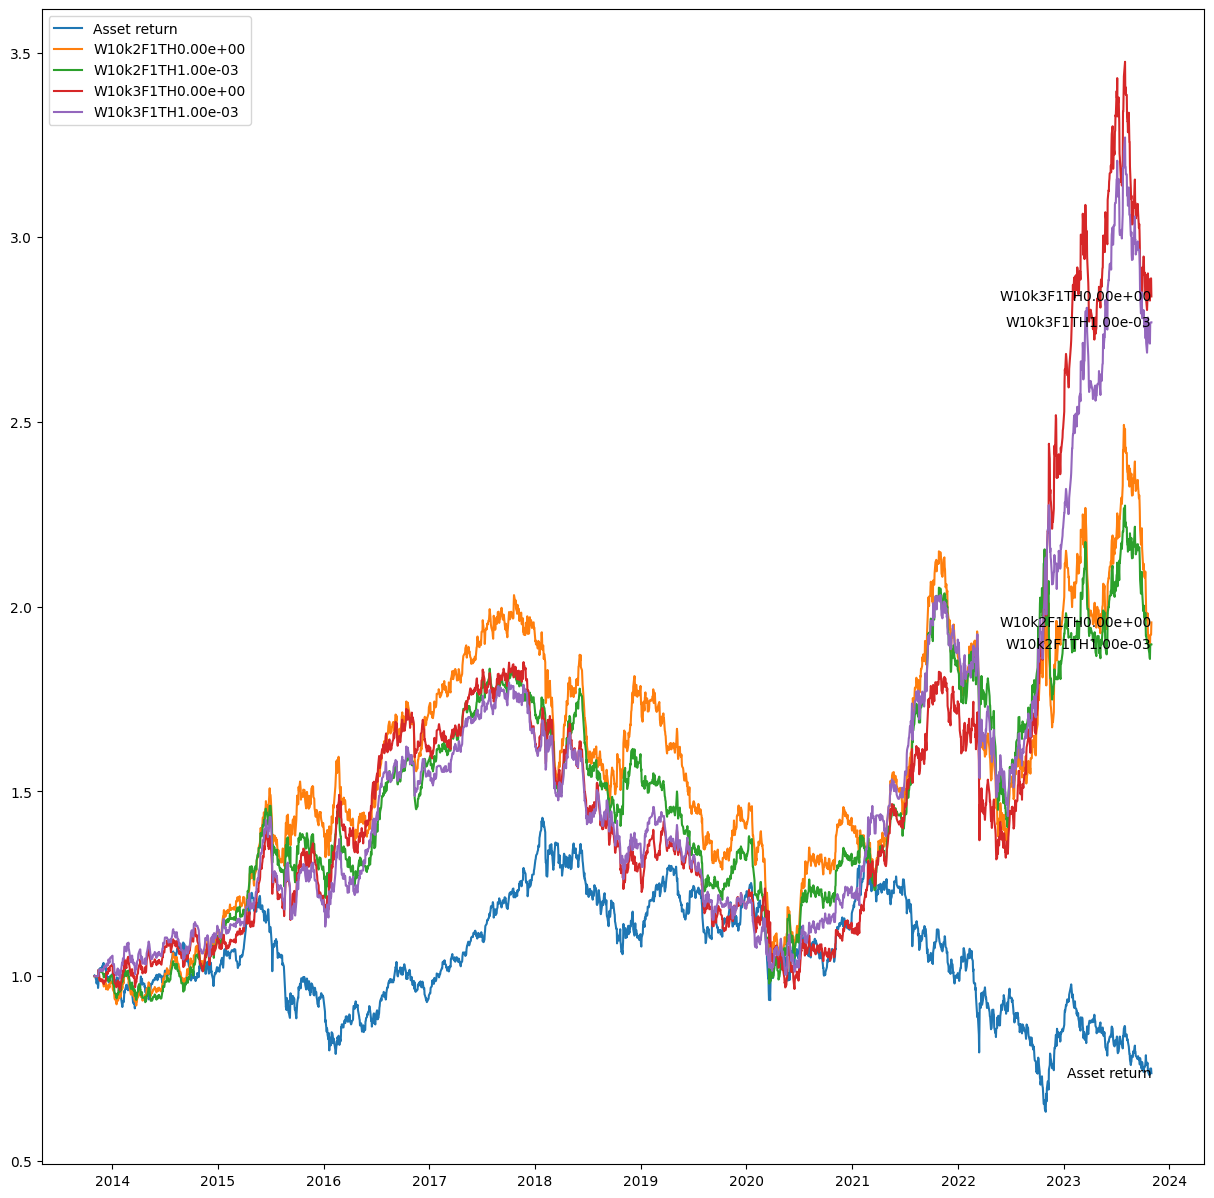

CAGR%  Sharpe Ratio  Sortino Ratio  Max Drawdown%  \
Asset return       -2.999449     -0.050424      -0.071336     -55.700772   
W10k2F1TH0.00e+00   6.945262      0.438848       0.638518     -48.706032   
W10k2F1TH1.00e-03   6.615903      0.444959       0.651334     -46.661389   
W10k3F1TH0.00e+00  10.998773      0.624537       0.924702     -47.825256   
W10k3F1TH1.00e-03  10.721508      0.648196       0.952204     -44.078415   

                   Max Drawdown$  Max Drawdown (Days)  \
Asset return       -79577.729073                 2101   
W10k2F1TH0.00e+00  -98939.220599                 1436   
W10k2F1TH1.00e-03  -85732.499452                 1425   
W10k3F1TH0.00e+00  -88479.618616                 1783   
W10k3F1TH1.00e-03  -79112.825375                 1437   

                   Multiples of Invested Capital   Win  Loss       Win%  
Asset return                            0.737404  1263  1198  51.320601  
W10k2F1TH0.00e+00                       1.957471  1241  1188  51.090984  
W10k2F1TH1.00e-03                       1.898000  1088  1025  51.490771  
W10k3F1TH0.00e+00                       2.839919  1259  1174  51.746815  
W10k3F1TH1.00e-03                       2.769753  1083   974  52.649490

In [30]:
hsi_DTW_kNN_deploy_120m_4 =\
    DTW_kNN_tuning(target.iloc[:, -2:],
                   [10], [2, 3], [1],
                   ['2012-06-05', '2013-04-19', test, end],
                   [0, 0.001], 1e5)

hsi_DTW_kNN_deploy_120m_4

> #### 6th round of fine tuning on TWO YEARS to fine tune on combinations
* W = 15
* K = 1
* F = 1

13 1 1 0
13 1 2 0
13 1 3 0
13 2 1 0
13 2 2 0
13 2 3 0
13 3 1 0
13 3 2 0
13 3 3 0
15 1 1 0
15 1 2 0
15 1 3 0
15 2 1 0
15 2 2 0
15 2 3 0
15 3 1 0
15 3 2 0
15 3 3 0
17 1 1 0
17 1 2 0
17 1 3 0
17 2 1 0
17 2 2 0
17 2 3 0
17 3 1 0
17 3 2 0
17 3 3 0


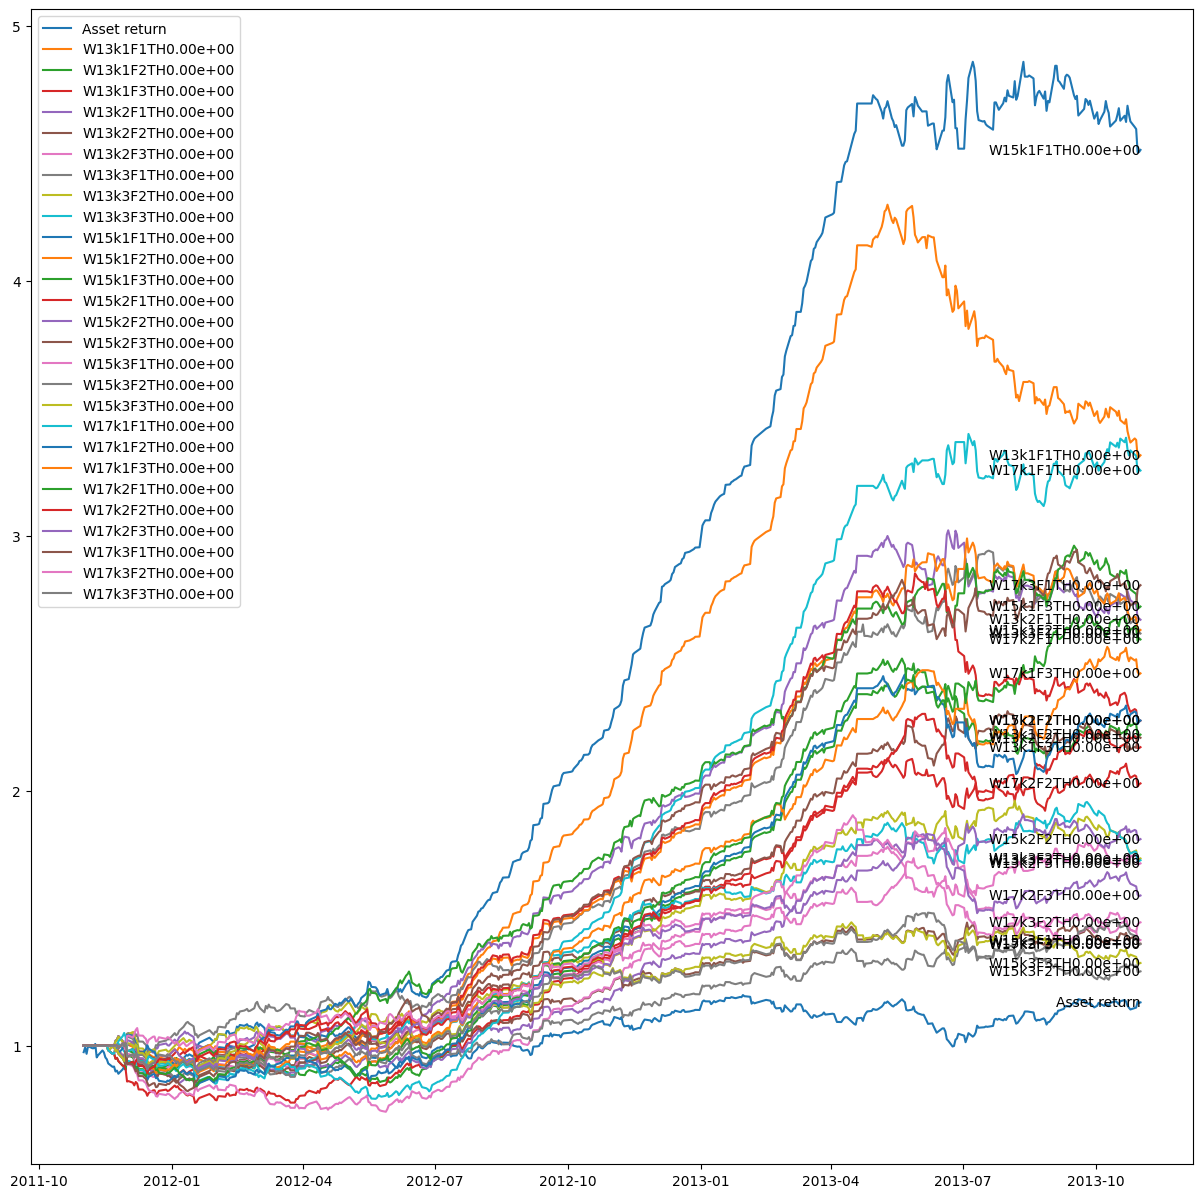

CAGR%  Sharpe Ratio  Sortino Ratio  Max Drawdown%  \
W15k1F1TH0.00e+00  112.236561      4.932839       8.915220     -11.407851   
W13k1F1TH0.00e+00   81.954439      3.870235       6.325557     -23.004790   
W17k1F1TH0.00e+00   80.305646      3.870502       6.182699     -24.597954   
W17k3F1TH0.00e+00   67.412468      3.353120       5.622985     -18.569593   
W15k1F3TH0.00e+00   64.895760      3.224178       5.603164     -10.013406   
W13k2F1TH0.00e+00   63.326975      3.141281       5.334236     -11.604817   
W13k3F1TH0.00e+00   61.668251      3.059547       5.290956     -11.049699   
W15k1F2TH0.00e+00   62.098487      3.114141       5.268556     -12.171647   
W17k2F1TH0.00e+00   60.948149      3.100739       4.986719     -16.478341   
W17k1F3TH0.00e+00   56.775765      2.937240       4.646593     -12.038188   
W13k2F2TH0.00e+00   48.515620      2.531764       4.301922     -16.403289   
W15k2F1TH0.00e+00   50.757564      2.641978       4.294305     -20.393393   
W13k1F2TH0.00e+00   48.935658      2.563009       4.135396     -14.975695   
W17k1F2TH0.00e+00   50.773778      2.683888       4.117715     -16.128287   
W13k1F3TH0.00e+00   47.278723      2.497351       3.891103     -22.360514   
W17k2F2TH0.00e+00   42.378890      2.307006       3.536318     -16.521426   
W15k2F2TH0.00e+00   34.508521      1.918812       3.090411     -15.717439   
W13k3F2TH0.00e+00   31.661837      1.769775       2.816336     -11.730540   
W13k3F3TH0.00e+00   31.399676      1.761477       2.695875     -12.965239   
W13k2F3TH0.00e+00   30.929442      1.746244       2.695076     -15.643480   
W17k2F3TH0.00e+00   26.038863      1.530976       2.303986     -16.937462   
W17k3F2TH0.00e+00   21.797492      1.310760       2.011064     -17.410499   
W15k2F3TH0.00e+00   18.329180      1.121135       1.717589     -16.562071   
W15k3F1TH0.00e+00   18.918587      1.151250       1.659805     -26.362642   
W17k3F3TH0.00e+00   18.237134      1.127981       1.649627     -11.981537   
W15k3F3TH0.00e+00   15.083297      0.945955       1.424906     -10.931729   
W15k3F2TH0.00e+00   13.648017      0.868249       1.323215     -15.402190   
Asset return         8.173259      0.615390       0.896992     -16.825077   

                   Max Drawdown$  Max Drawdown (Days)  \
W15k1F1TH0.00e+00  -35411.074264                  115   
W13k1F1TH0.00e+00  -98896.352754                  172   
W17k1F1TH0.00e+00  -28289.357088                  250   
W17k3F1TH0.00e+00  -23263.531055                  119   
W15k1F3TH0.00e+00  -24397.588527                  127   
W13k2F1TH0.00e+00  -35067.858138                  130   
W13k3F1TH0.00e+00  -32510.533718                  102   
W15k1F2TH0.00e+00  -36394.474035                  140   
W17k2F1TH0.00e+00  -19225.906799                  126   
W17k1F3TH0.00e+00  -29155.084061                  113   
W13k2F2TH0.00e+00  -17385.269534                  149   
W15k2F1TH0.00e+00  -58180.198949                  155   
W13k1F2TH0.00e+00  -37435.539568                  242   
W17k1F2TH0.00e+00  -39056.904576                  231   
W13k1F3TH0.00e+00  -22360.513613                  238   
W17k2F2TH0.00e+00  -38034.850473                  148   
W15k2F2TH0.00e+00  -15907.359361                  231   
W13k3F2TH0.00e+00  -23011.387780                   86   
W13k3F3TH0.00e+00  -23174.997575                  147   
W13k2F3TH0.00e+00  -19613.382945                  154   
W17k2F3TH0.00e+00  -31001.614377                  151   
W17k3F2TH0.00e+00  -30227.005940                  156   
W15k2F3TH0.00e+00  -16585.461258                  161   
W15k3F1TH0.00e+00  -50208.060255                  274   
W17k3F3TH0.00e+00  -18241.860192                  151   
W15k3F3TH0.00e+00  -16211.231558                  199   
W15k3F2TH0.00e+00  -16099.194845                  263   
Asset return       -20176.725302                  274   

                   Multiples of Invested Capital  Win  Loss       Win%  
W15k1F1TH0.00e+00                       4.513732  336   124  73

In [31]:
hsi_DTW_kNN_tuning_trending =\
    DTW_kNN_tuning(target.iloc[:, -2:],
                   [13,15,17], [1,2,3], [1,2,3],
                   ['2012-06-05', '2013-04-19', train1, test],
                   [0], 1e5)

hsi_DTW_kNN_tuning_trending.sort_values(by='Sortino Ratio', ascending = False)

> #### 7th round of fine tuning on TWO YEARS to fine tune on Threshold
* W = 15
* K = 1
* F = 1
* TH = 0.001

10 1 1 0
10 1 1 0.001
10 2 1 0
10 2 1 0.001
10 3 1 0
10 3 1 0.001
15 1 1 0
15 1 1 0.001
15 2 1 0
15 2 1 0.001
15 3 1 0
15 3 1 0.001


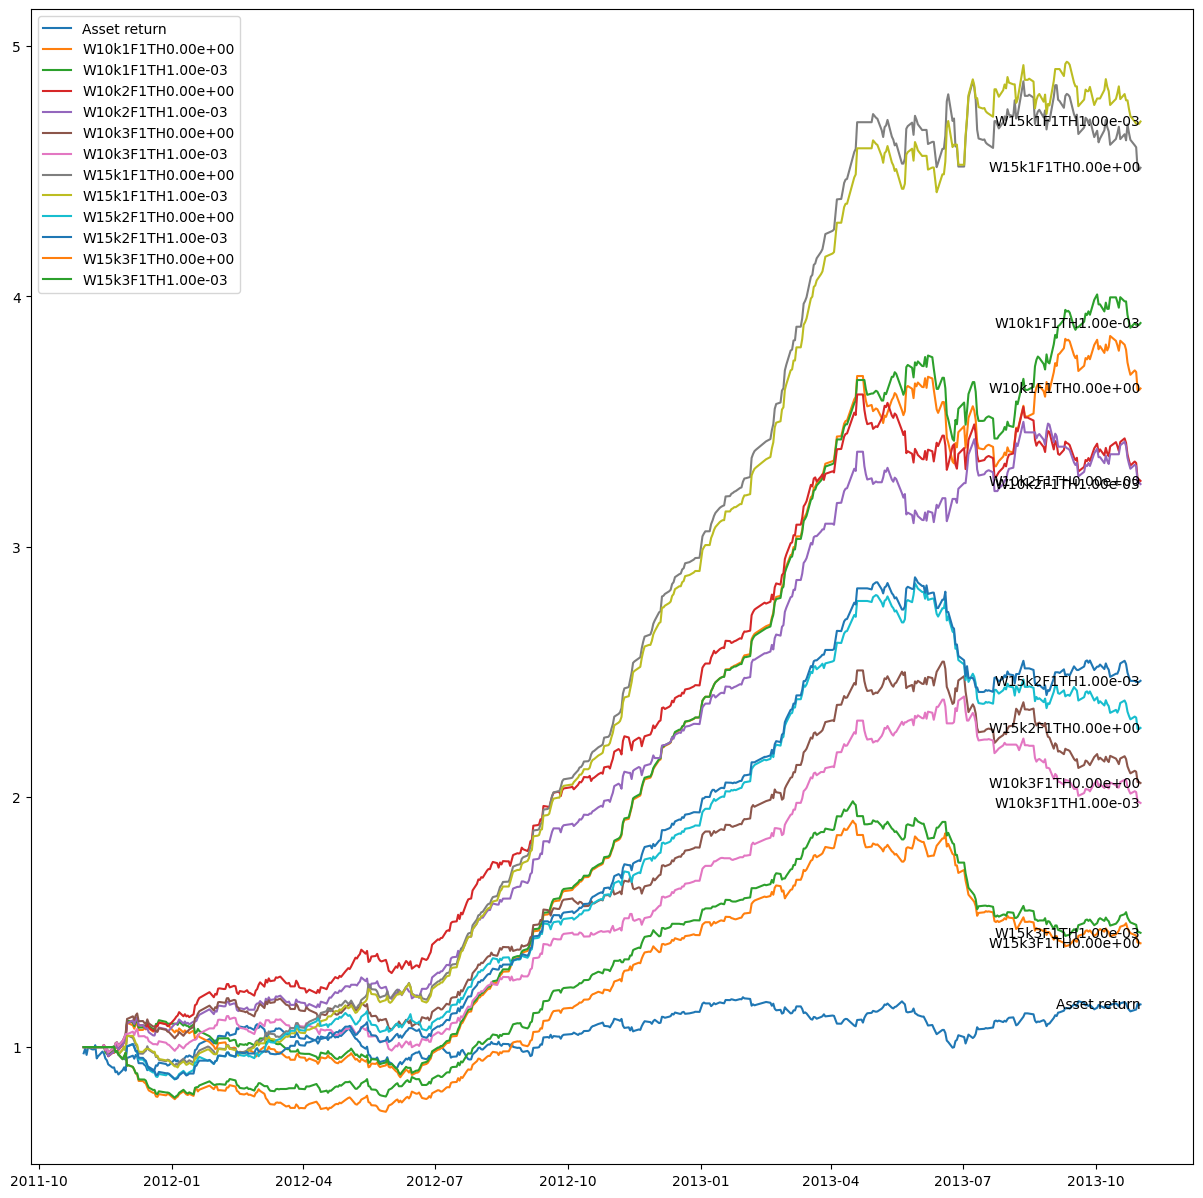

CAGR%  Sharpe Ratio  Sortino Ratio  Max Drawdown%  \
Asset return         8.173259      0.615390       0.896992     -16.825077   
W10k1F1TH0.00e+00   90.404168      4.111681       6.793496     -20.010155   
W10k1F1TH1.00e-03   97.130911      4.501638       7.703605     -19.633868   
W10k2F1TH0.00e+00   80.475352      3.753282       6.513029      -9.573166   
W10k2F1TH1.00e-03   80.124197      3.953582       7.030537      -8.447442   
W10k3F1TH0.00e+00   43.287195      2.283687       3.672679     -19.092646   
W10k3F1TH1.00e-03   40.486147      2.359612       3.757390     -17.718003   
W15k1F1TH0.00e+00  112.236561      4.932839       8.915220     -11.407851   
W15k1F1TH1.00e-03  116.533749      5.279378      10.015092     -12.079303   
W15k2F1TH0.00e+00   50.757564      2.641978       4.294305     -20.393393   
W15k2F1TH1.00e-03   56.860893      3.061402       5.192326     -16.358991   
W15k3F1TH0.00e+00   18.918587      1.151250       1.659805     -26.362642   
W15k3F1TH1.00e-03   20.657097      1.293490       1.887812     -27.161187   

                   Max Drawdown$  Max Drawdown (Days)  \
Asset return       -20176.725302                  274   
W10k1F1TH0.00e+00  -36062.971406                  208   
W10k1F1TH1.00e-03  -34064.654514                  227   
W10k2F1TH0.00e+00  -34537.950009                  191   
W10k2F1TH1.00e-03  -28544.126468                   80   
W10k3F1TH0.00e+00  -48497.668355                  154   
W10k3F1TH1.00e-03  -42538.426971                  164   
W15k1F1TH0.00e+00  -35411.074264                  115   
W15k1F1TH1.00e-03  -24739.969261                  108   
W15k2F1TH0.00e+00  -58180.198949                  155   
W15k2F1TH1.00e-03  -47067.524552                  155   
W15k3F1TH0.00e+00  -50208.060255                  274   
W15k3F1TH1.00e-03  -53838.396415                  250   

                   Multiples of Invested Capital  Win  Loss       Win%  
Asset return                            1.170397  251   241  51.016260  
W10k1F1TH0.00e+00                       3.631777  338   140  70.711297  
W10k1F1TH1.00e-03                       3.893292  293   121  70.772947  
W10k2F1TH0.00e+00                       3.262408  288   190  60.251046  
W10k2F1TH1.00e-03                       3.249708  264   163  61.826698  
W10k3F1TH0.00e+00                       2.055146  273   206  56.993737  
W10k3F1TH1.00e-03                       1.975475  239   174  57.869249  
W15k1F1TH0.00e+00                       4.513732  336   124  73.043478  
W15k1F1TH1.00e-03                       4.698621  299   109  73.284314  
W15k2F1TH0.00e+00                       2.275342  279   185  60.129310  
W15k2F1TH1.00e-03                       2.463571  245   153  61.557789  
W15k3F1TH0.00e+00                       1.414835  264   204  56.410256  
W15k3F1TH1.00e-03                       1.456563  233   176  56.968215

In [32]:
hsi_DTW_kNN_trend_test15 =\
    DTW_kNN_tuning(target.iloc[:, -2:],
                   [10,15], [1,2,3], [1],
                   ['2012-06-05', '2013-04-19', train1, test],
                   [0, 0.001], 1e5)

hsi_DTW_kNN_trend_test15

> # Deploy test on (W,K,F,TH) with other reasonable combinations

* with more effective past data as `UP-TREND` data, 10 years deploy result can be run as one shot.
* `HSI` return is negative, while all current `DTW-kNN` managed to make some profit.
* Extended testing to 2 years time result in consistance in deployment performance.
* Not seen an improvement in Sortino ratio

15 1 1 0
15 1 1 0.001
15 1 2 0
15 1 2 0.001


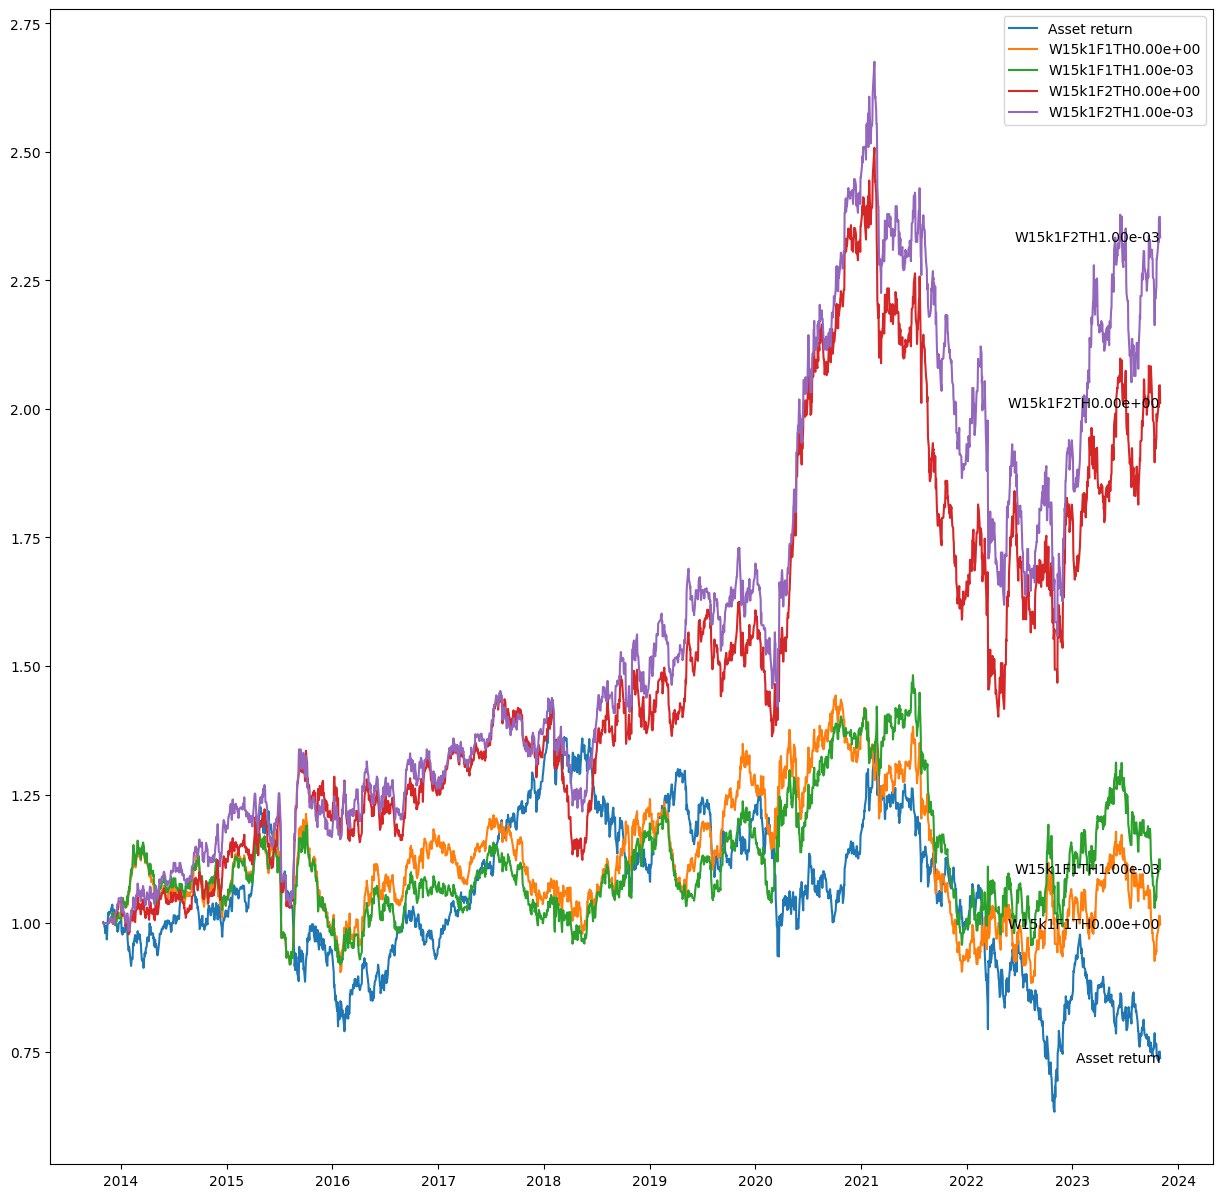

CAGR%  Sharpe Ratio  Sortino Ratio  Max Drawdown%  \
Asset return      -2.999449     -0.050424      -0.071336     -55.700772   
W15k1F1TH0.00e+00 -0.031434      0.097850       0.139730     -38.763747   
W15k1F1TH1.00e-03  1.004919      0.149205       0.213652     -35.448464   
W15k1F2TH0.00e+00  7.236706      0.459107       0.670277     -44.122222   
W15k1F2TH1.00e-03  8.841278      0.561717       0.822546     -41.754882   

                   Max Drawdown$  Max Drawdown (Days)  \
Asset return       -79577.729073                 2101   
W15k1F1TH0.00e+00  -55924.077619                 1141   
W15k1F1TH1.00e-03  -52540.602431                 1183   
W15k1F2TH0.00e+00 -110654.393910                  986   
W15k1F2TH1.00e-03 -111703.785869                  986   

                   Multiples of Invested Capital   Win  Loss       Win%  
Asset return                            0.737404  1263  1198  51.320601  
W15k1F1TH0.00e+00                       0.996860  1183  1166  50.361856  
W15k1F1TH1.00e-03                       1.105191  1075  1051  50.564440  
W15k1F2TH0.00e+00                       2.011489  1194  1155  50.830140  
W15k1F2TH1.00e-03                       2.333658  1051   989  51.519608

In [33]:
hsi_DTW_kNN_deploy_120m_15 =\
    DTW_kNN_tuning(target.iloc[:, -2:],
                   [15], [1], [1,2],
                   ['2012-06-05', '2013-04-19', test, end],
                   [0, 0.001], 1e5)

hsi_DTW_kNN_deploy_120m_15

> # Conclusion on DTW-kNN:
1. Is able to make profit
2. fine tuning is very computionally costly
3. Best test combination in is (W, K, F, TH) = (15, 1, 1, 0.01)
4. However, current deploy best combination is (W, K, F, TH) = (10, 3, 1, 0)
5. possible improvment:
* fine tune on effectiveness of `TRENDING DATA`
* threshold for euclidean distance to be explored
* further construction of past data to include `UP TREND`, `DOWN TREND`, and `CONSOLIDATION BOX`
* further fine tuning on parameters